In [1]:
""" 03 - Word2vec

    
References: 
    - Tomas Mikolov, Kai Chen, Greg Corrado, Jeffrey Dean, "Efficient Estimation of Word Representations in Vector Space", arXiv:1301.3781 [cs.CL], Sep 2013
    - https://www.ranks.nl/stopwords
    - Vector Representations of Words. Retrieved from https://www.tensorflow.org/tutorials/word2vec

Author: Paweł Kubiak
"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt #visualize results
import gensim
from tqdm import tqdm
%matplotlib inline


In [2]:
# Load data
from collections import Counter
from functools import partial

# Generator of words
def stream(fn):
    with open(fn) as file:
        buff = ''
        for line in iter(partial(file.read, 2048), ''):
            buff += line
            buff = buff.split(' ')
            for word in buff[:-1]:
                yield word
            buff = buff[-1]
        yield buff
    
freq = Counter()
for w in stream('./text8'):
    freq[w] += 1

items = sorted(filter(lambda x: x[1] > 5, freq.items()), key = lambda x: x[1], reverse = True)

# Filter out stopwords
stopwords = ['i', 'a', 'about', 'an', 'are', 'as', 'at', 'be', 'by', 'com', 'for', 'from', 'how', 'in', 'is', 'it', 'of', 'on', 'or', 'that', 'the', 'this', 'to', 'was', 'what', 'when', 'where', 'who', 'will', 'with', 'the', 'www']
stopwords += list('qwertyuiopasdfghjklzxcvbnm')

items = list(filter(lambda x: not x[0] in stopwords, items[:1000])) + items[1000:]

# Reverse mapping
items_rev = {}
for i in enumerate(items):
    items_rev[i[1][0]] = i[0]

# Helper functions
def int2word(n):
    return items[n][0]

def word2int(w):
    return items_rev.get(w.lower(), -1)

# Corpus as list of words ids, -1 for ommited word.
corpus = list(map(word2int, stream('./text8')))

# Remove unk and rare words.
#corpus = list(filter(lambda x: x != -1, map(word2int, stream('./text8'))))

print("vocabulary size: {}\ncorpus size: {}".format(len(items), len(corpus)))

vocabulary size: 63588
corpus size: 17005208


In [3]:
import random

# Get sample for learning (word, context)
def sample(corpus, window_size):
    while True:
        for i in range(len(corpus)):
            if corpus[i] != -1:
                for j in range(-window_size, window_size+1):
                    if j != 0 and 0 <= i+j < len(corpus) and corpus[i+j] != -1:
                        yield (corpus[i], corpus[i+j])
                    
def sample_fast(corpus, window_size):
    data_x, data_y = [], []
    
    for i in range(len(corpus)):
        if corpus[i] != -1:
            for j in range(-window_size, window_size+1):
                if j != 0 and 0 <= i+j < len(corpus) and corpus[i+j] != -1:
                    data_x.append(corpus[i])
                    data_y.append(corpus[i+j])
    return data_x, data_y

def sample_fast2(corpus, window_size, bs = 512):
    data_x, data_y = [], []
    indices = range(len(corpus))
    offset = list(range(-window_size, window_size+1))
    idx = 0
    while True:
        for i in random.sample(indices, bs*100):
            if corpus[i] != -1:
#                 for j in range(-window_size, window_size+1):
                j = offset[idx%len(offset)]
                idx += 1
    
                if j != 0 and 0 <= i+j < len(corpus) and corpus[i+j] != -1:
                    data_x.append(corpus[i])
                    data_y.append([corpus[i+j]])

                    if len(data_x) == bs:
#                             yield (np.array(data_x), np.array(data_y).reshape((-1,1))) # 32it/s
                        yield (data_x, data_y) # 26it/s
                        data_x = []
                        data_y = []
                    
# Generate batch
def batch(corpus, window_size = 5, bs = 512):
    e = sample(corpus, window_size)
    while True:
        items = [next(e) for i in range(bs)]
        yield (np.array([i[0] for i in items]), np.array([i[1] for i in items]).reshape(len(items), 1))


from sklearn.manifold import TSNE
def visualize(embedding, size = 200):
    tsne = TSNE().fit_transform(embedding[:size])
    fig, ax = plt.subplots(figsize=(20, 20))
    for idx in range(size):
        plt.scatter(*tsne[idx, :], color='steelblue')
        plt.annotate(int2word(idx), (tsne[idx, 0], tsne[idx, 1]), alpha=0.7)
    plt.show()
    
#g = sample_fast2(corpus, 5, 512)
#print(next(g))
#print(corpus[:1000])
#x, y = sample_fast(corpus, window_size)
#print(len(x))

In [17]:
# Hyperparameters
words_count = len(items)
embedding_size = 50
window_size = 5
batch_size = 1024*10

graph = tf.Graph()

from functools import partial
import time

with graph.as_default():

    dataset = tf.data.Dataset.from_generator(
        lambda : batch(corpus, window_size, batch_size), 
        (tf.int32, tf.int32), 
        (tf.TensorShape([batch_size]), tf.TensorShape([batch_size, 1]))
    ).prefetch(10000)

    print(dataset)

    it = dataset.make_one_shot_iterator()
    train_x, train_y = it.get_next()
       
    
    # Network
    embedding = tf.Variable(tf.random_uniform([words_count, embedding_size], -0.5/embedding_size, 0.5/embedding_size))
    embed = tf.nn.embedding_lookup(embedding, train_x)

    weights = tf.Variable(tf.zeros([words_count, embedding_size]))
    biases = tf.Variable(tf.zeros([words_count]))

    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights, biases, train_y, embed,
                                   num_sampled = 10, num_classes = words_count, num_true = 1)
        )


    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=2.0).minimize(loss)
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.005
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           20000, 0.82, staircase=True)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    #tf.summary.scalar('loss', loss)
    
    init = tf.global_variables_initializer()

<PrefetchDataset shapes: ((10240,), (10240, 1)), types: (tf.int32, tf.int32)>


In [8]:
def save_word2vec(word_embeddings, int2word, file):
    word_embeddings = word_embeddings[:30000]
    with open(file, 'w') as f:
        f.write('%s %s\n' % (len(word_embeddings), len(word_embeddings[0])))
        
        for i, embedding in enumerate(word_embeddings):
            params = ['{:.6f}'.format(x) for x in embedding]
            f.write('%s %s\n' % (int2word(i), ' '.join(params)))            
#         f.flush()

def evaluate(word_embeddings, int2word, question_words_file):
    file = './temp_model.vec'
    save_word2vec(word_embeddings, int2word, file)
    model = gensim.models.KeyedVectors.load_word2vec_format(file)
    accuracy = model.accuracy(question_words_file)
    total = [section for section in accuracy if section['section'] == 'total'][0]
#     print(total)
    return (len(total['correct']), len(total['correct'])+len(total['incorrect']))

# with sess.as_default():
#     evaluate(embedding.eval(), int2word, './questions-words.txt')

[16607]


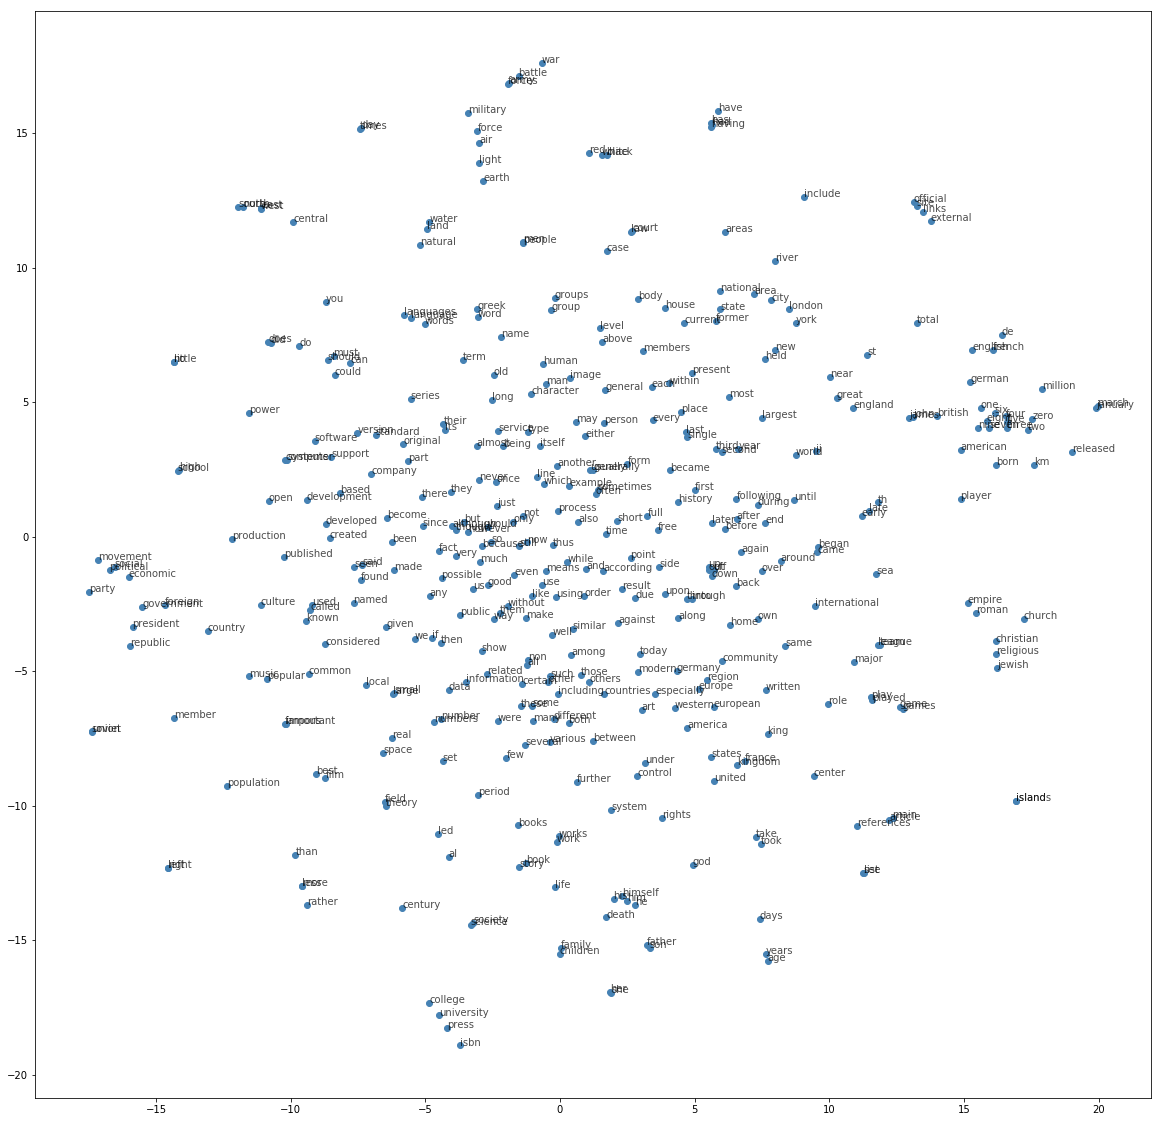

epoch: 1, avg. loss: 2.8019056493006103, gensim: 676, accuracy: 5.510270622758396%


[33214]


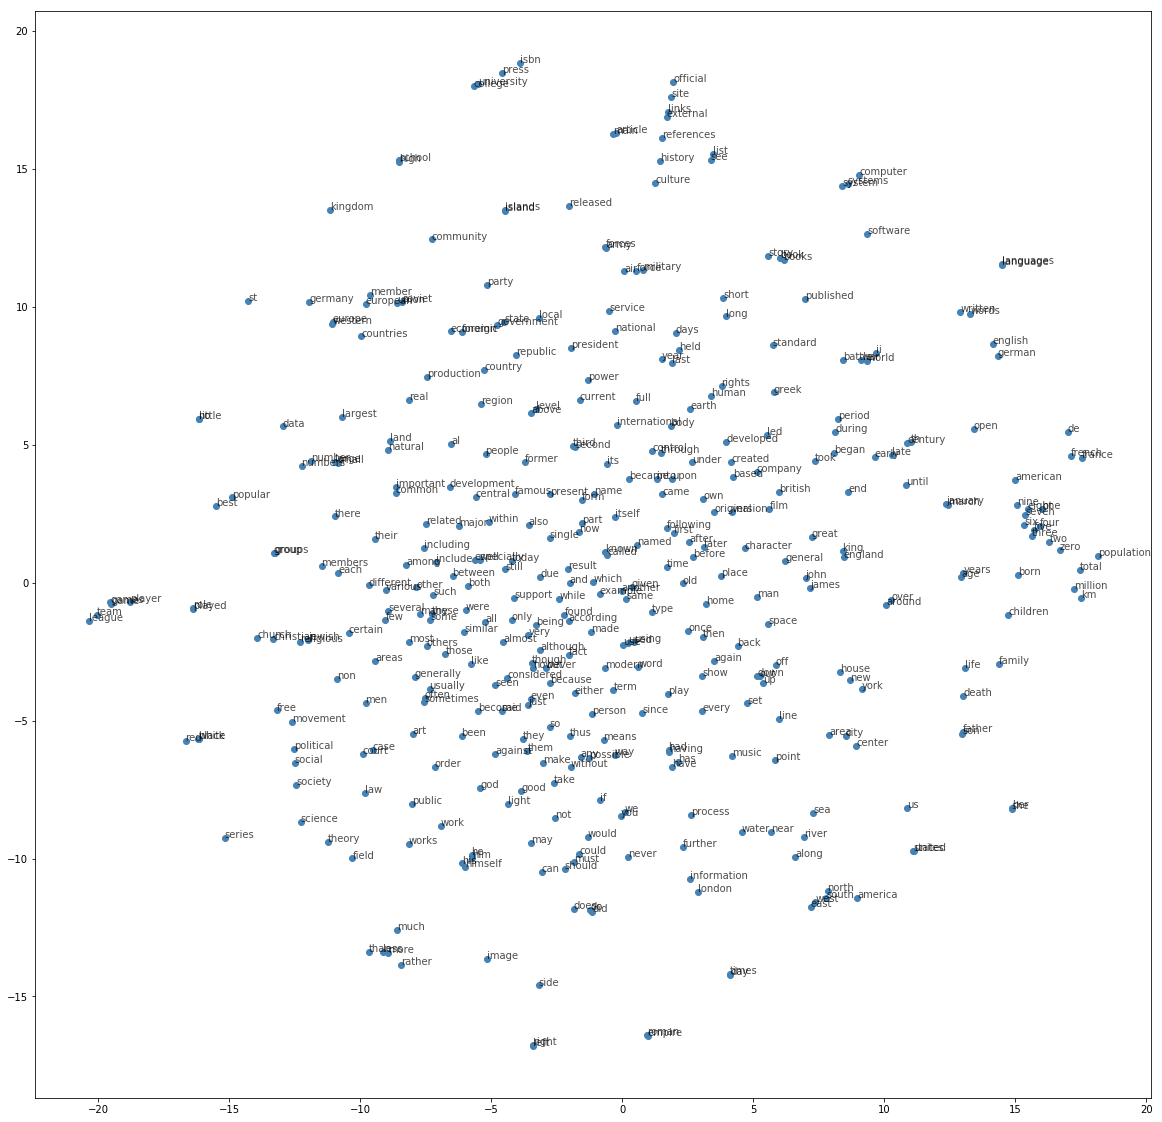

epoch: 2, avg. loss: 2.6399693788192216, gensim: 931, accuracy: 7.588849038148028%


[49821]


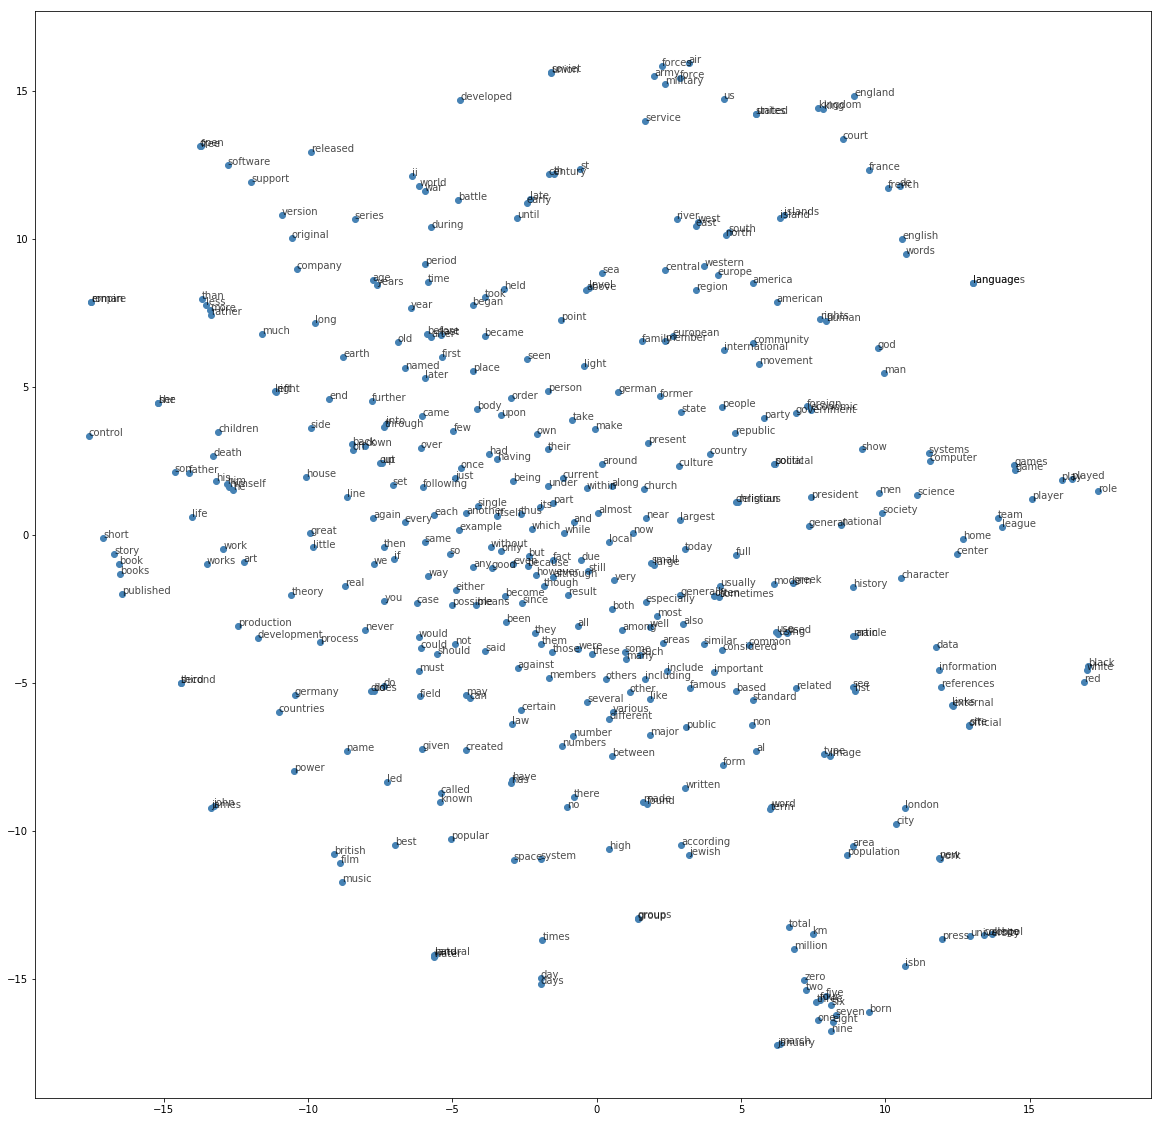

epoch: 3, avg. loss: 2.6871010727955875, gensim: 958, accuracy: 7.808933811542223%


[66428]


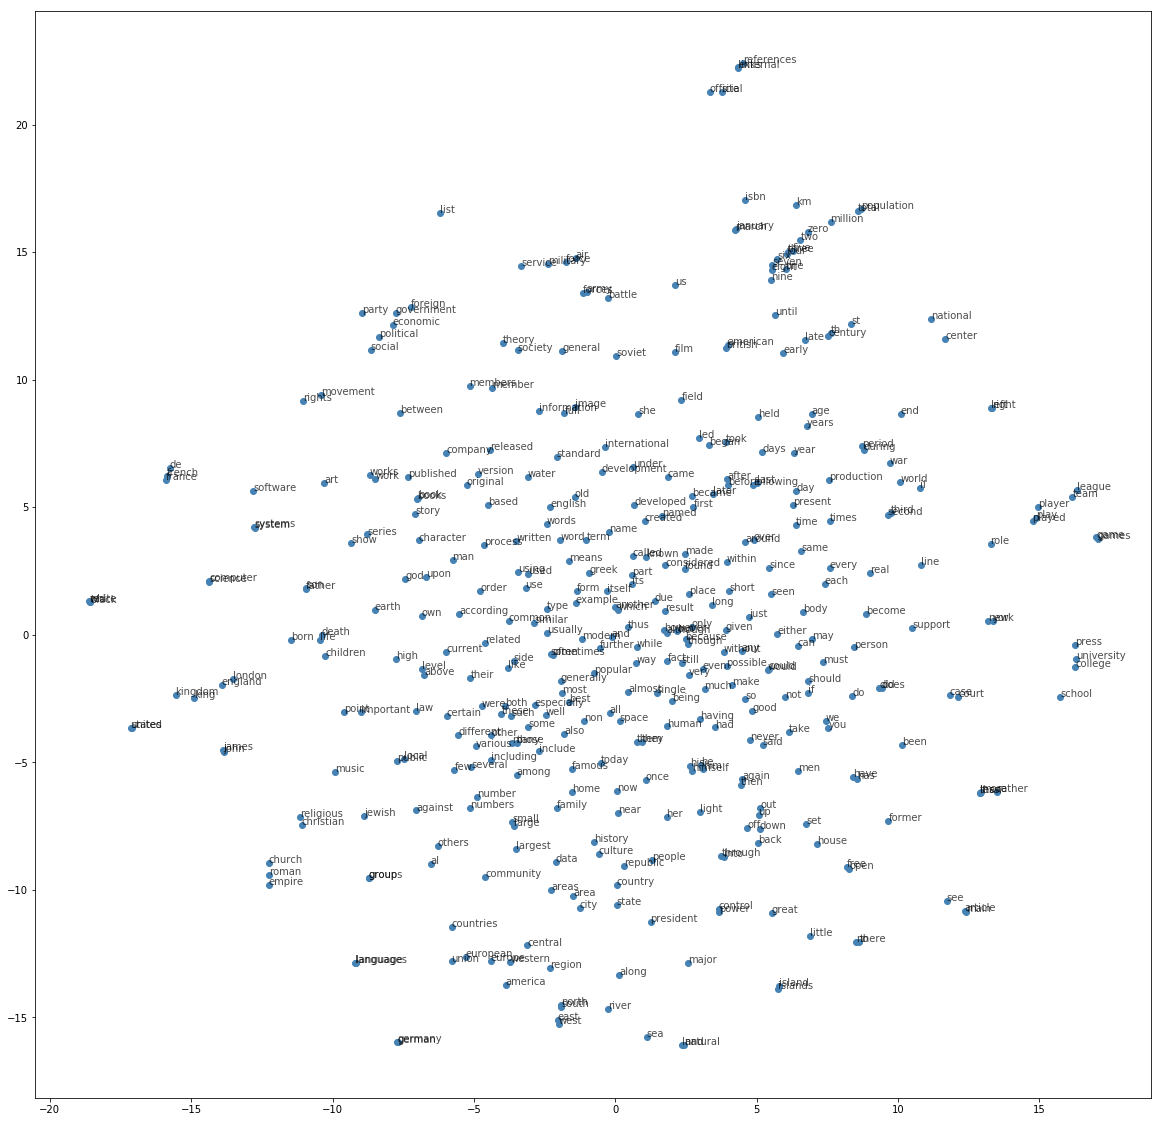

epoch: 4, avg. loss: 2.7162622056676398, gensim: 1185, accuracy: 9.65927616563417%


[83035]


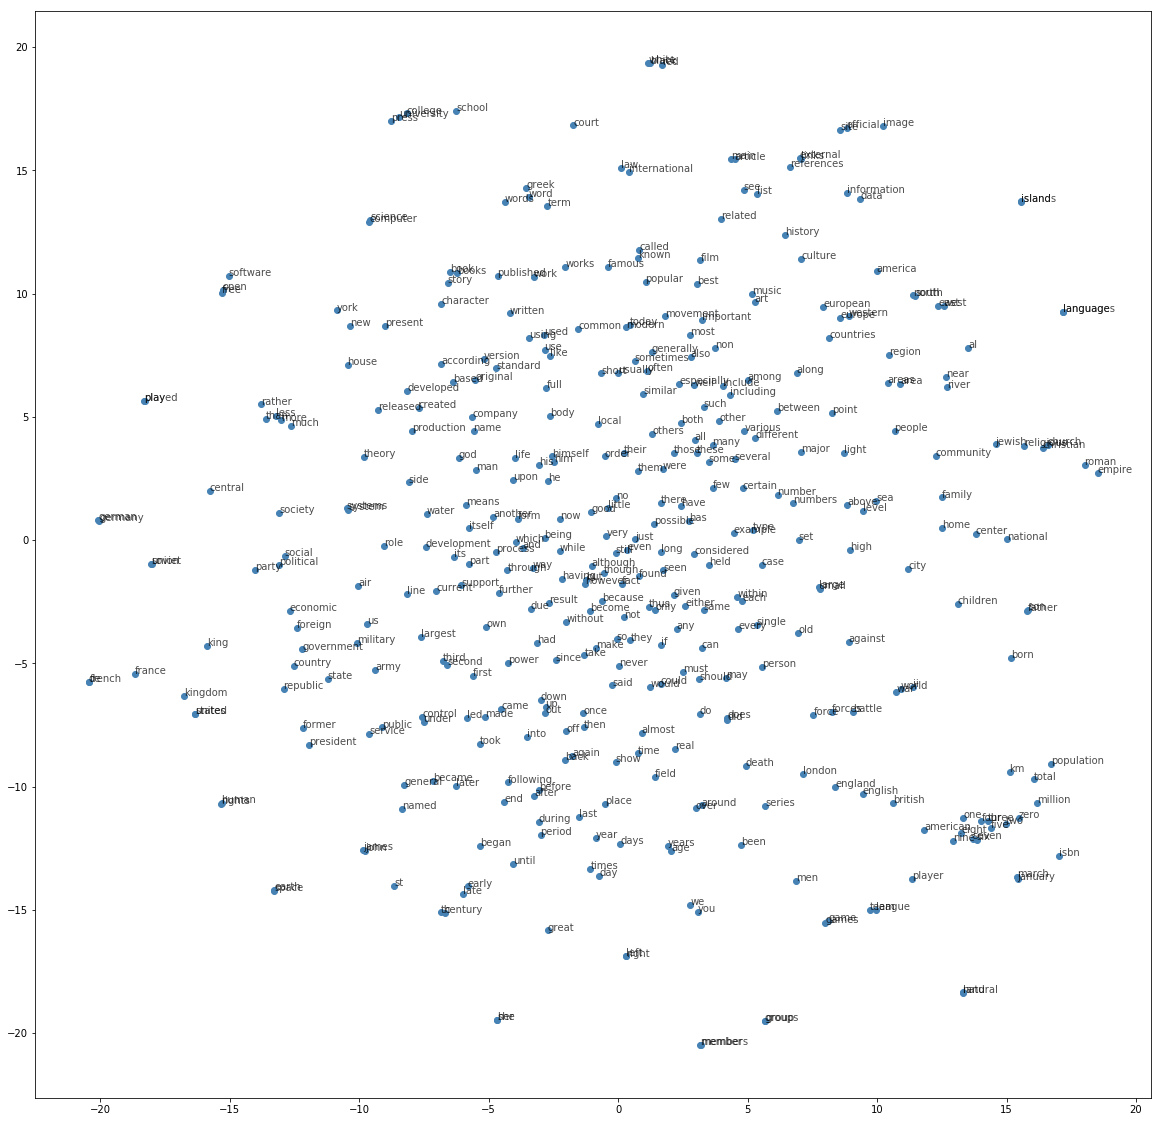

epoch: 5, avg. loss: 2.714699530190751, gensim: 1203, accuracy: 9.805999347896968%


[99642]


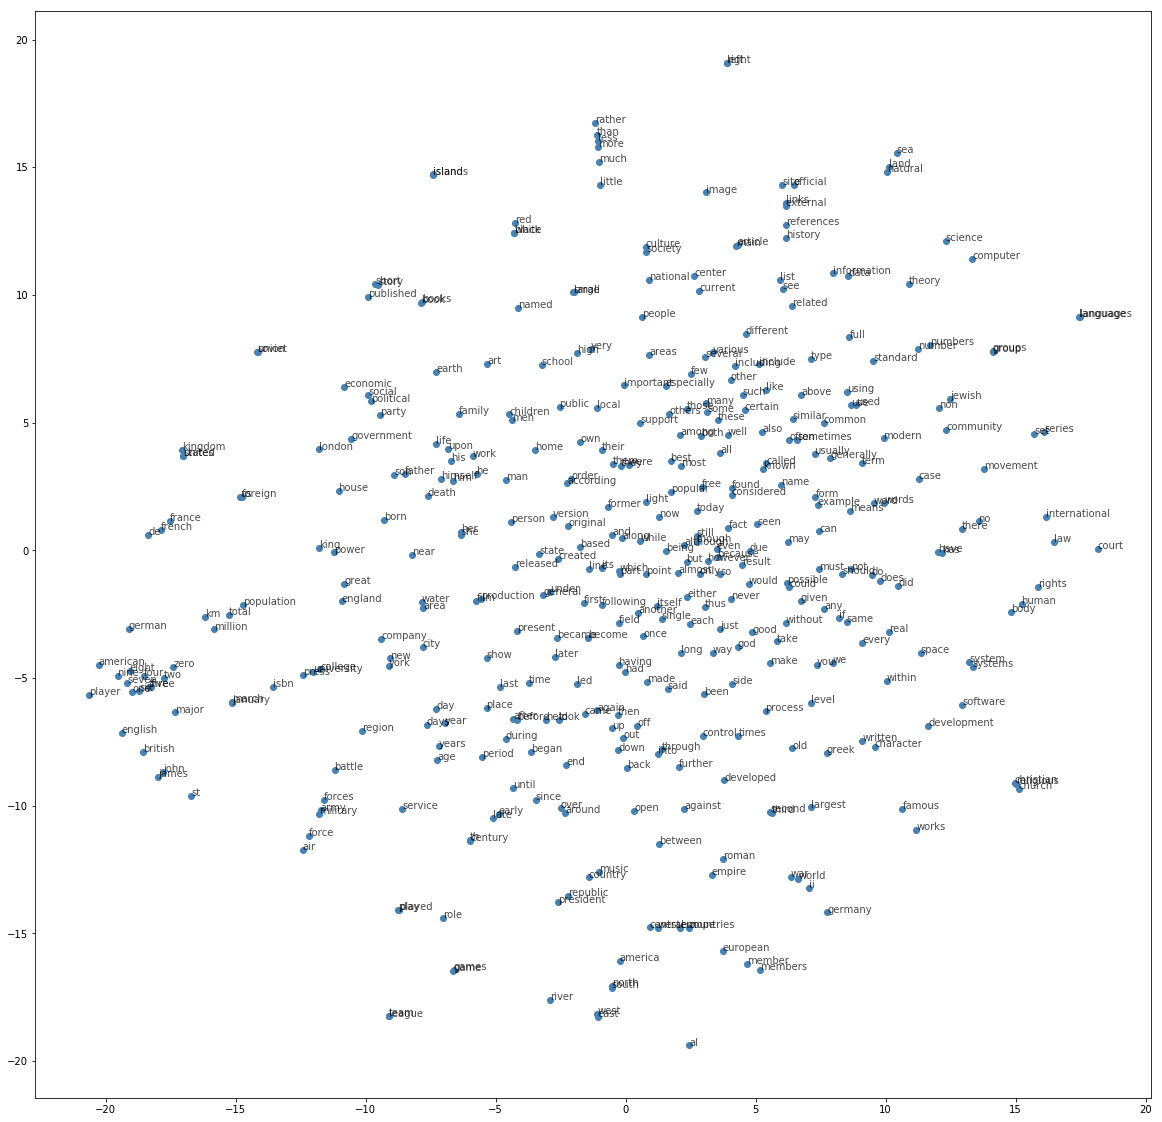

epoch: 6, avg. loss: 2.7202514236116953, gensim: 1197, accuracy: 9.757091620476036%


[116249]


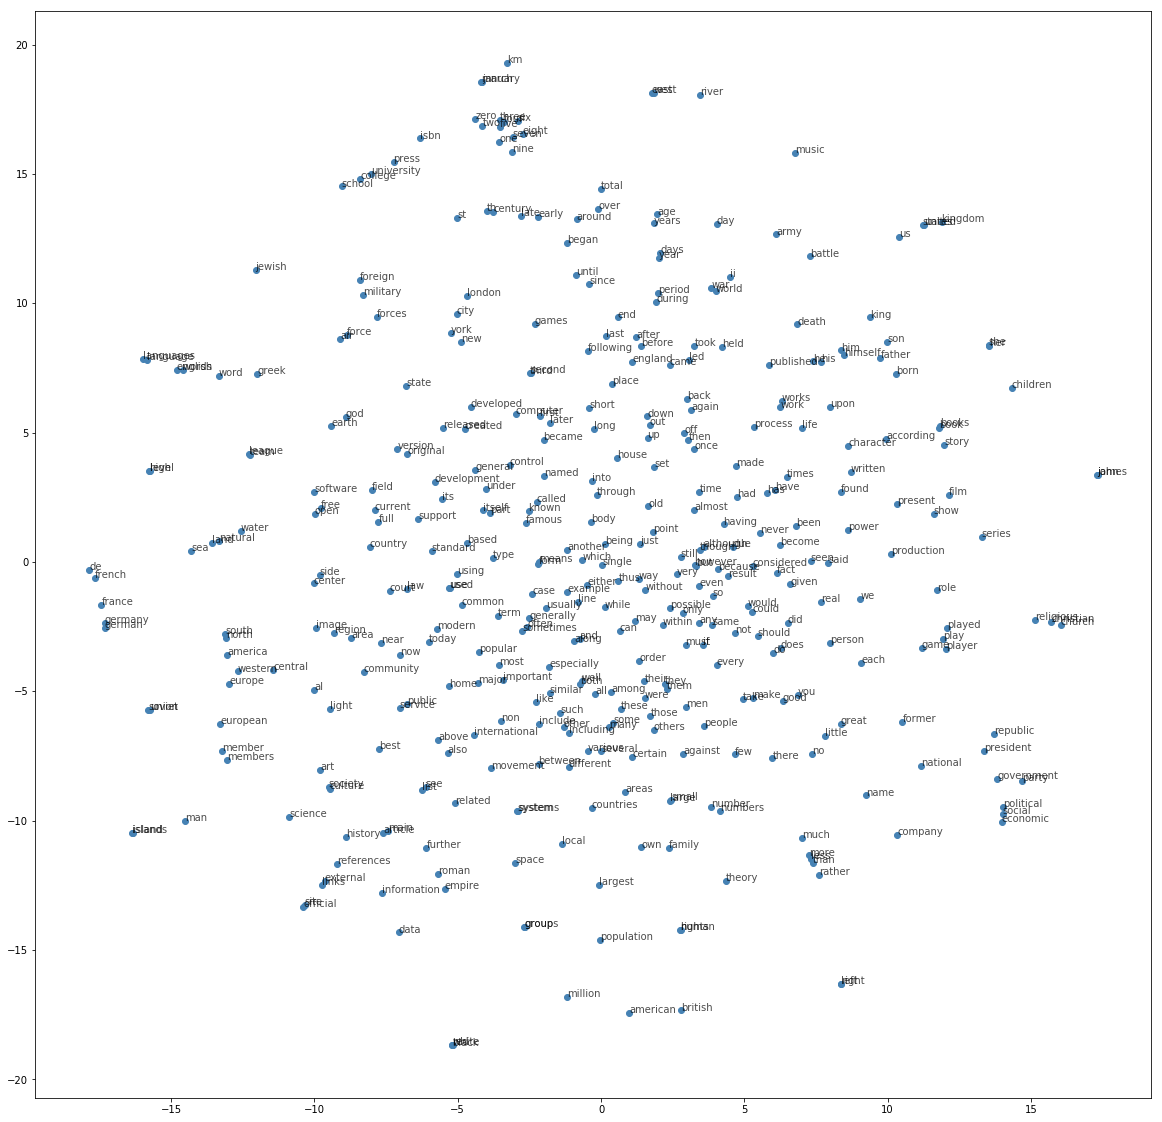

epoch: 7, avg. loss: 2.7020075351307566, gensim: 1442, accuracy: 11.754157156830779%


[132856]


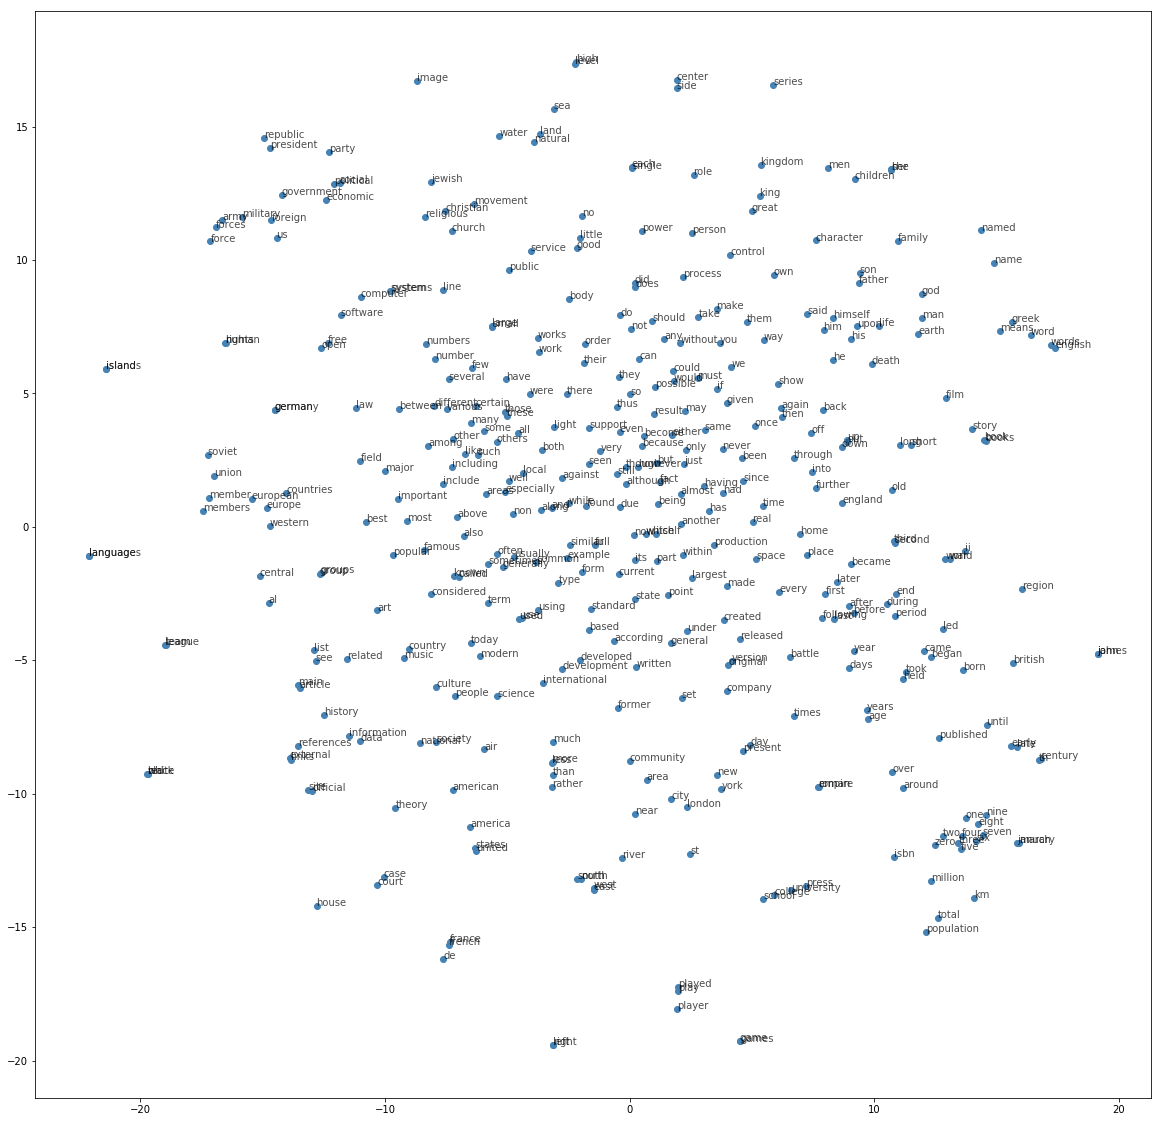

epoch: 8, avg. loss: 2.6825333682434755, gensim: 1585, accuracy: 12.919791327029671%


[149463]


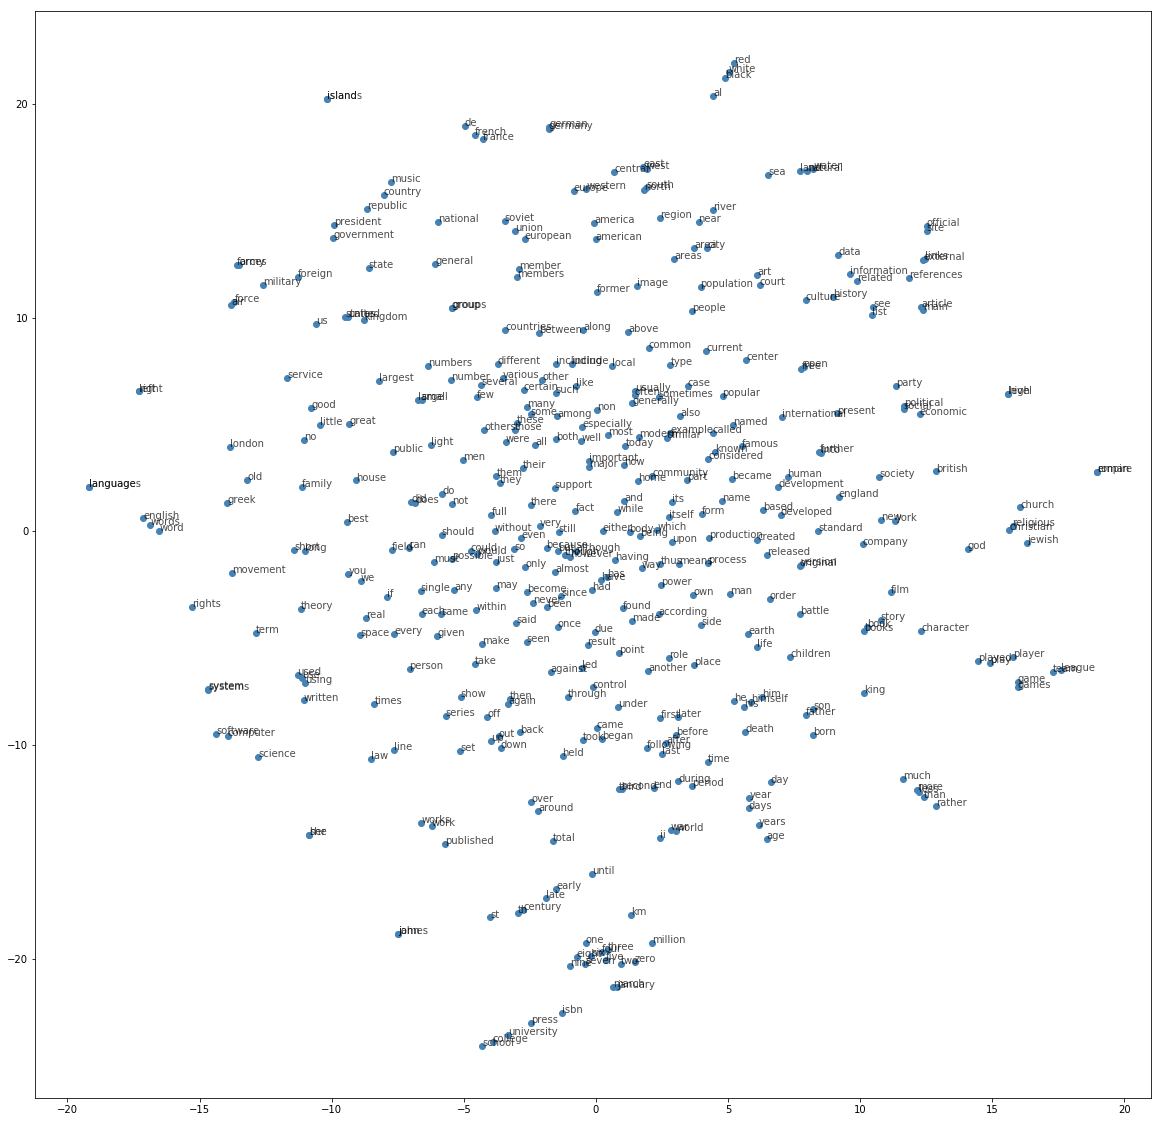

epoch: 9, avg. loss: 2.6805289156917422, gensim: 1827, accuracy: 14.892402999673948%


[166070]


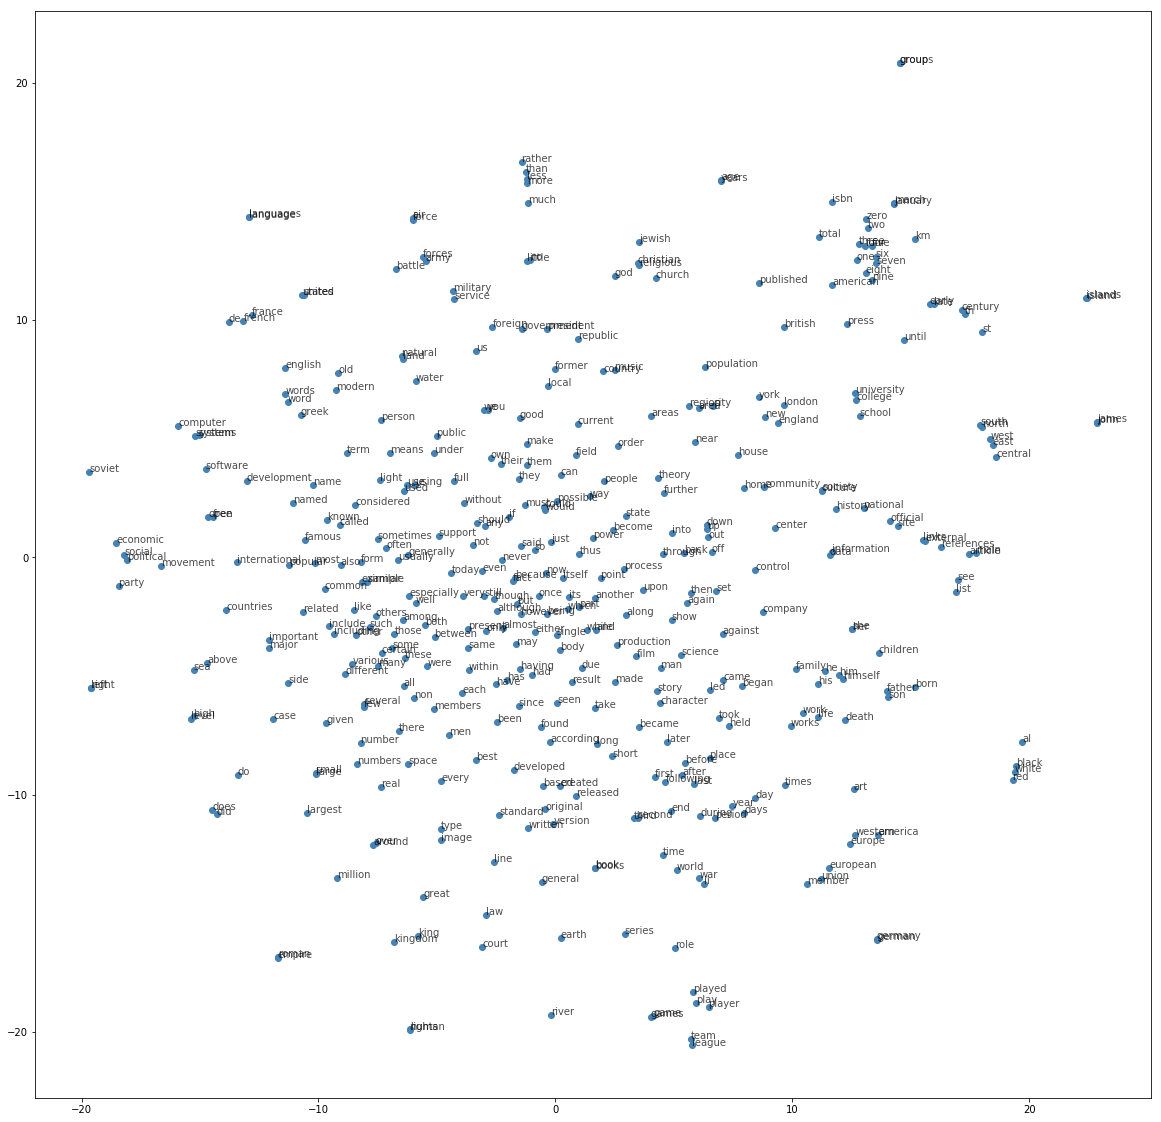

epoch: 10, avg. loss: 2.6690557197200526, gensim: 1817, accuracy: 14.81089012063906%


[182677]


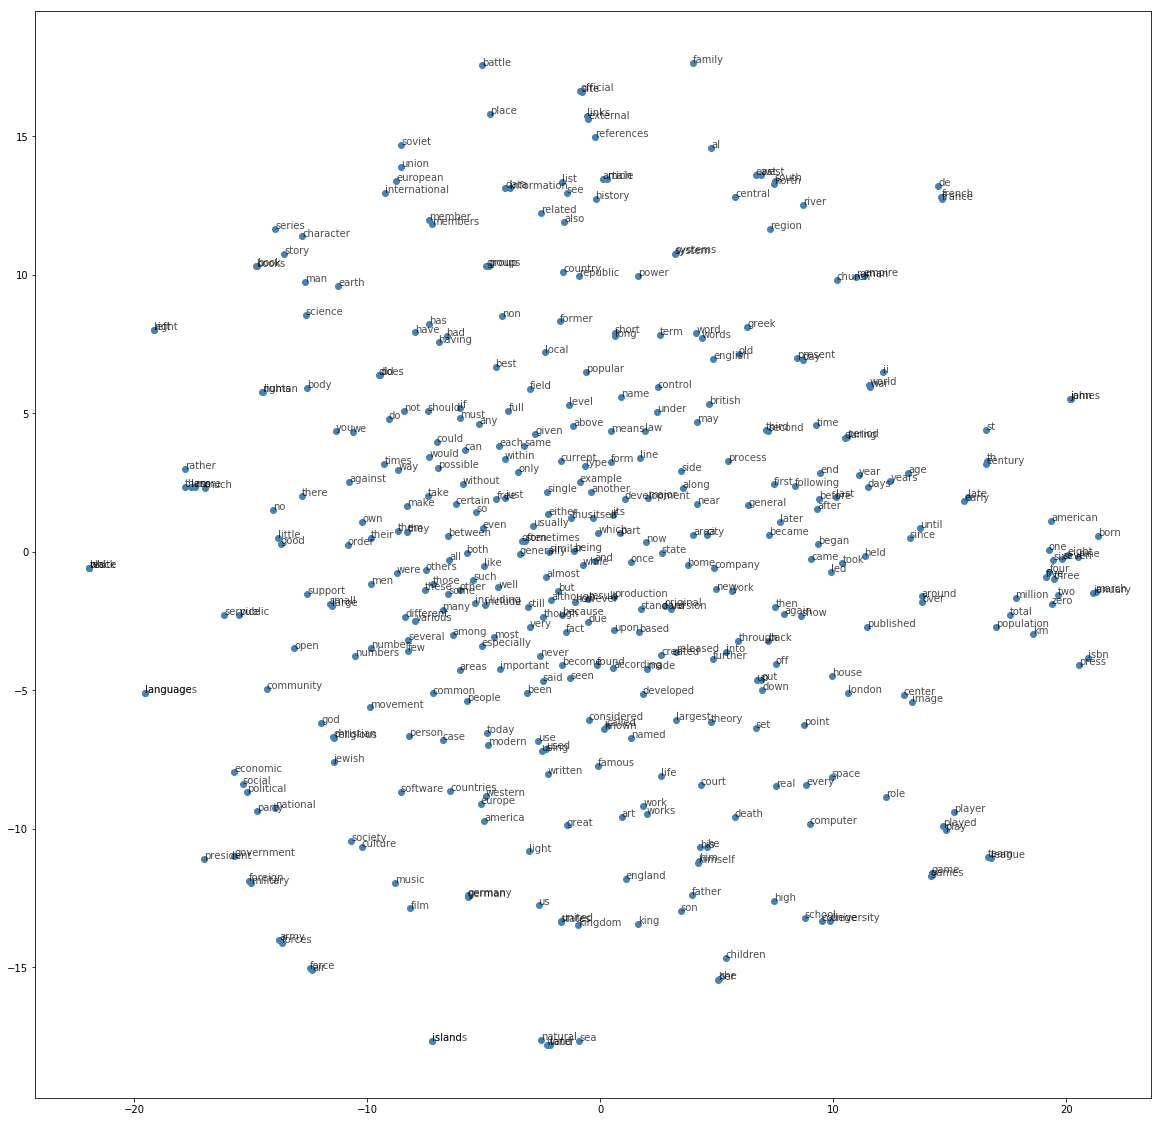

epoch: 11, avg. loss: 2.651512571707961, gensim: 1906, accuracy: 15.536354744049559%


[199284]


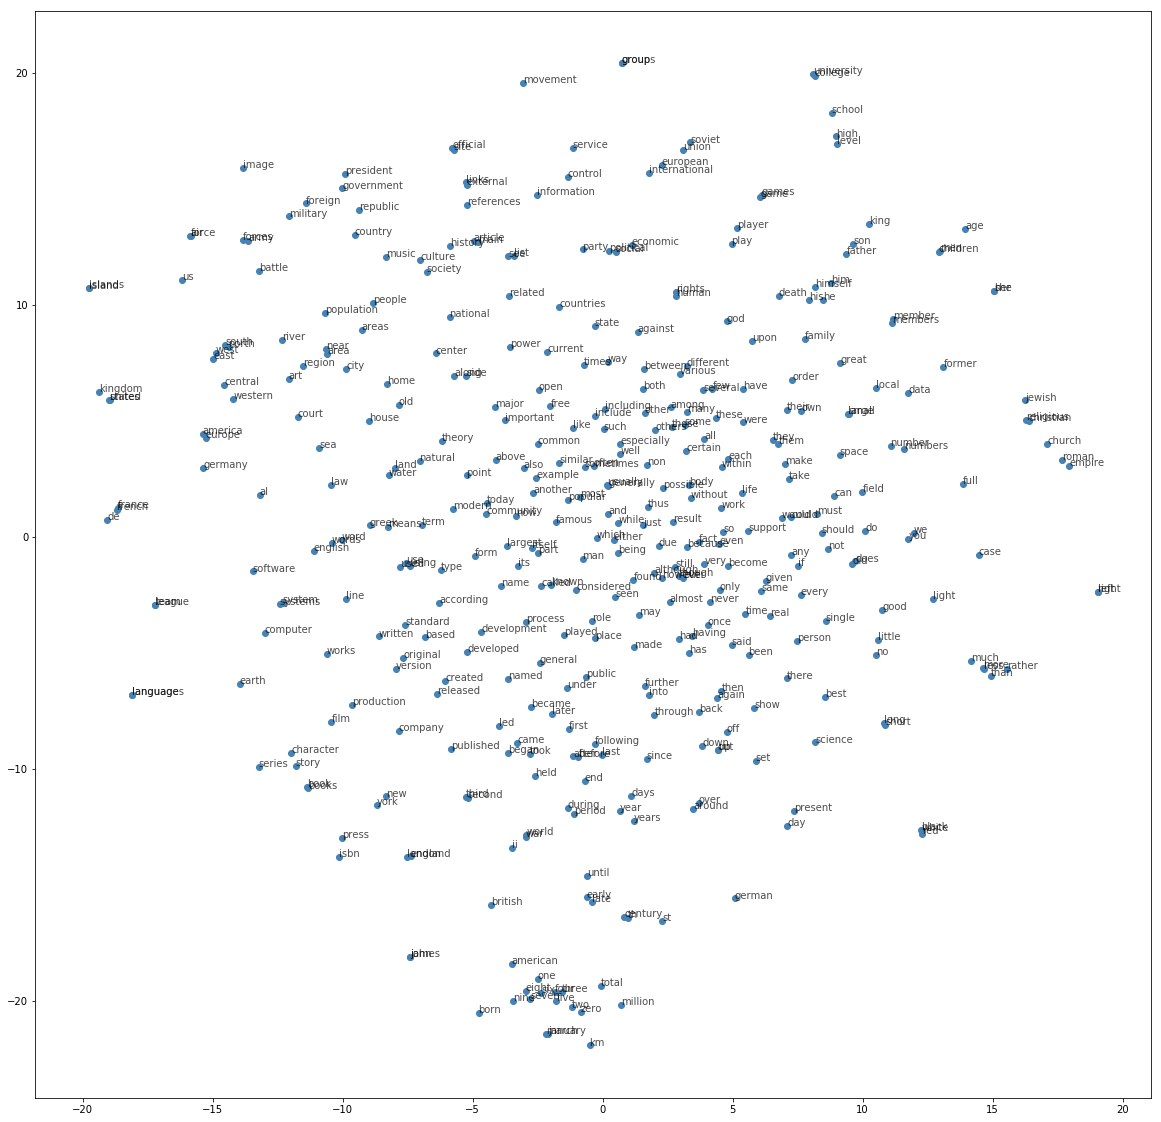

epoch: 12, avg. loss: 2.6422566548044277, gensim: 1939, accuracy: 15.805347244864688%


[215891]


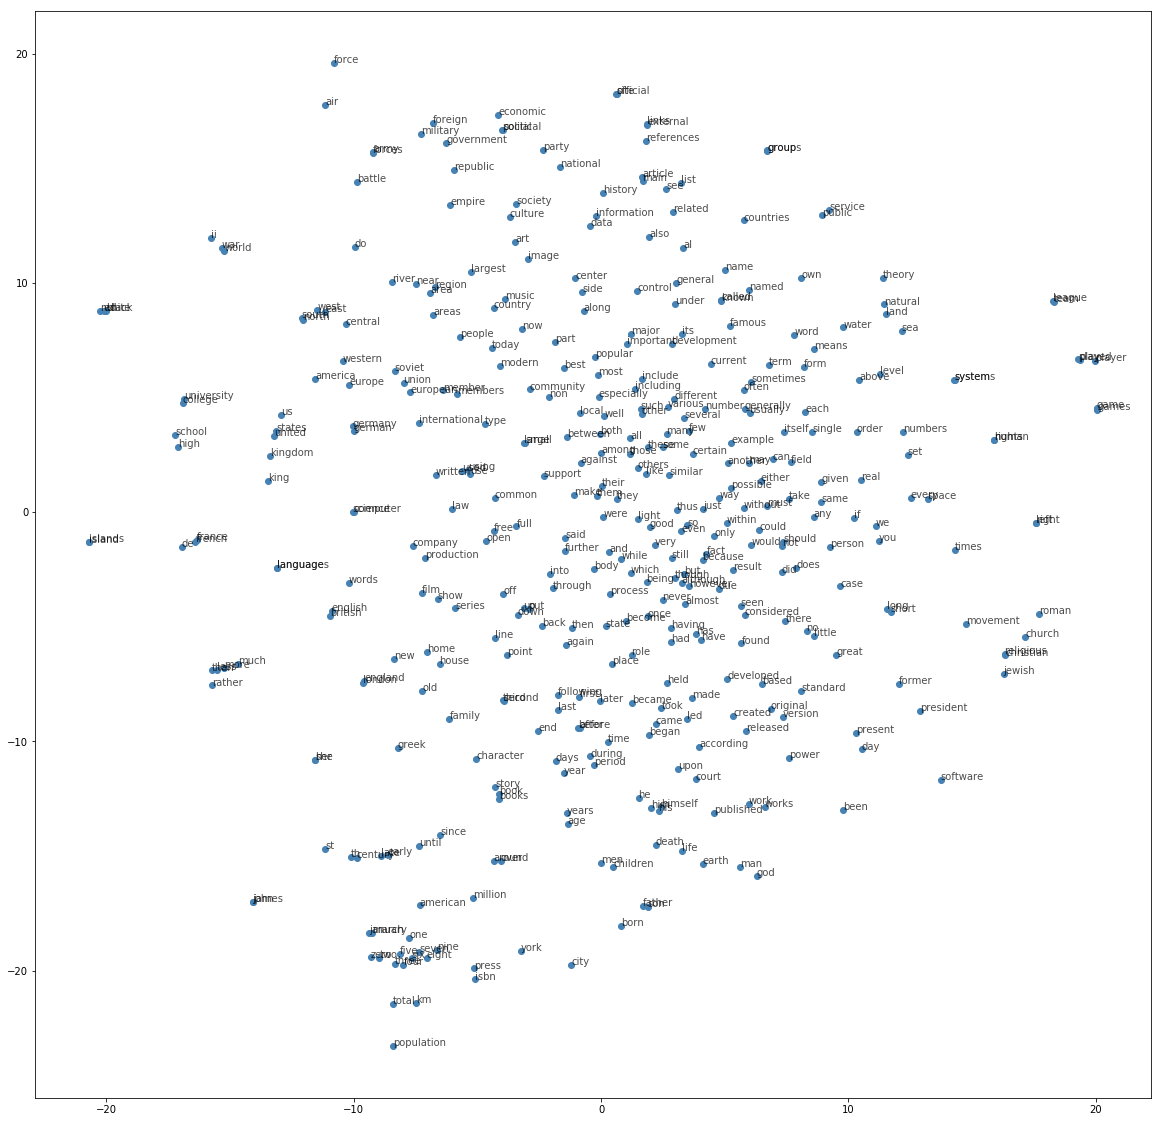

epoch: 13, avg. loss: 2.641241324037014, gensim: 1981, accuracy: 16.147701336811217%


[232498]


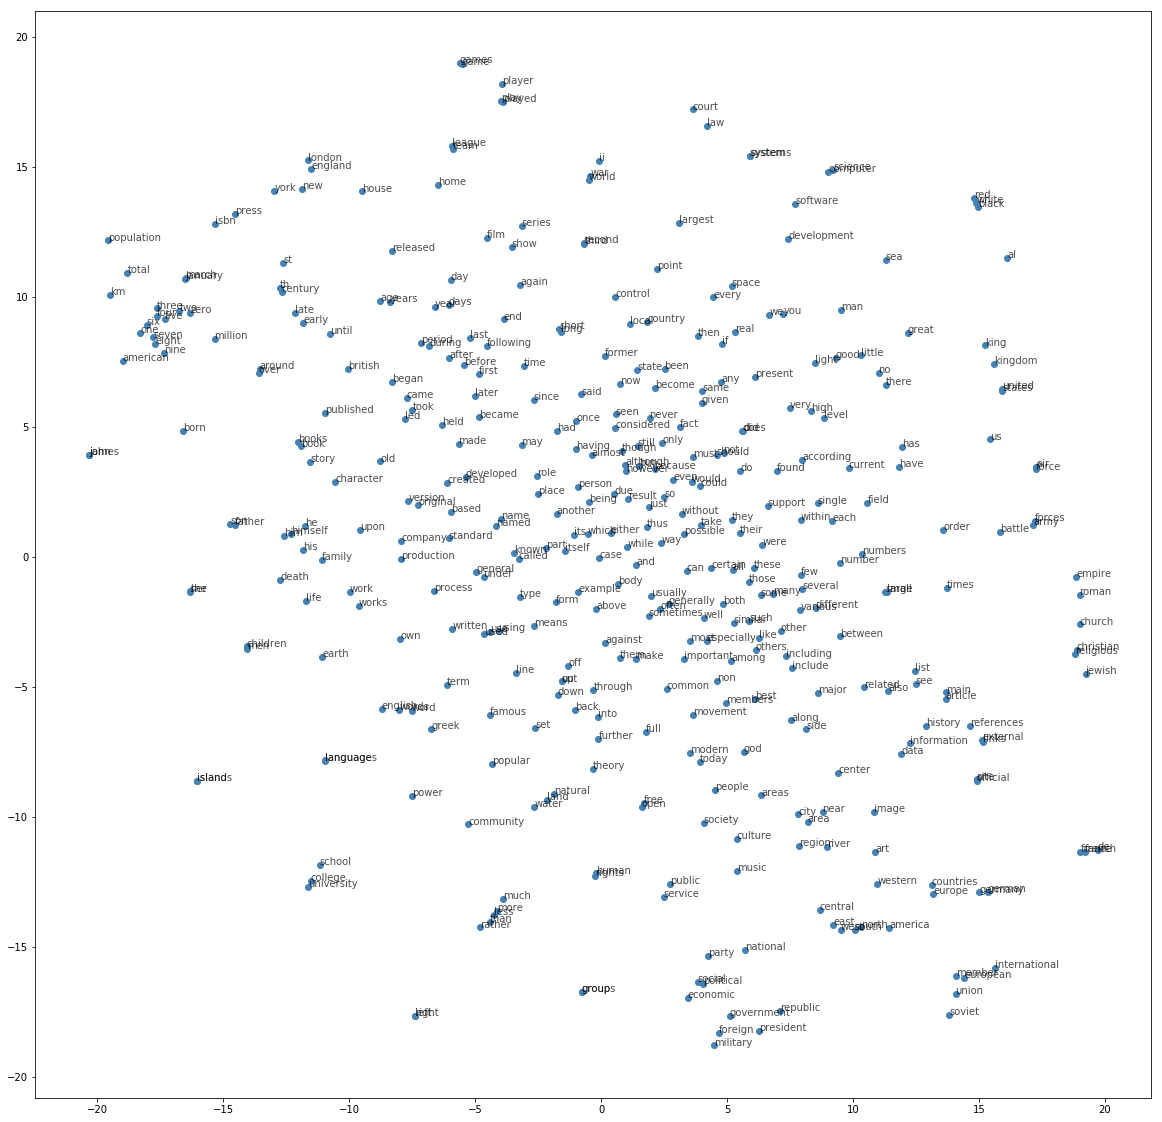

epoch: 14, avg. loss: 2.6329370090400555, gensim: 2164, accuracy: 17.63938702314966%


[249105]


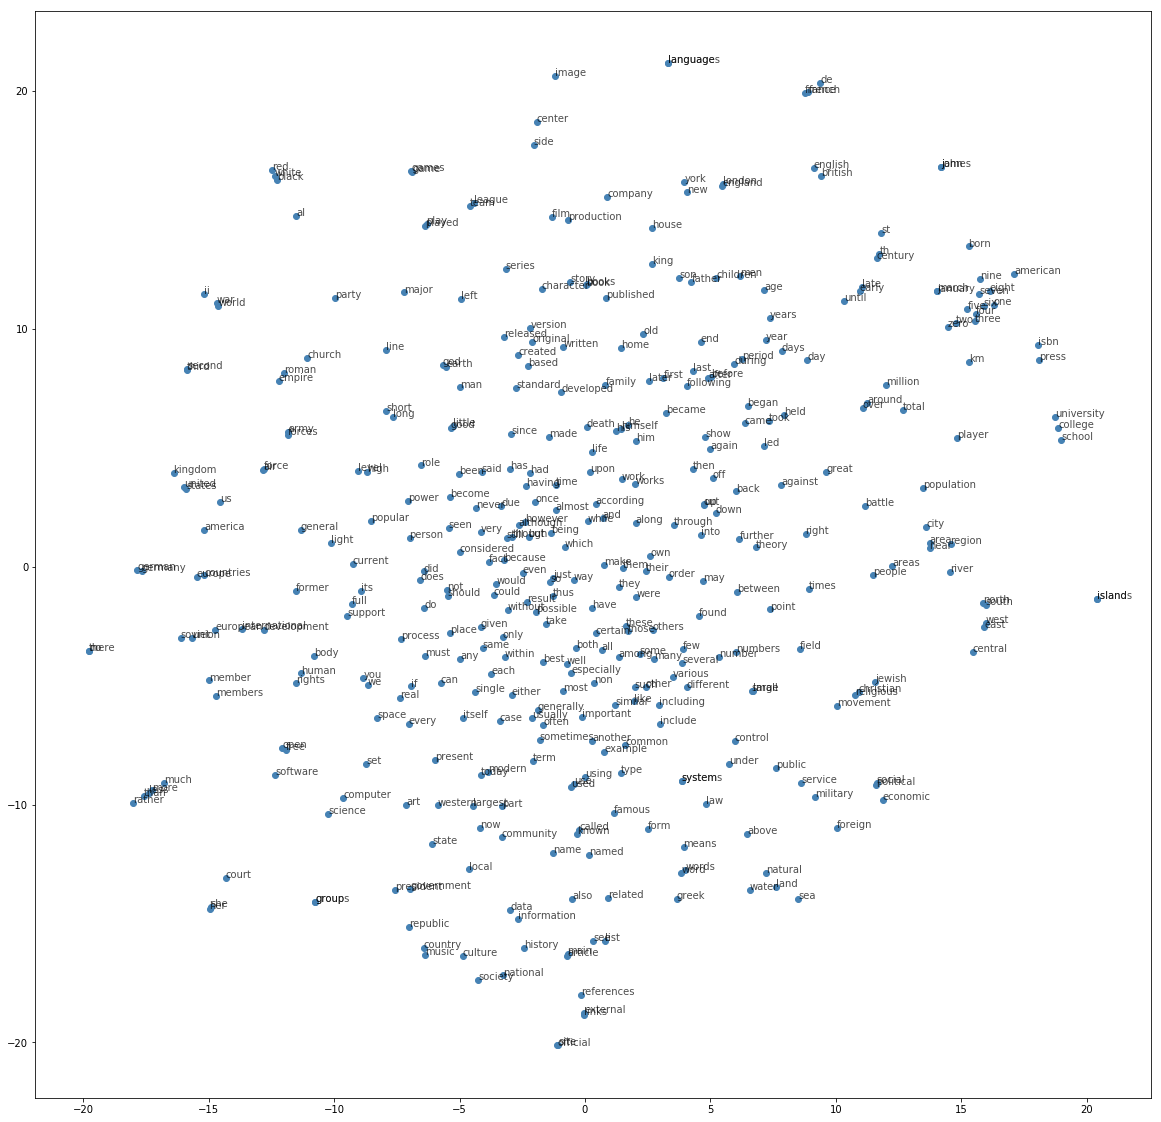

epoch: 15, avg. loss: 2.631259079069617, gensim: 2092, accuracy: 17.052494294098466%


[265712]


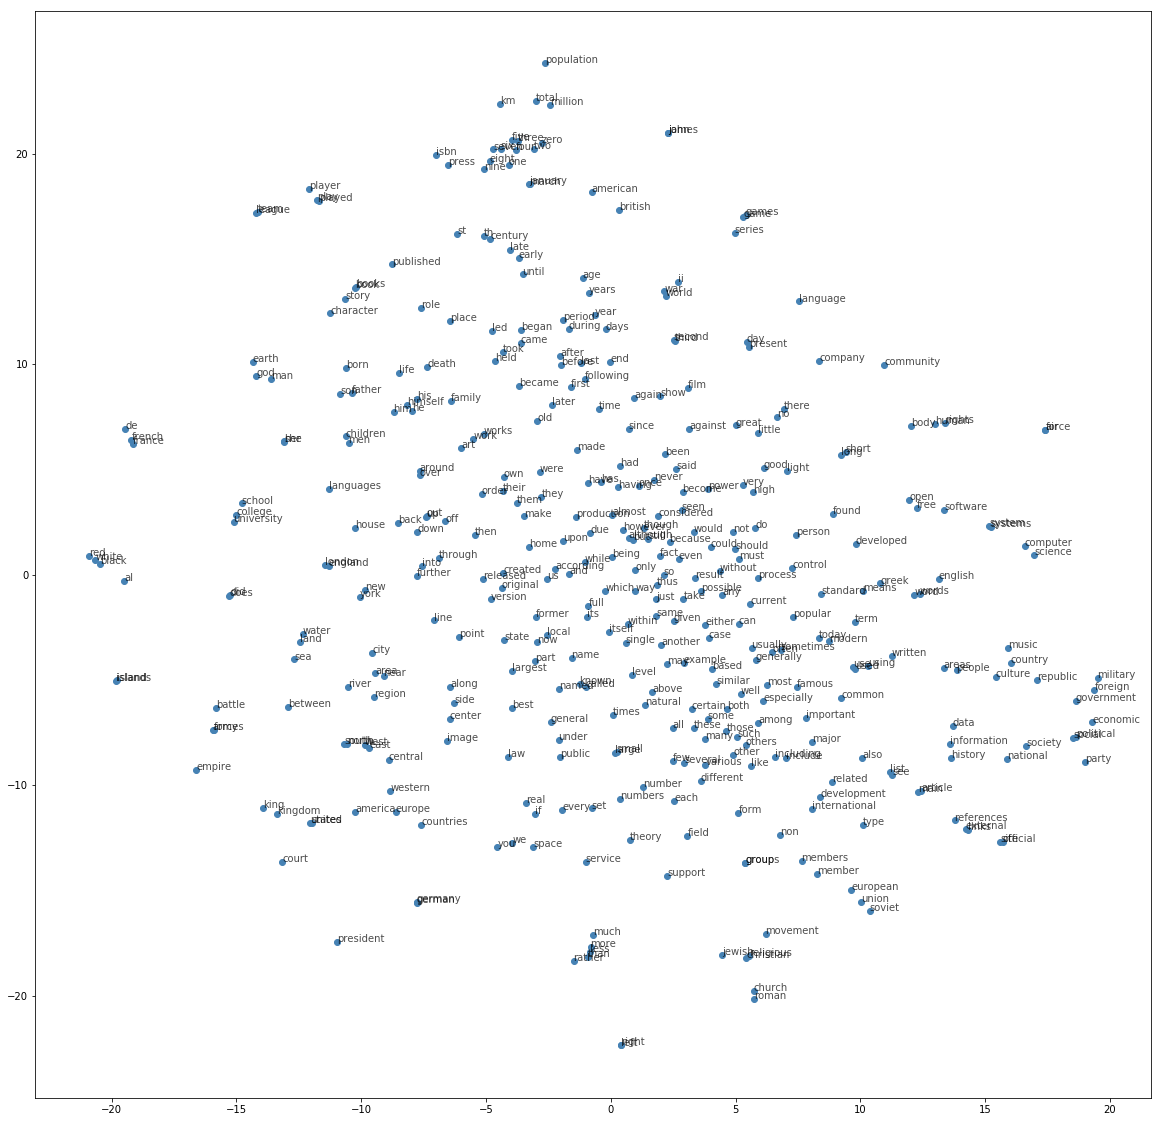

epoch: 16, avg. loss: 2.6211852603602357, gensim: 2172, accuracy: 17.704597326377566%


[282319]


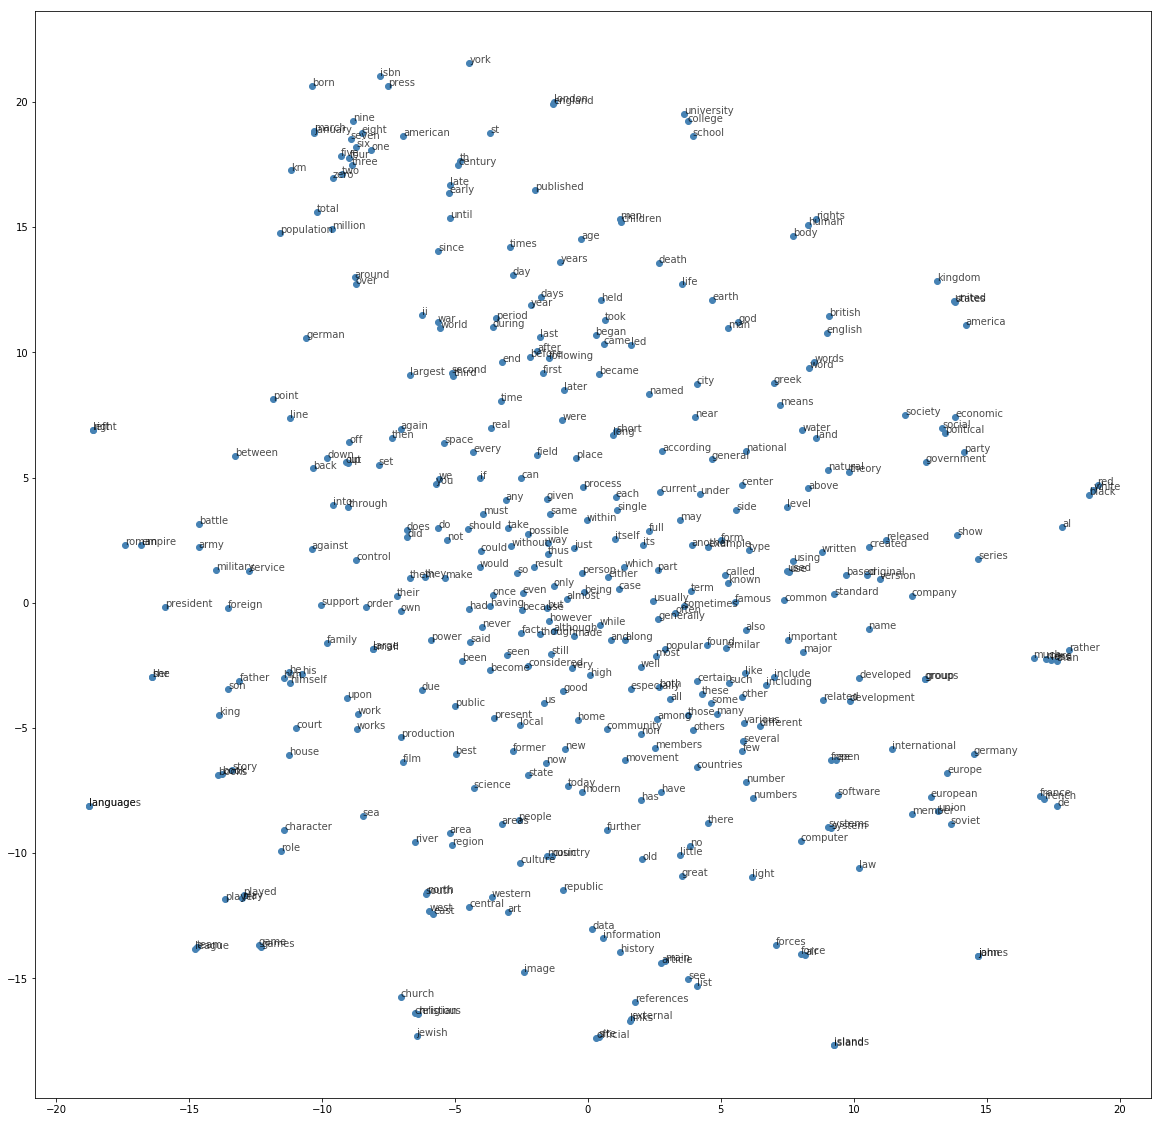

epoch: 17, avg. loss: 2.6163251820131506, gensim: 2172, accuracy: 17.704597326377566%


[298926]


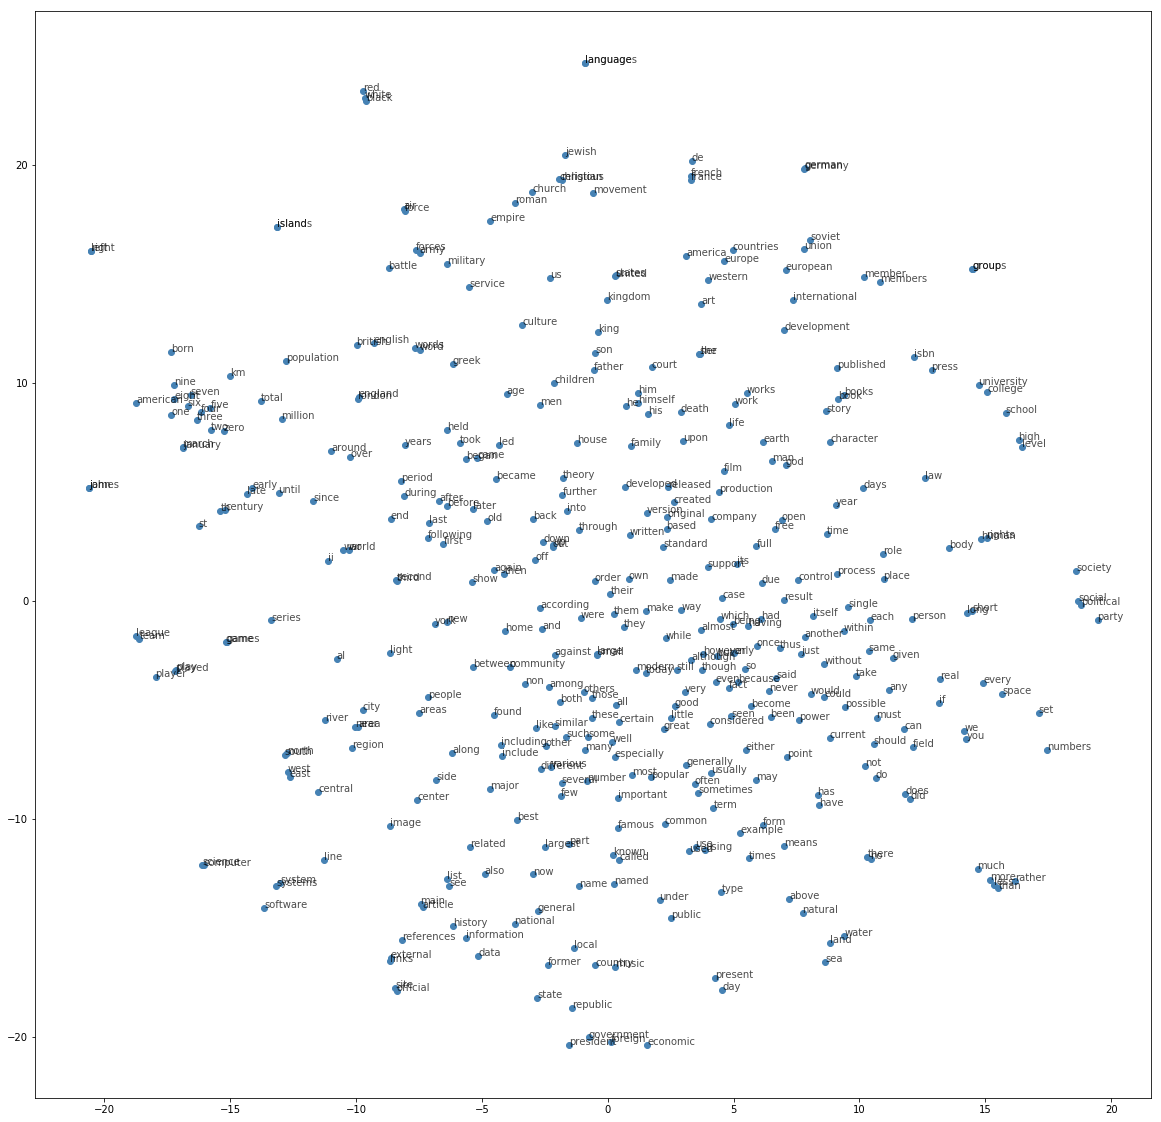

epoch: 18, avg. loss: 2.609432332975138, gensim: 2196, accuracy: 17.9002282360613%


[315533]


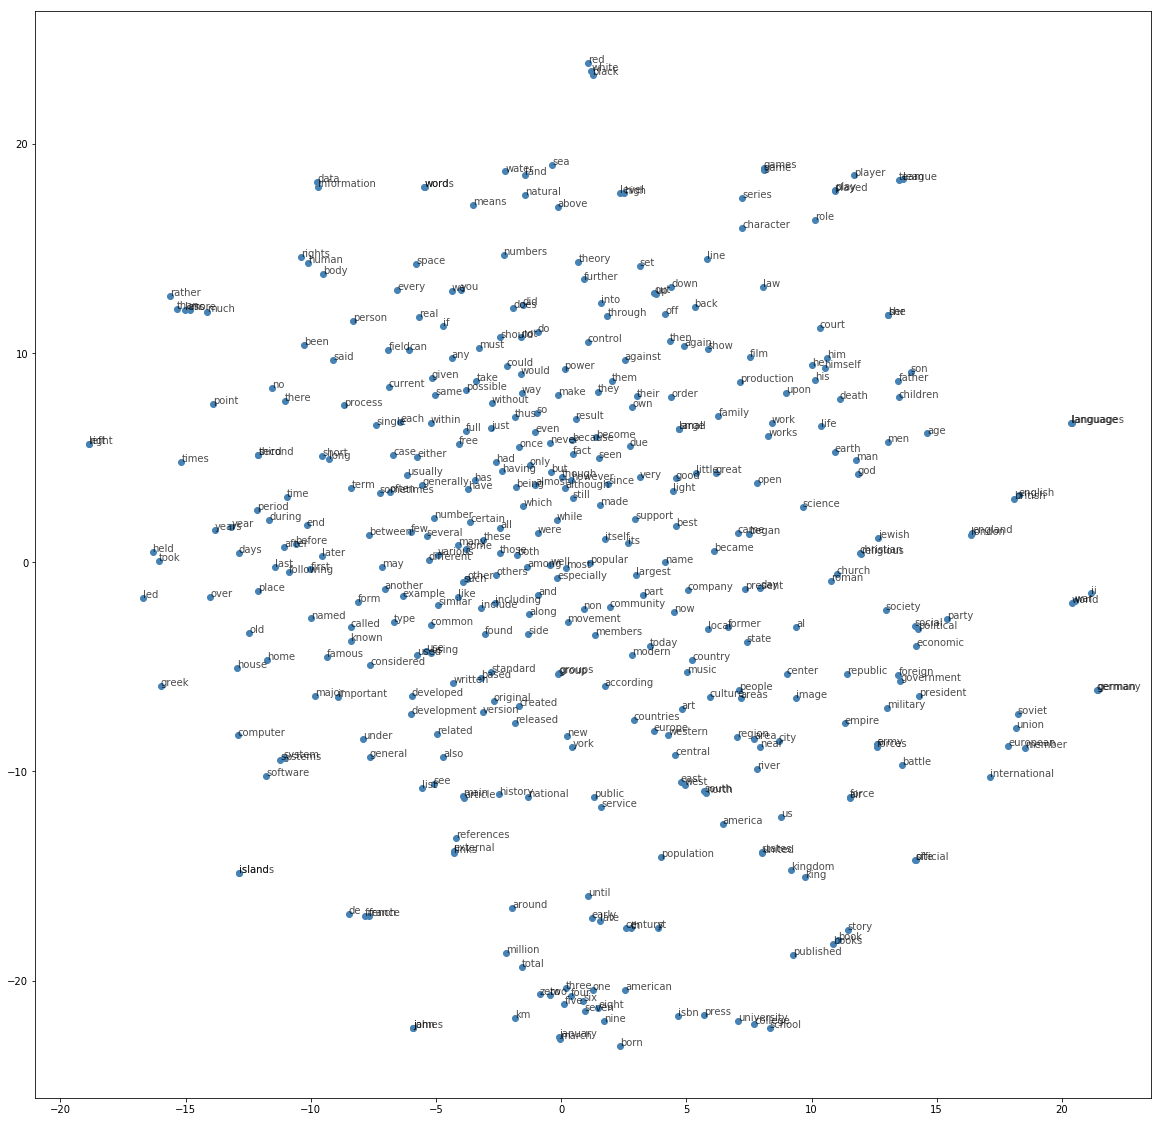

epoch: 19, avg. loss: 2.6061675098995605, gensim: 2278, accuracy: 18.568633844147374%


[332140]


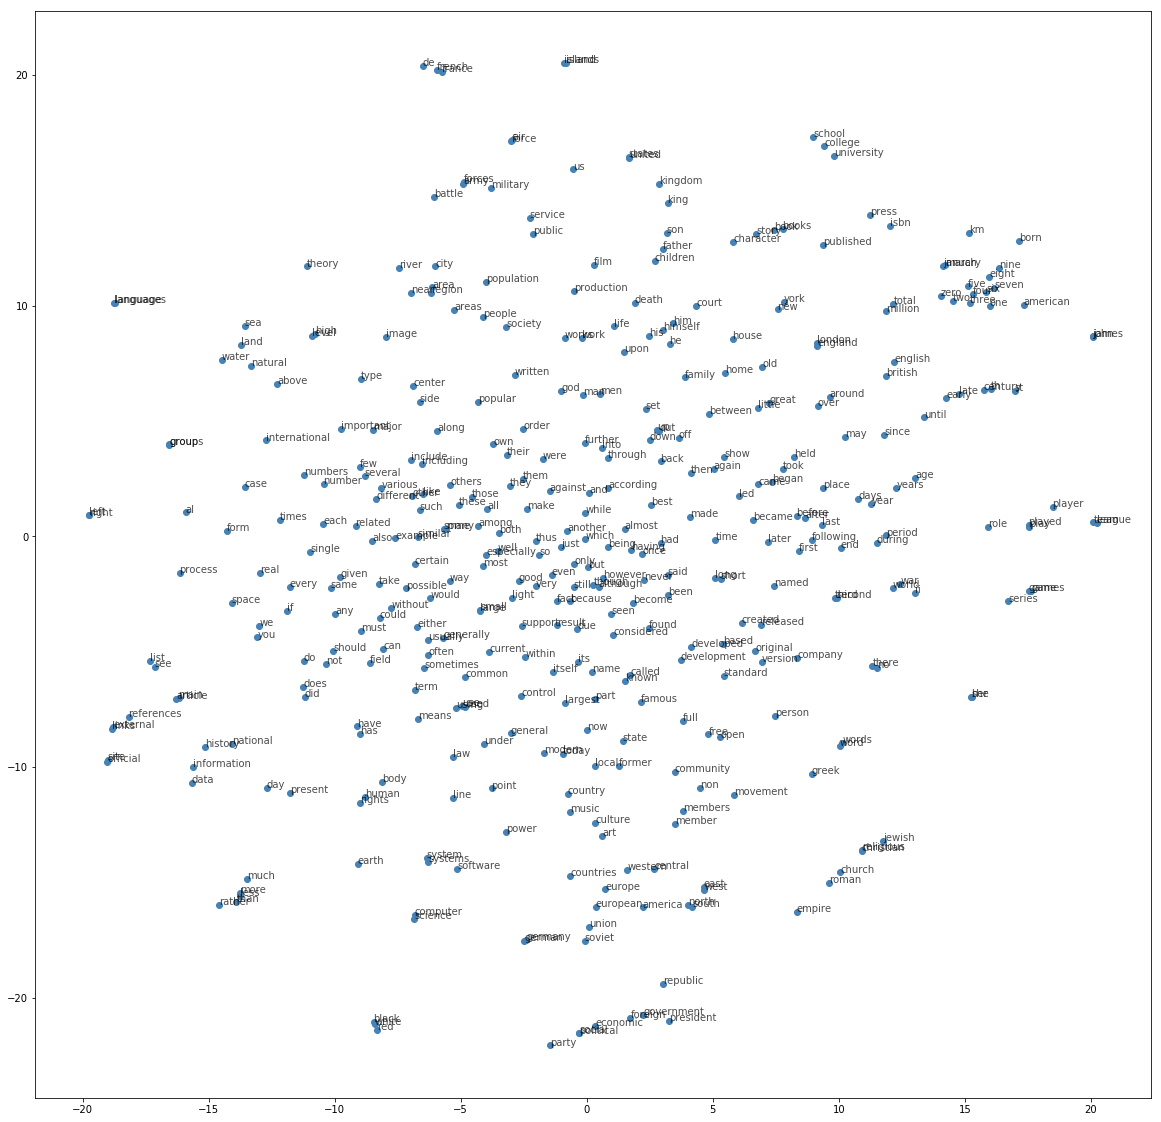

epoch: 20, avg. loss: 2.615921798392351, gensim: 2277, accuracy: 18.560482556243887%


[348747]


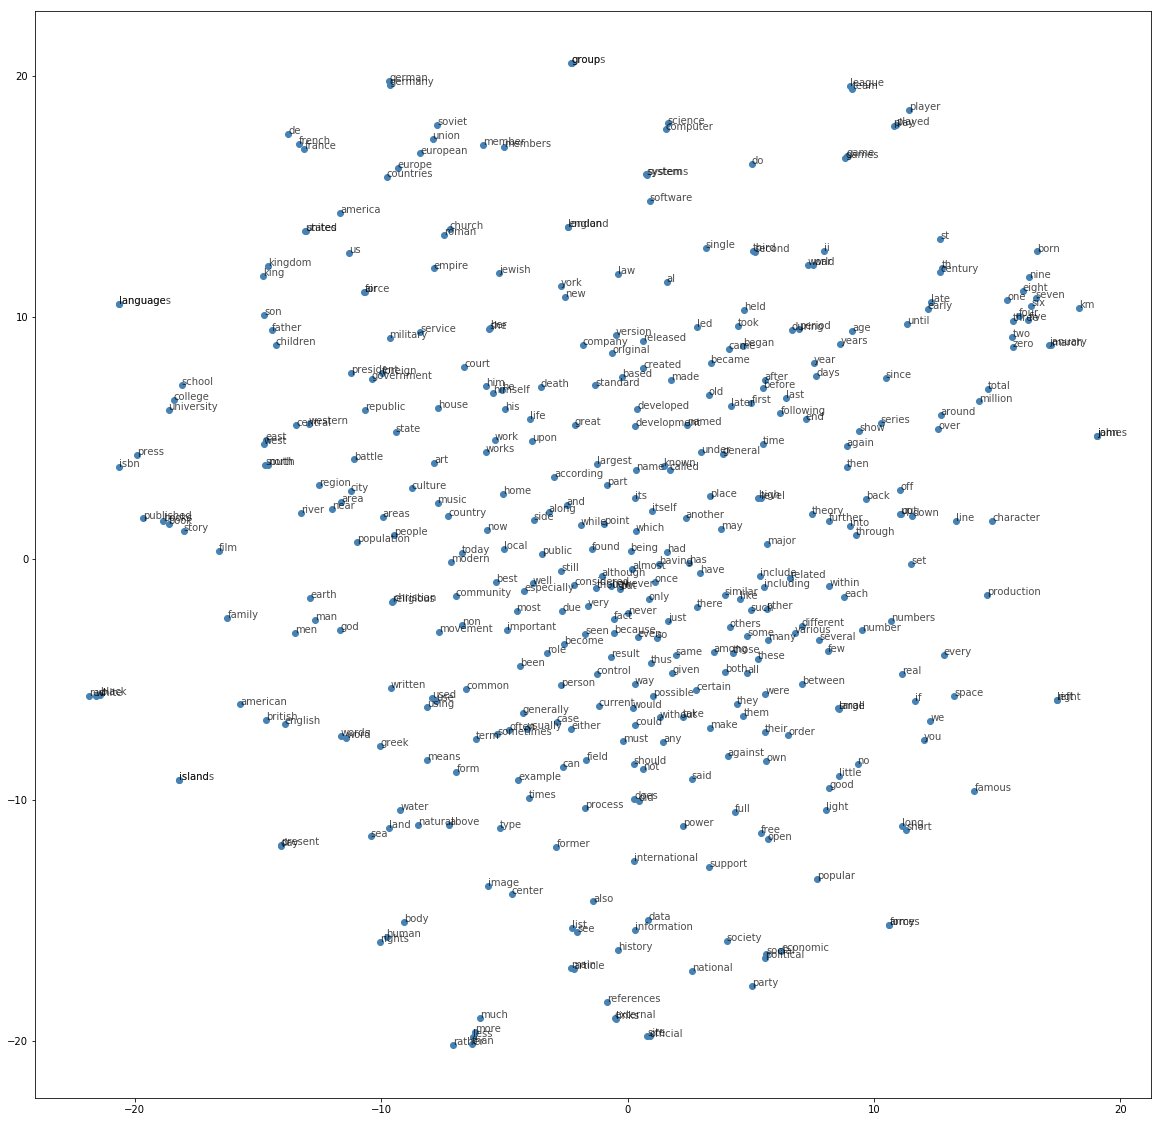

epoch: 21, avg. loss: 2.6040324517150024, gensim: 2293, accuracy: 18.690903162699705%


[365354]


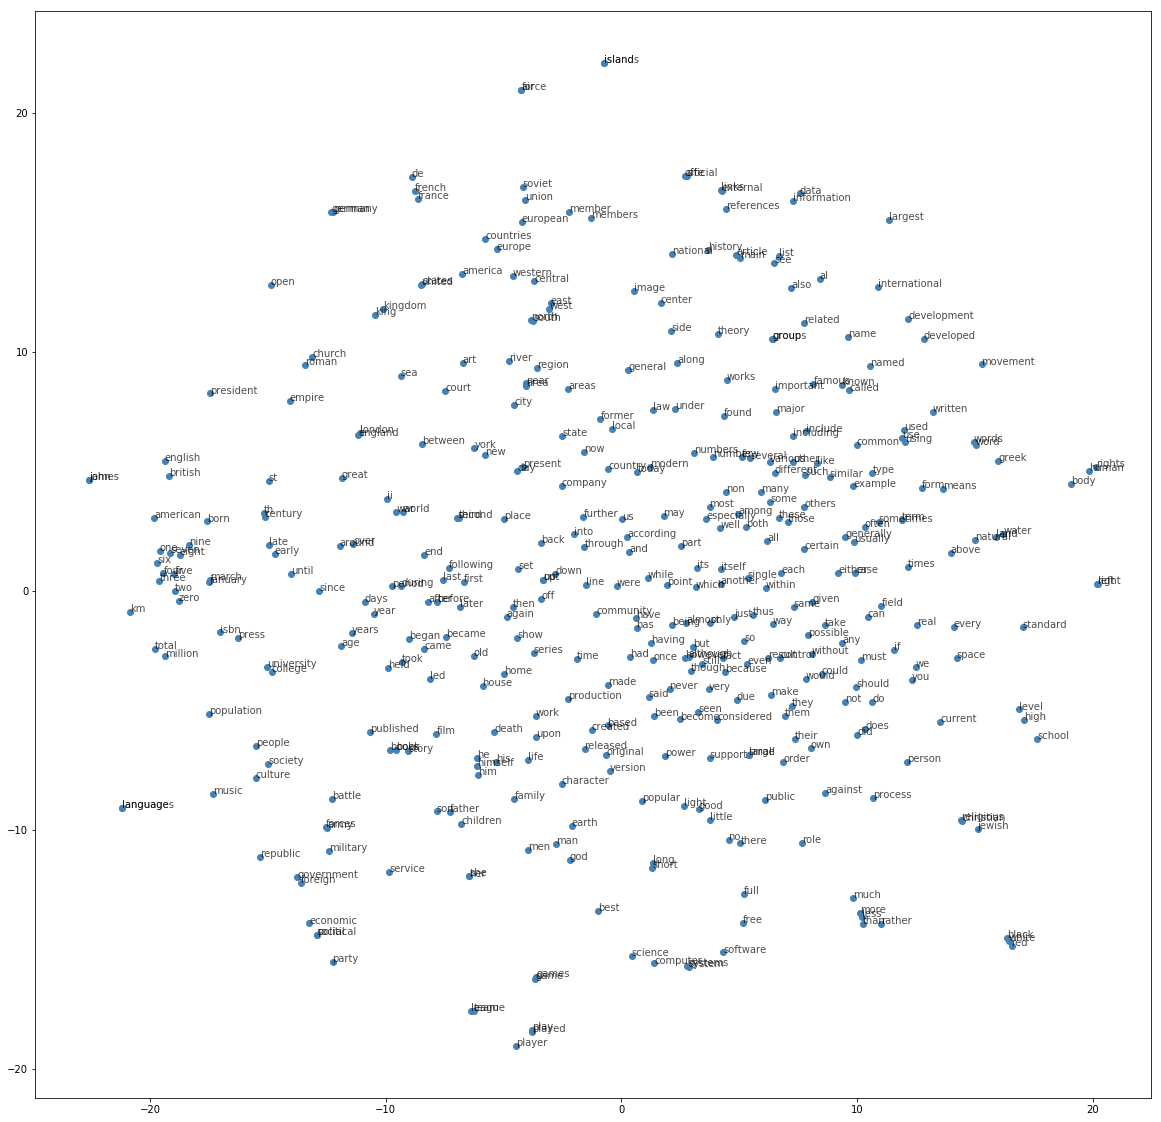

epoch: 22, avg. loss: 2.602339862406365, gensim: 2318, accuracy: 18.894685360286925%


[381961]


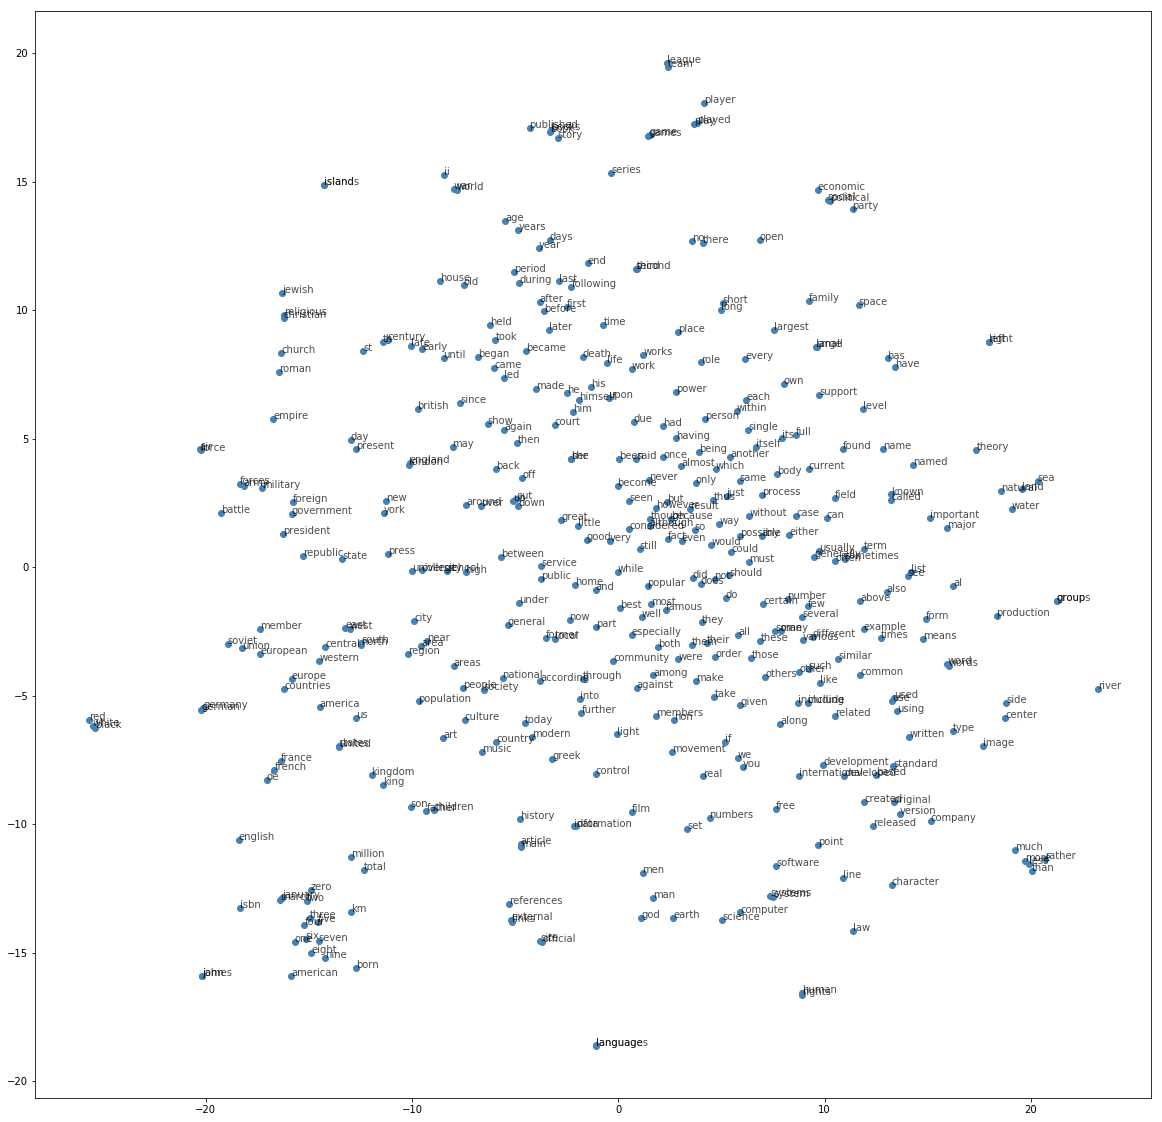

epoch: 23, avg. loss: 2.6046754186698435, gensim: 2296, accuracy: 18.715357026410175%


[398568]


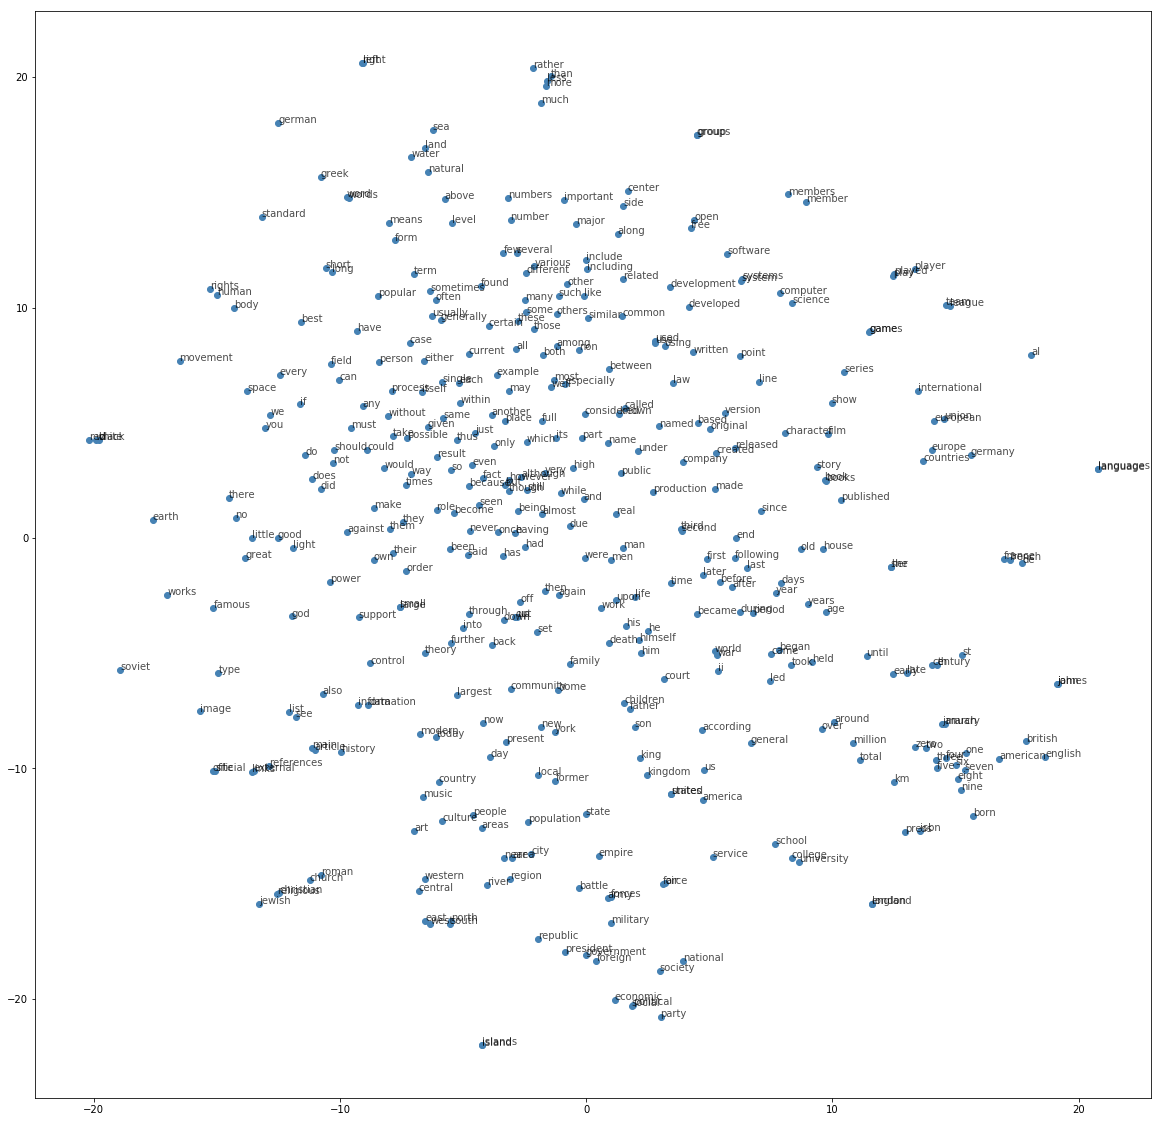

epoch: 24, avg. loss: 2.6020496863992895, gensim: 2344, accuracy: 19.106618845777632%


[415175]


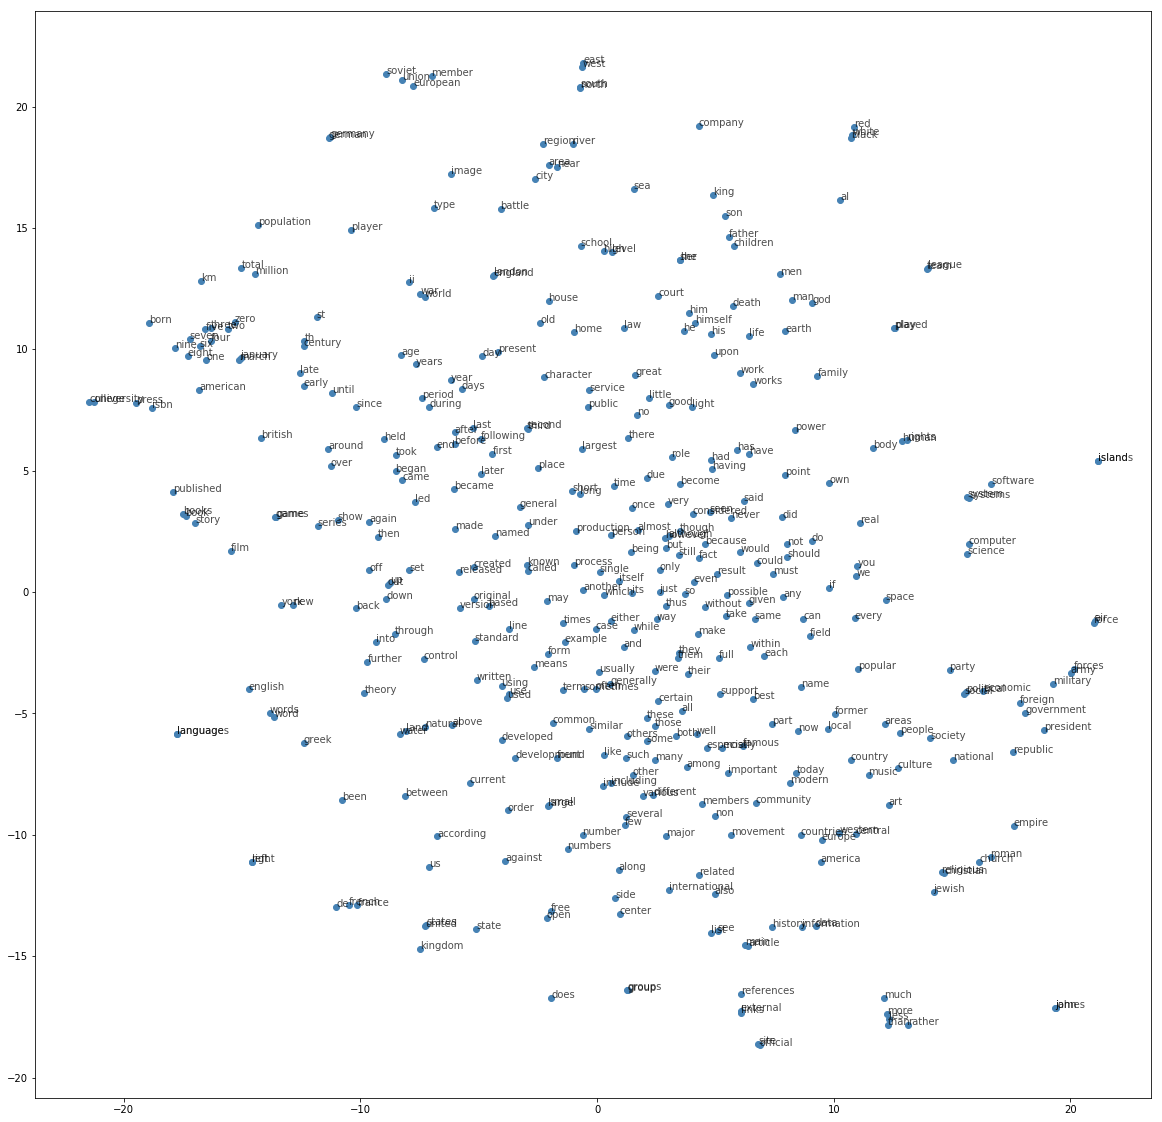

epoch: 25, avg. loss: 2.5996515126396087, gensim: 2362, accuracy: 19.253342028040432%


[431782]


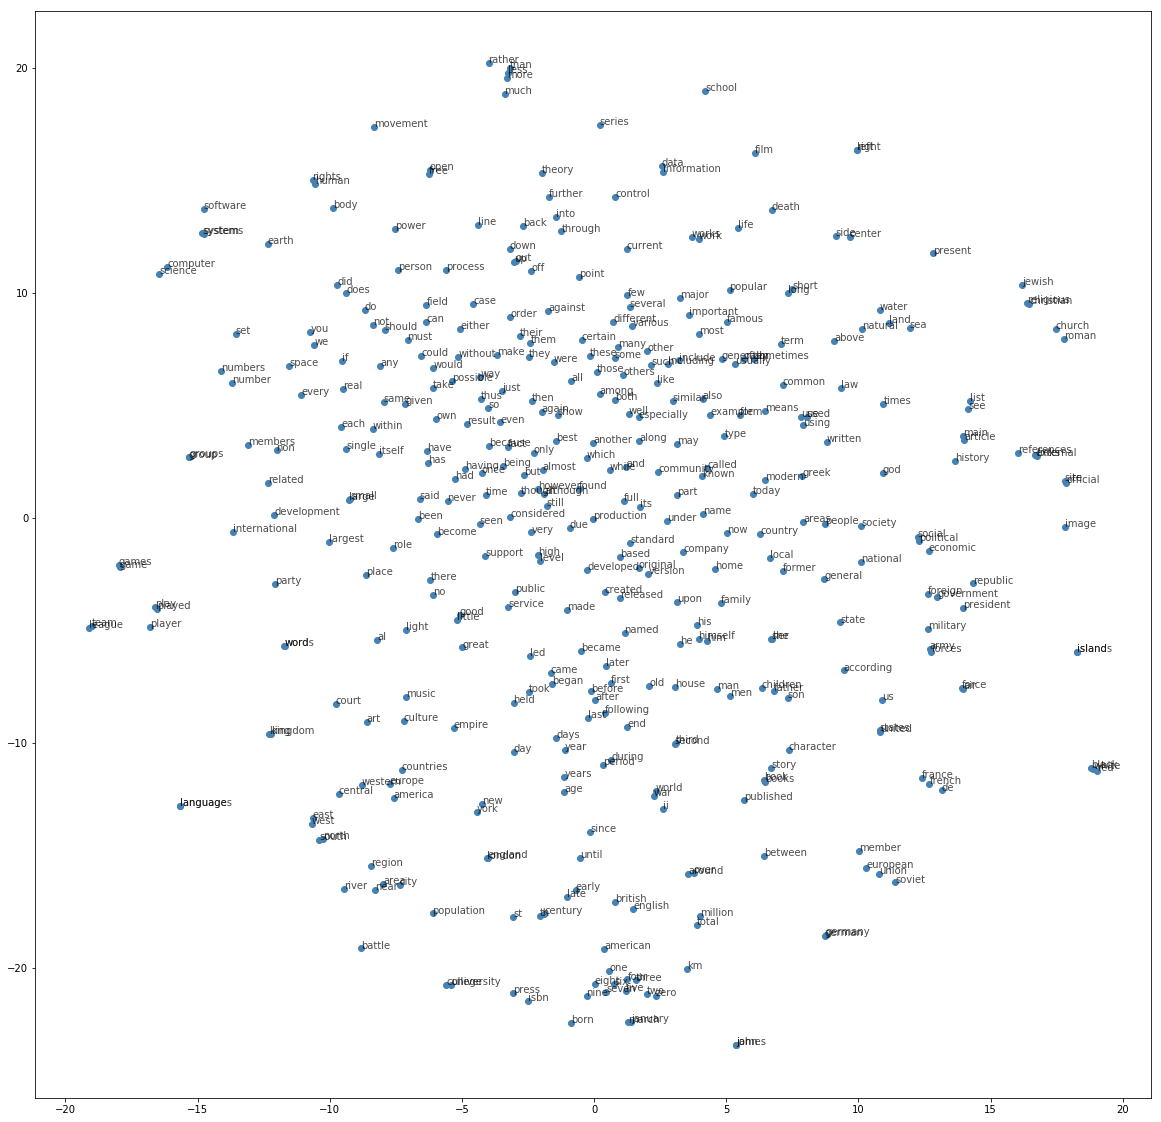

epoch: 26, avg. loss: 2.5956228169502347, gensim: 2362, accuracy: 19.253342028040432%


[448389]


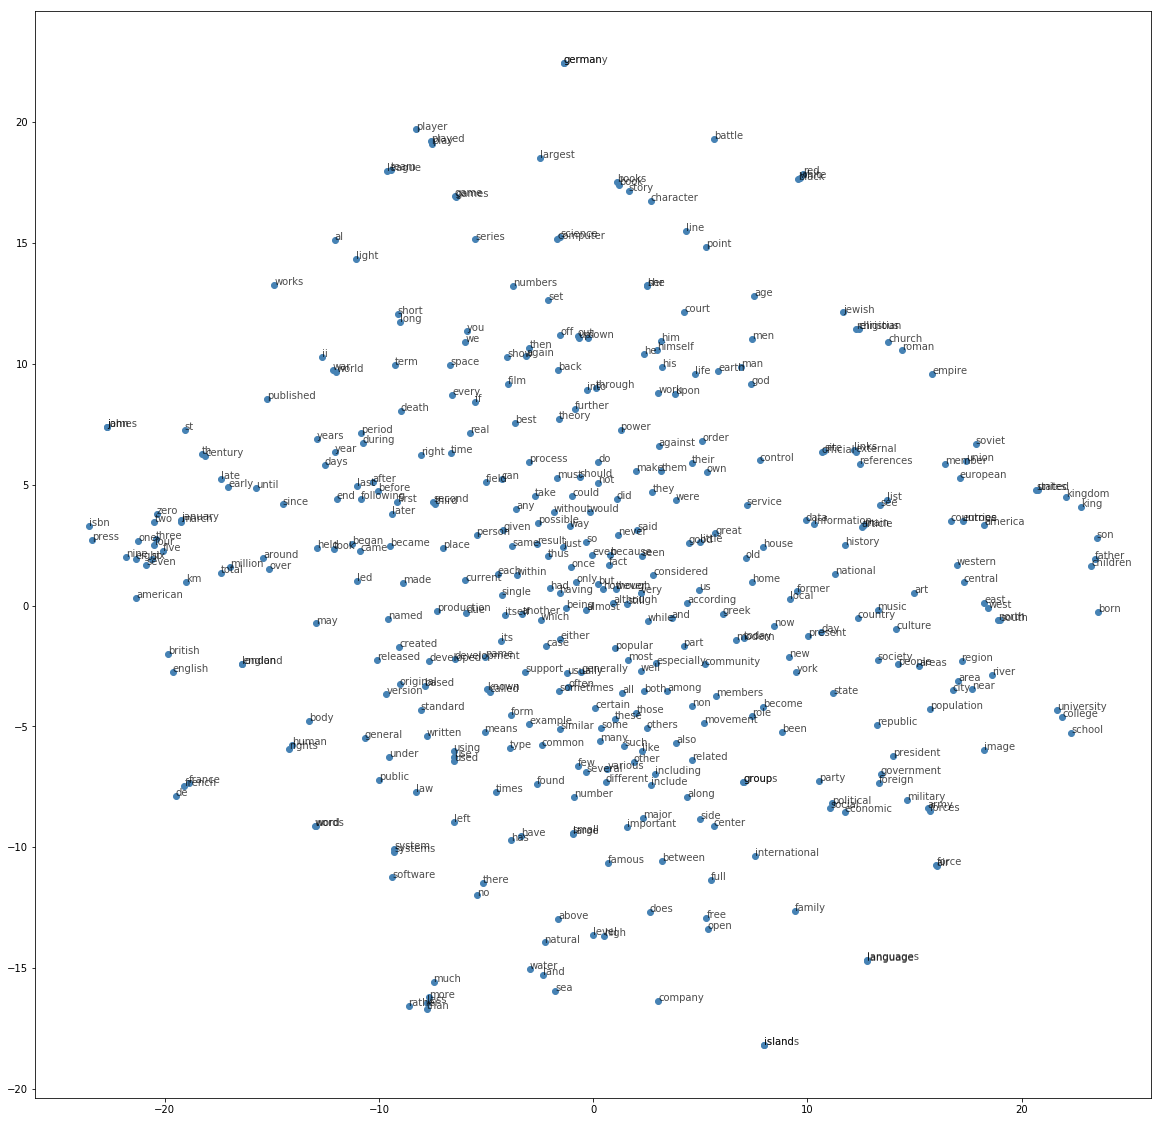

epoch: 27, avg. loss: 2.6032075521426976, gensim: 2368, accuracy: 19.302249755461364%


[464996]


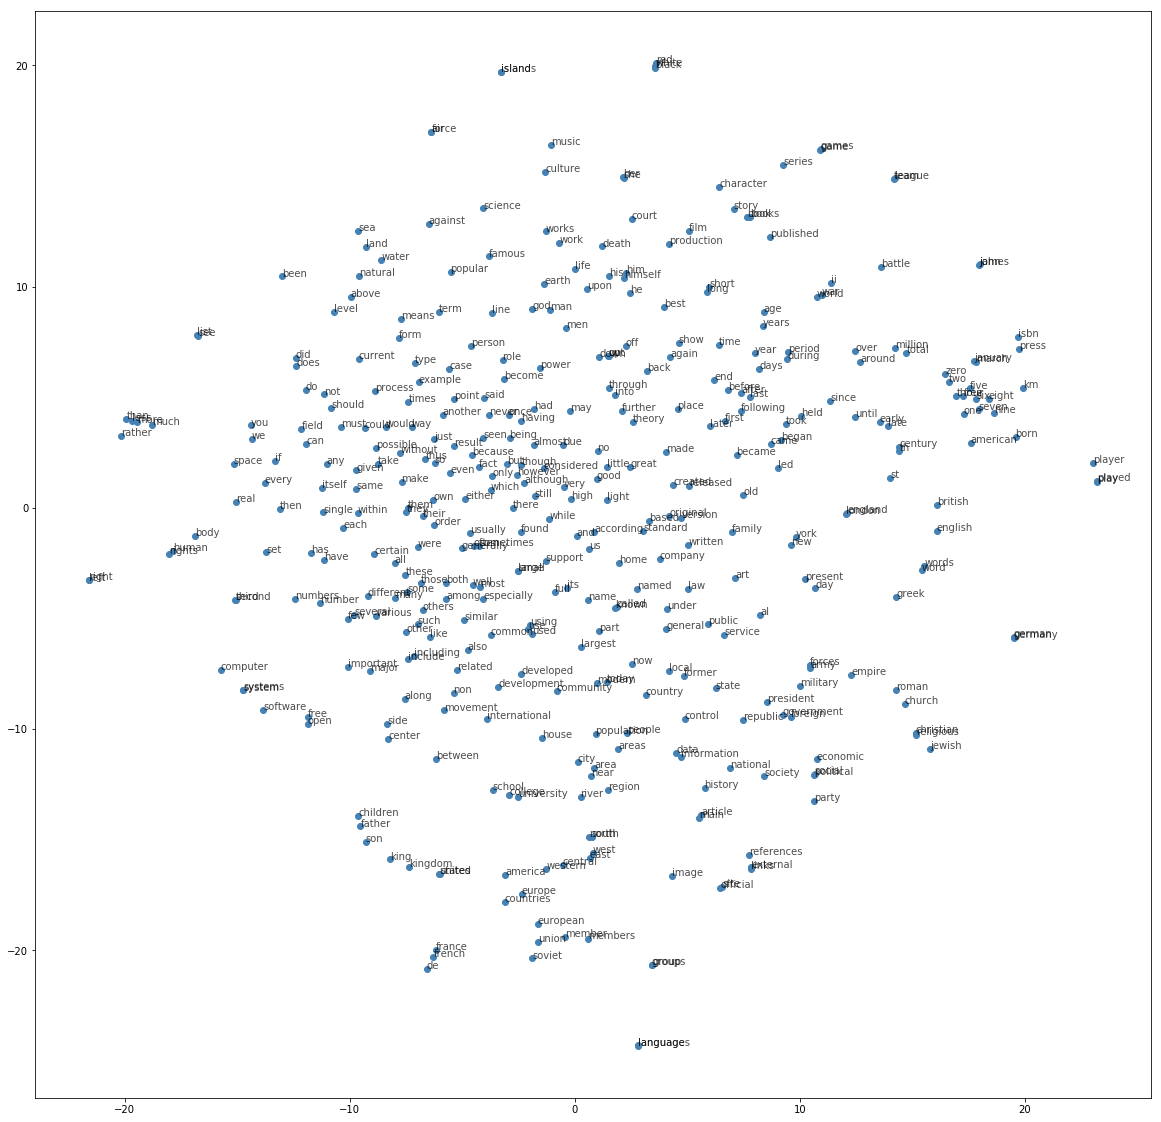

epoch: 28, avg. loss: 2.5997563440711238, gensim: 2374, accuracy: 19.351157482882297%


[481603]


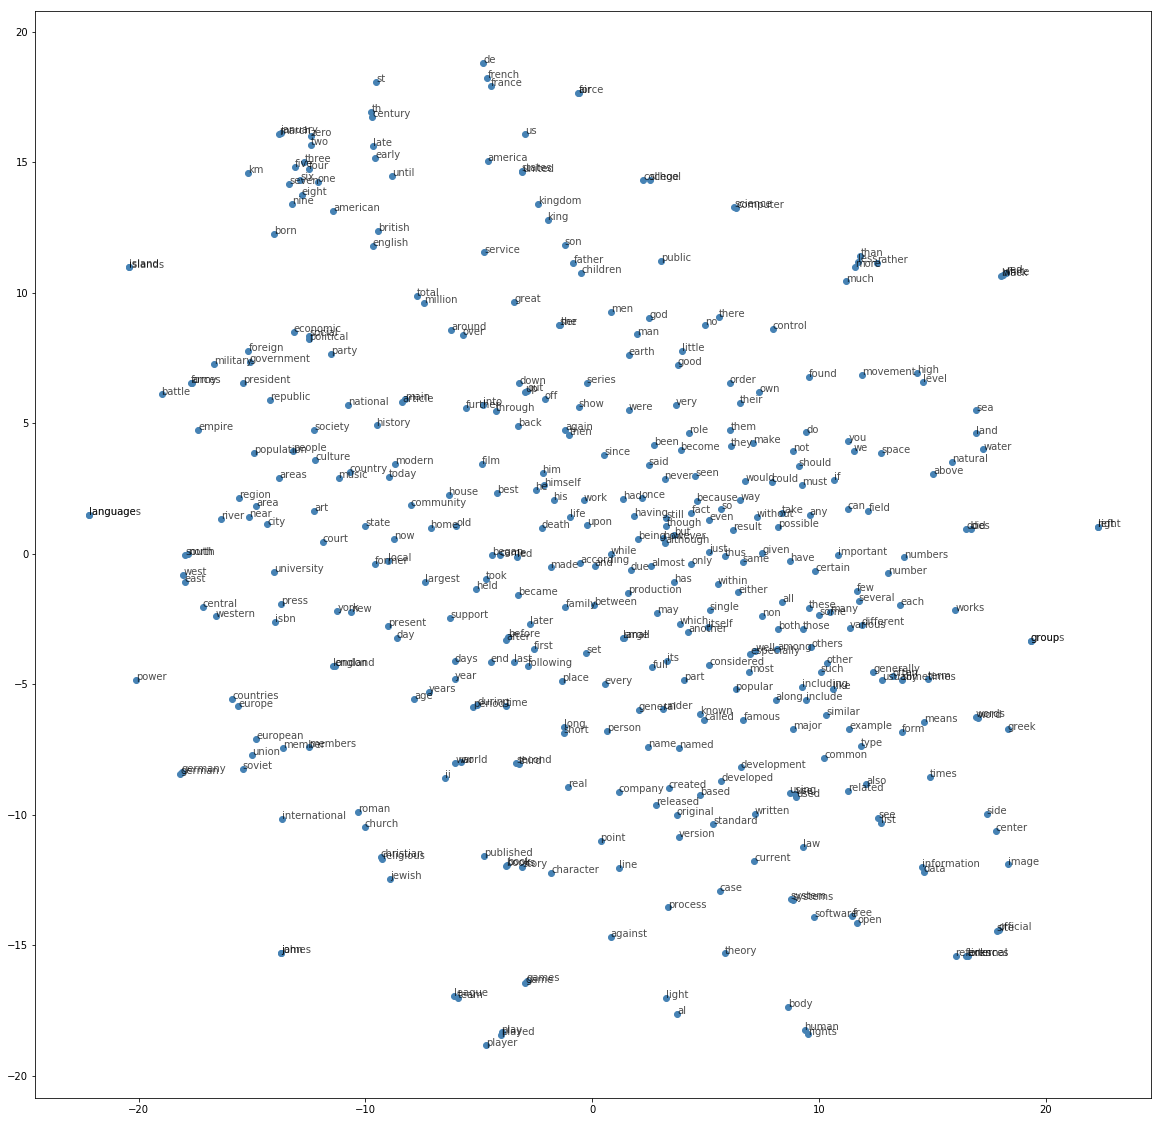

epoch: 29, avg. loss: 2.5967347618753616, gensim: 2381, accuracy: 19.408216498206716%


[498210]


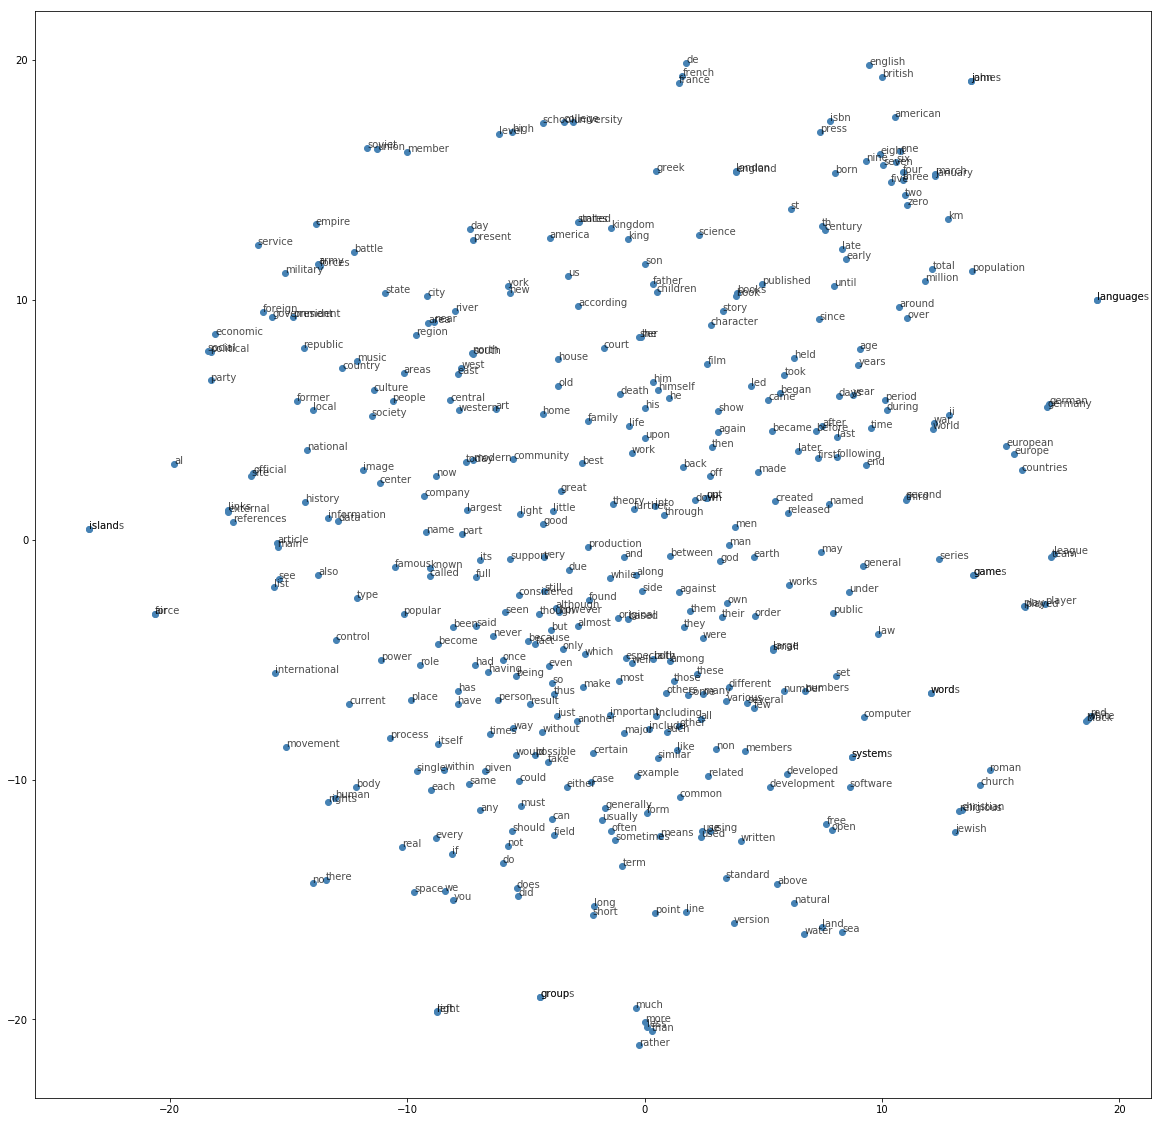

epoch: 30, avg. loss: 2.5959018948880845, gensim: 2361, accuracy: 19.24519074013694%


[514817]


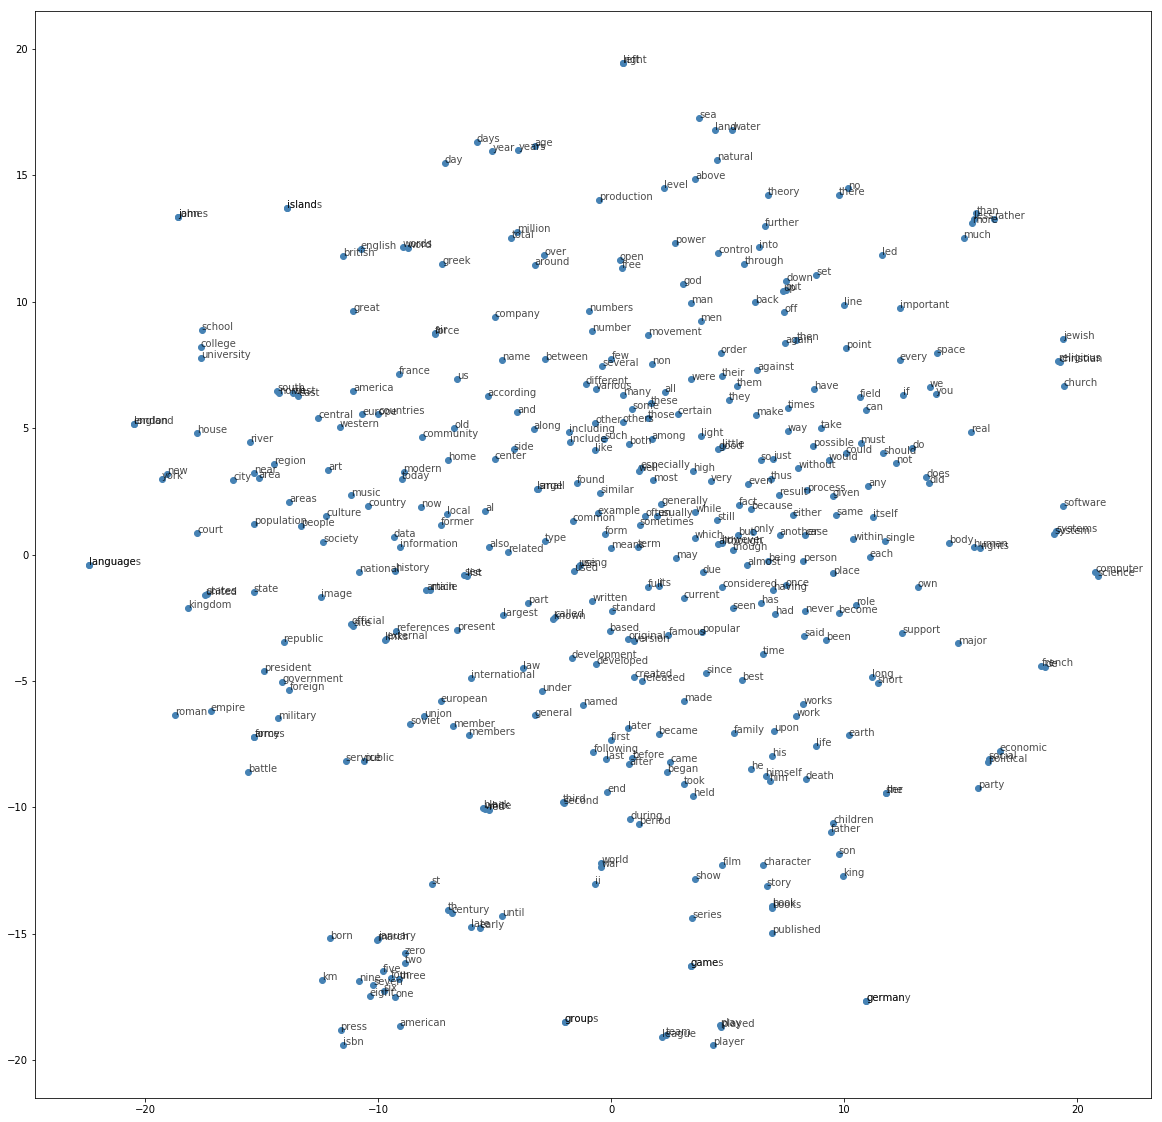

epoch: 31, avg. loss: 2.5895089359452936, gensim: 2360, accuracy: 19.237039452233454%


[531424]


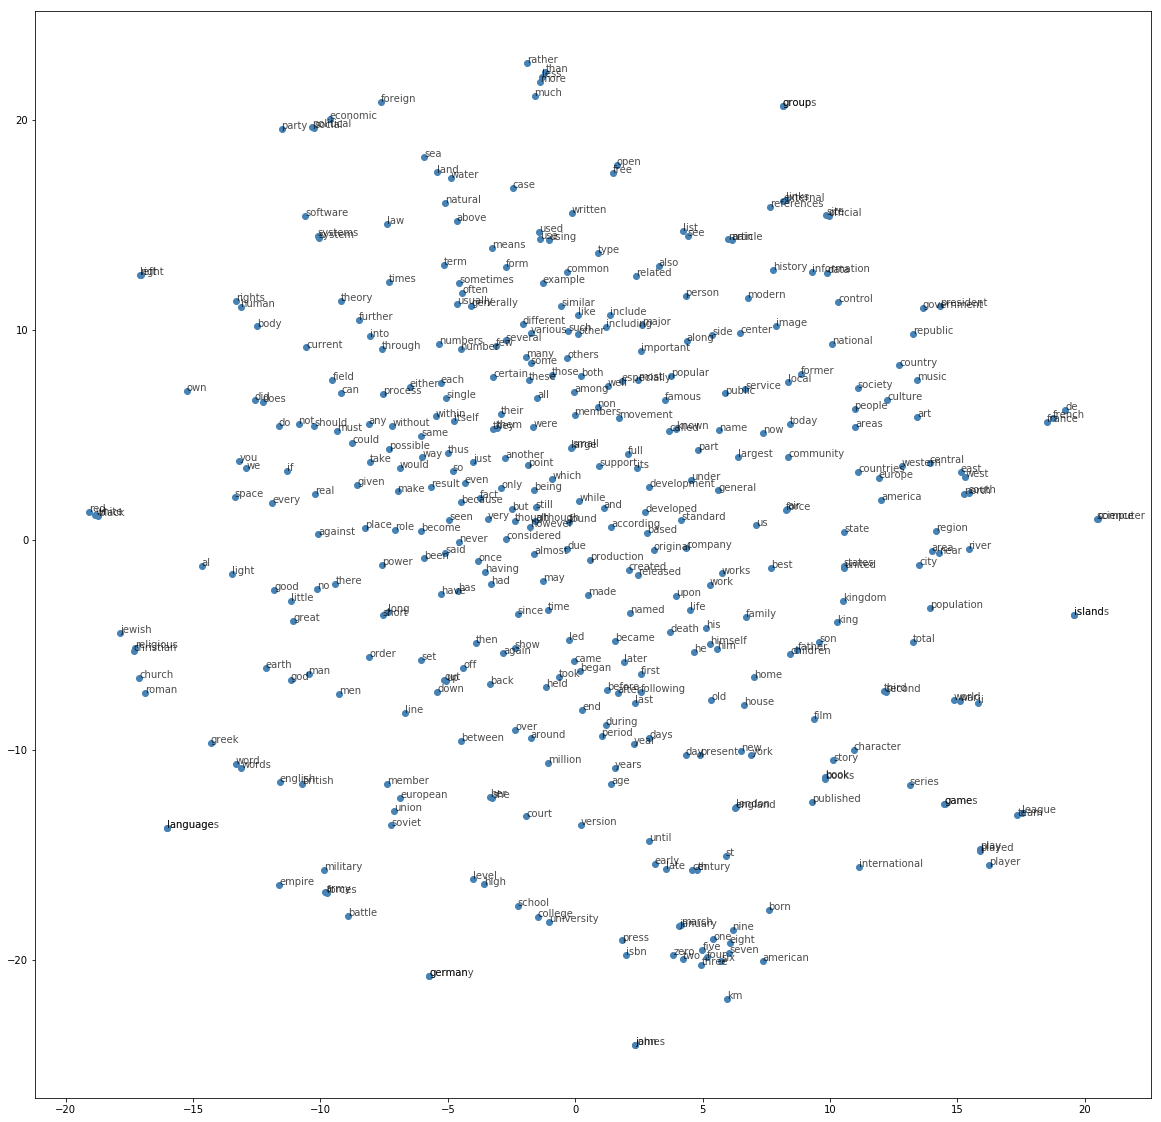

epoch: 32, avg. loss: 2.5961294053395196, gensim: 2387, accuracy: 19.45712422562765%


[548031]


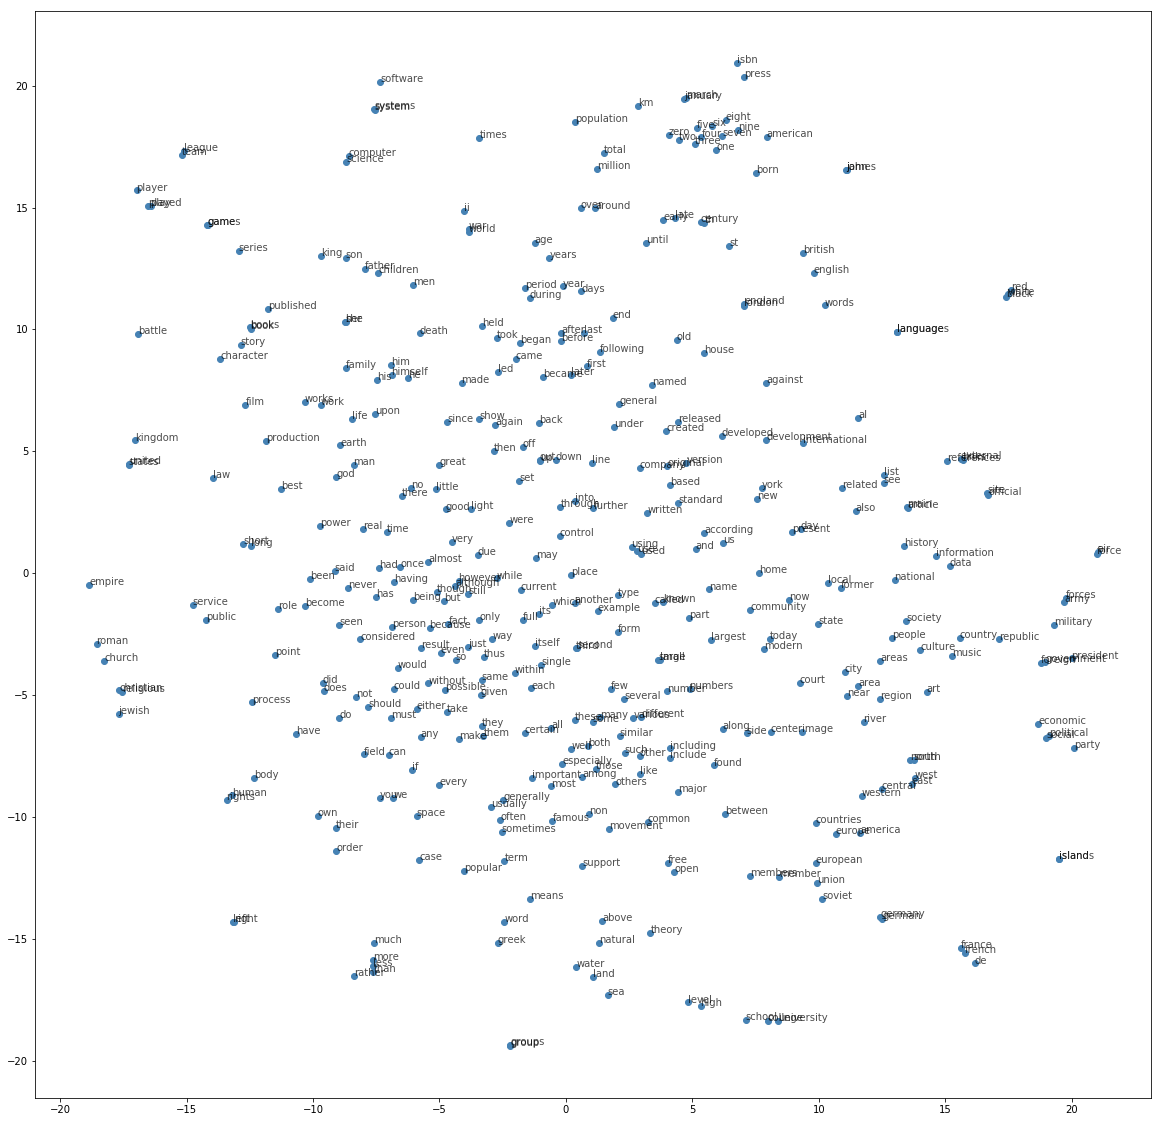

epoch: 33, avg. loss: 2.591755541453296, gensim: 2390, accuracy: 19.481578089338115%


[564638]


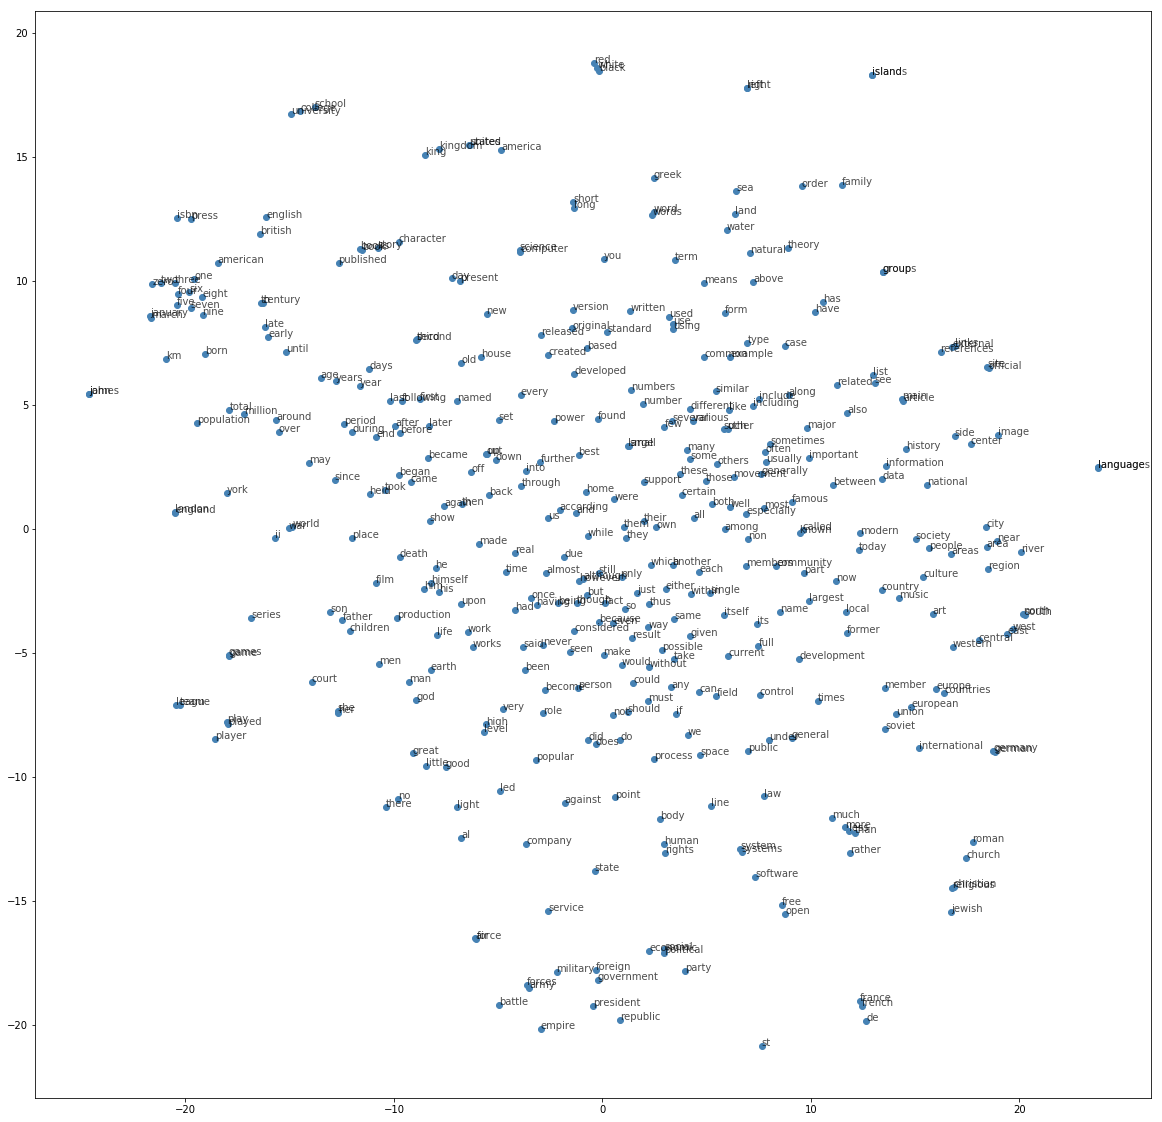

epoch: 34, avg. loss: 2.5939195064136404, gensim: 2400, accuracy: 19.563090968373004%


[581245]


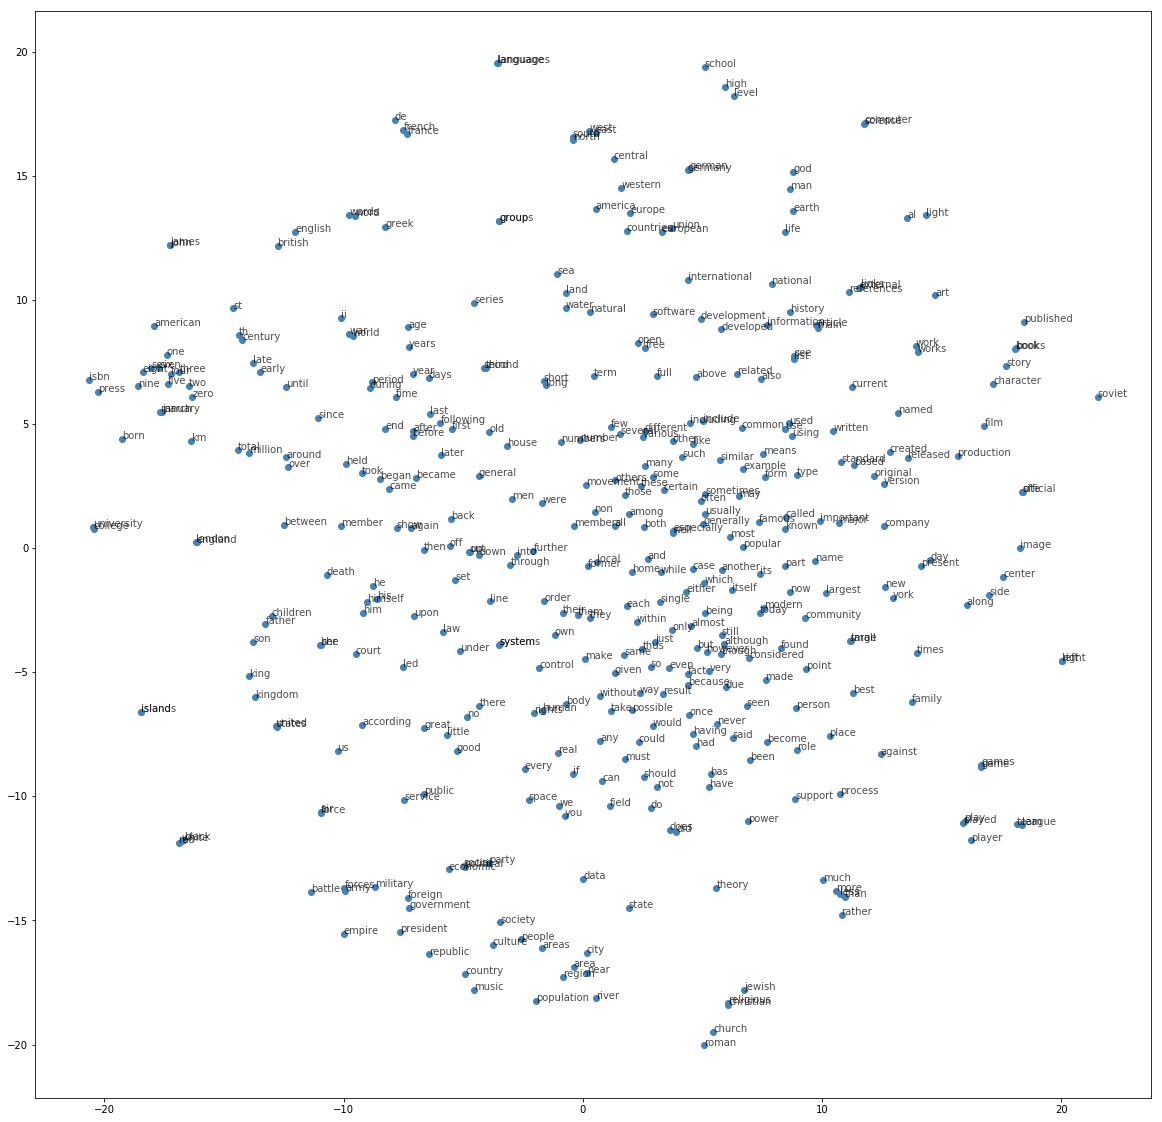

epoch: 35, avg. loss: 2.591585676829943, gensim: 2399, accuracy: 19.554939680469513%


[597852]


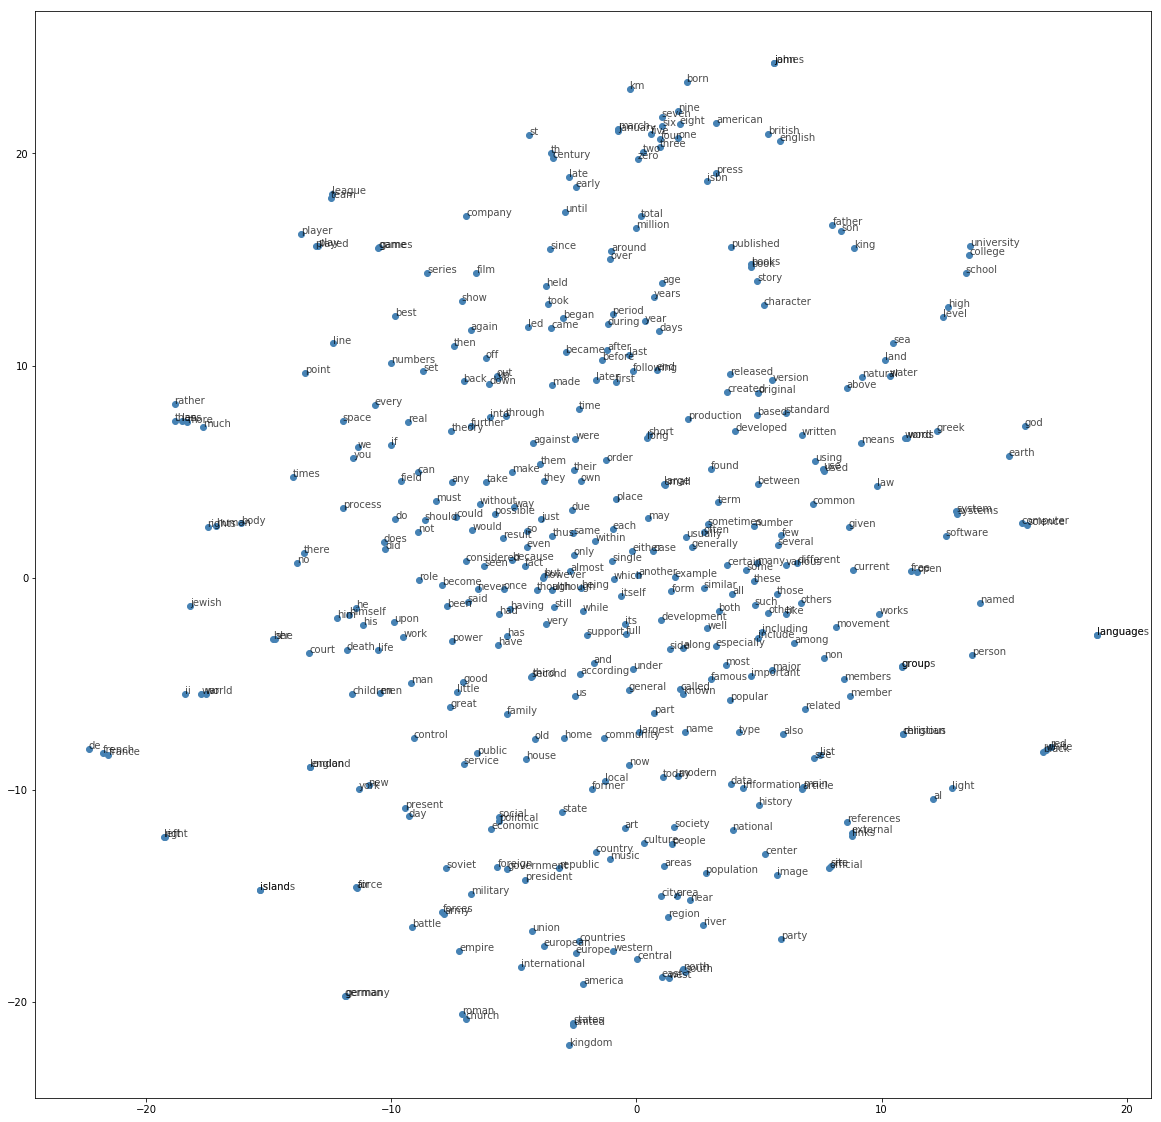

epoch: 36, avg. loss: 2.5929491775278515, gensim: 2385, accuracy: 19.440821649820673%


[614459]


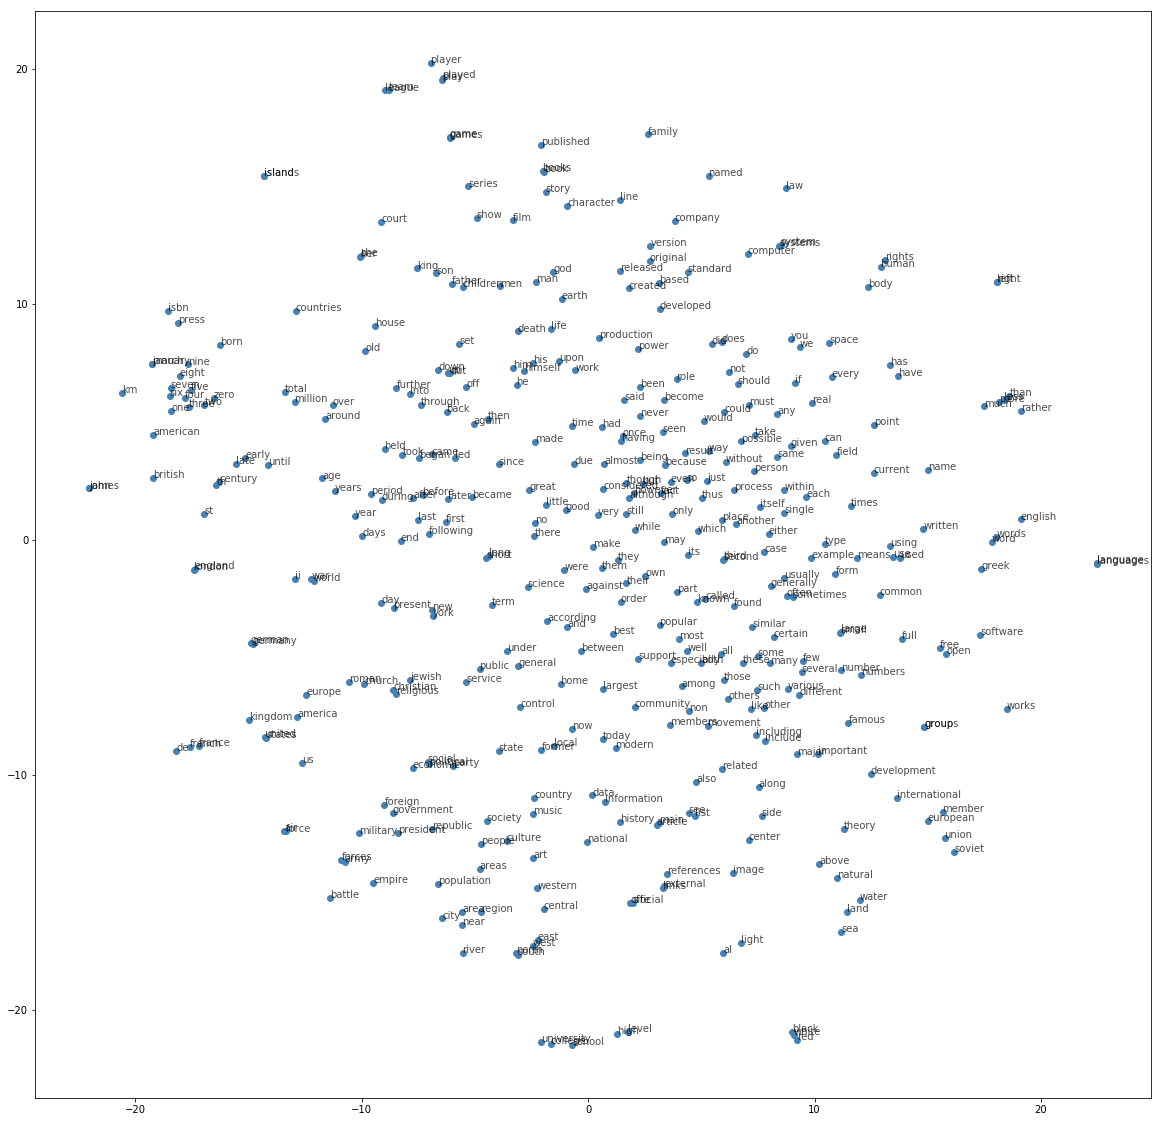

epoch: 37, avg. loss: 2.5904858648348013, gensim: 2387, accuracy: 19.45712422562765%


[631066]


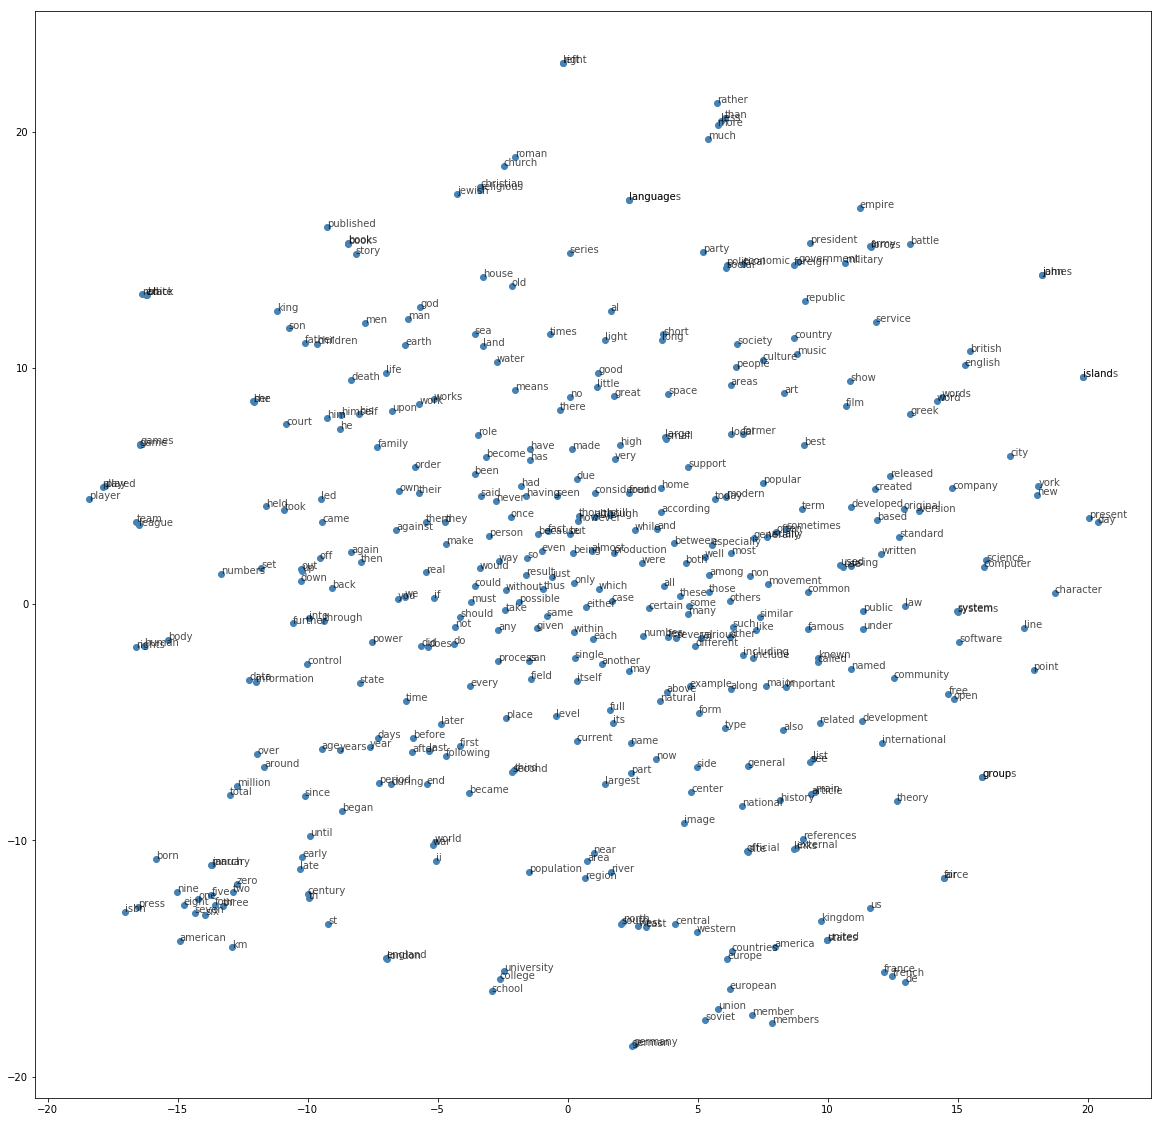

epoch: 38, avg. loss: 2.59882772258709, gensim: 2399, accuracy: 19.554939680469513%


[647673]


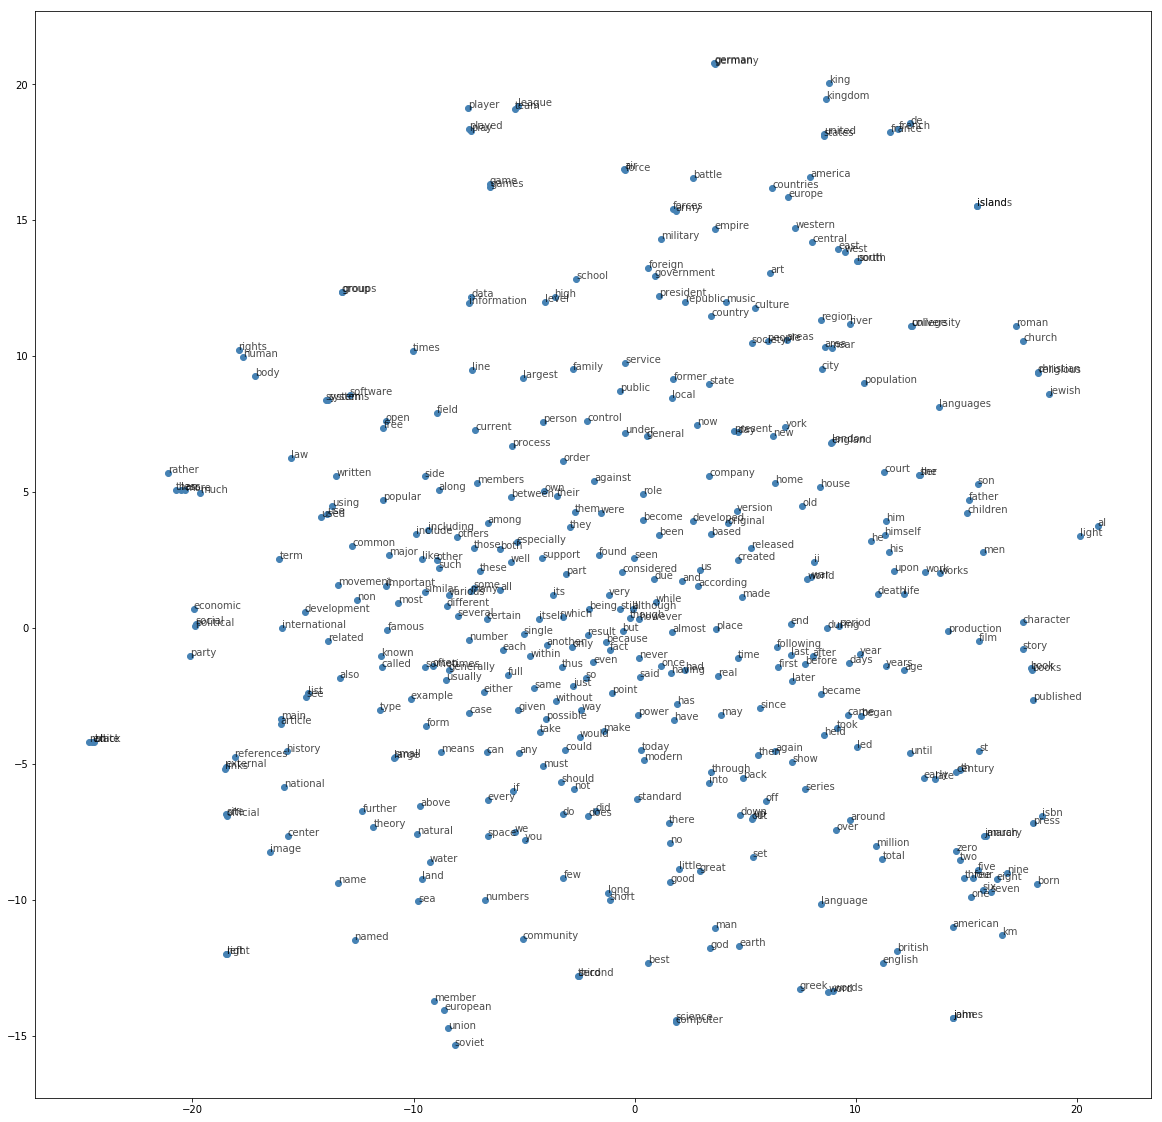

epoch: 39, avg. loss: 2.5887456973607503, gensim: 2396, accuracy: 19.530485816759047%


[664280]


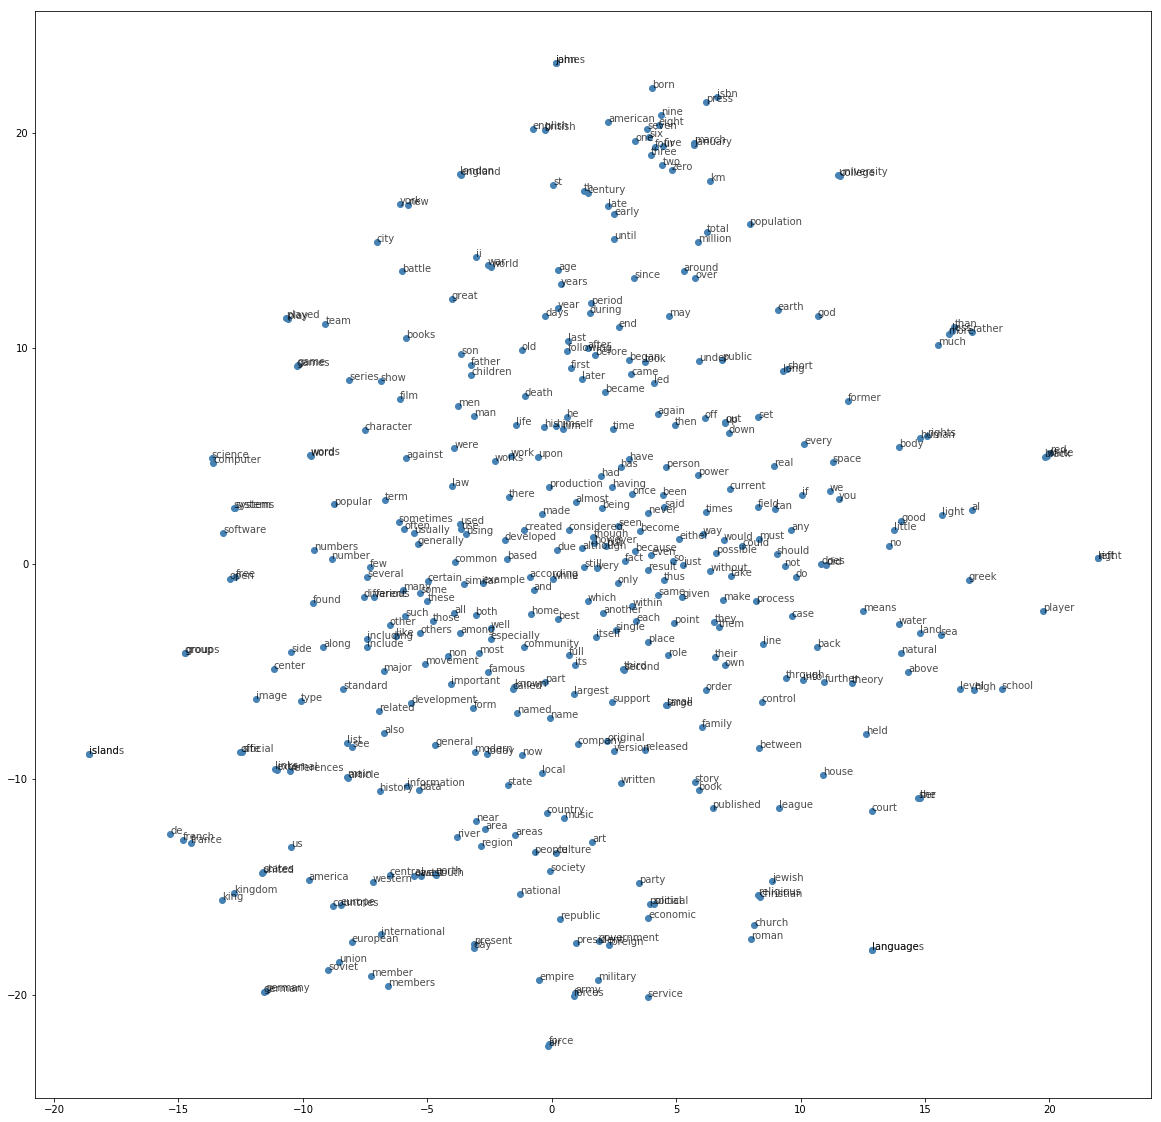

epoch: 40, avg. loss: 2.592883723756708, gensim: 2401, accuracy: 19.57124225627649%


[680887]


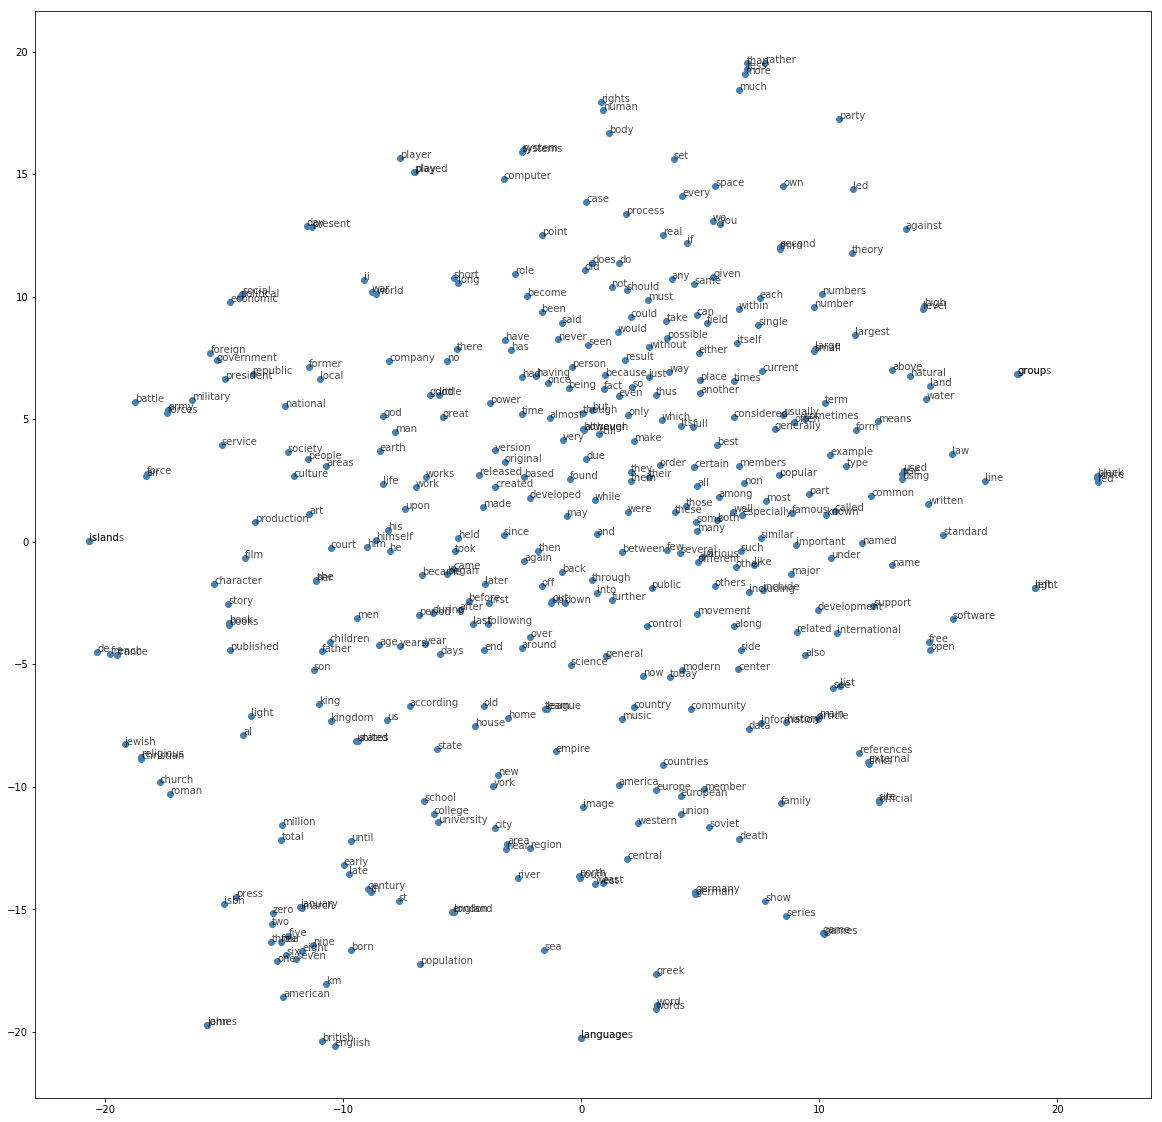

epoch: 41, avg. loss: 2.5859851825861186, gensim: 2402, accuracy: 19.57939354417998%


[697494]


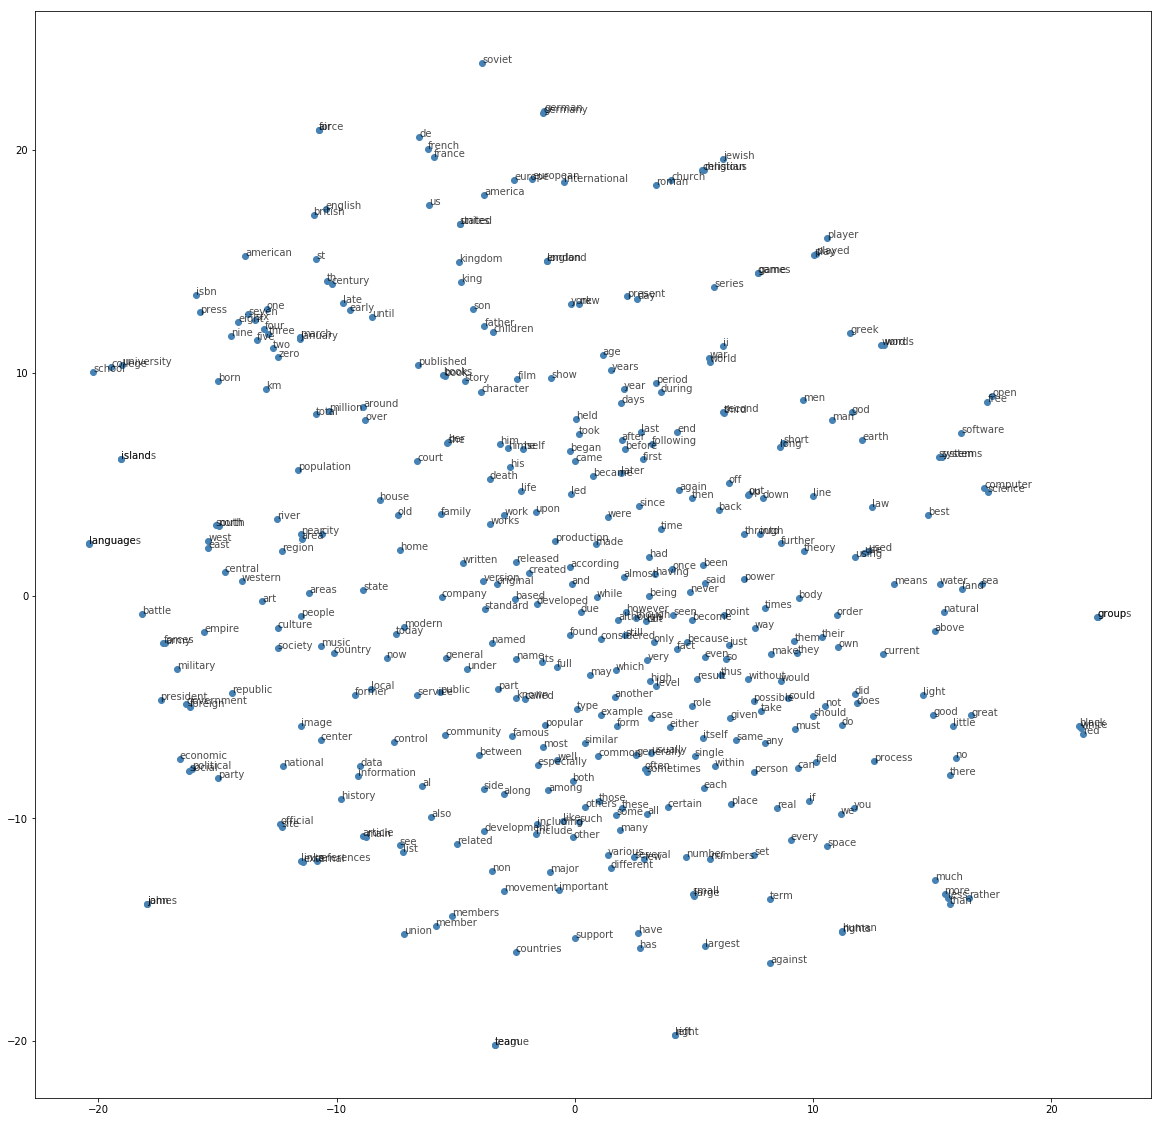

epoch: 42, avg. loss: 2.5956744064564146, gensim: 2394, accuracy: 19.51418324095207%


[714101]


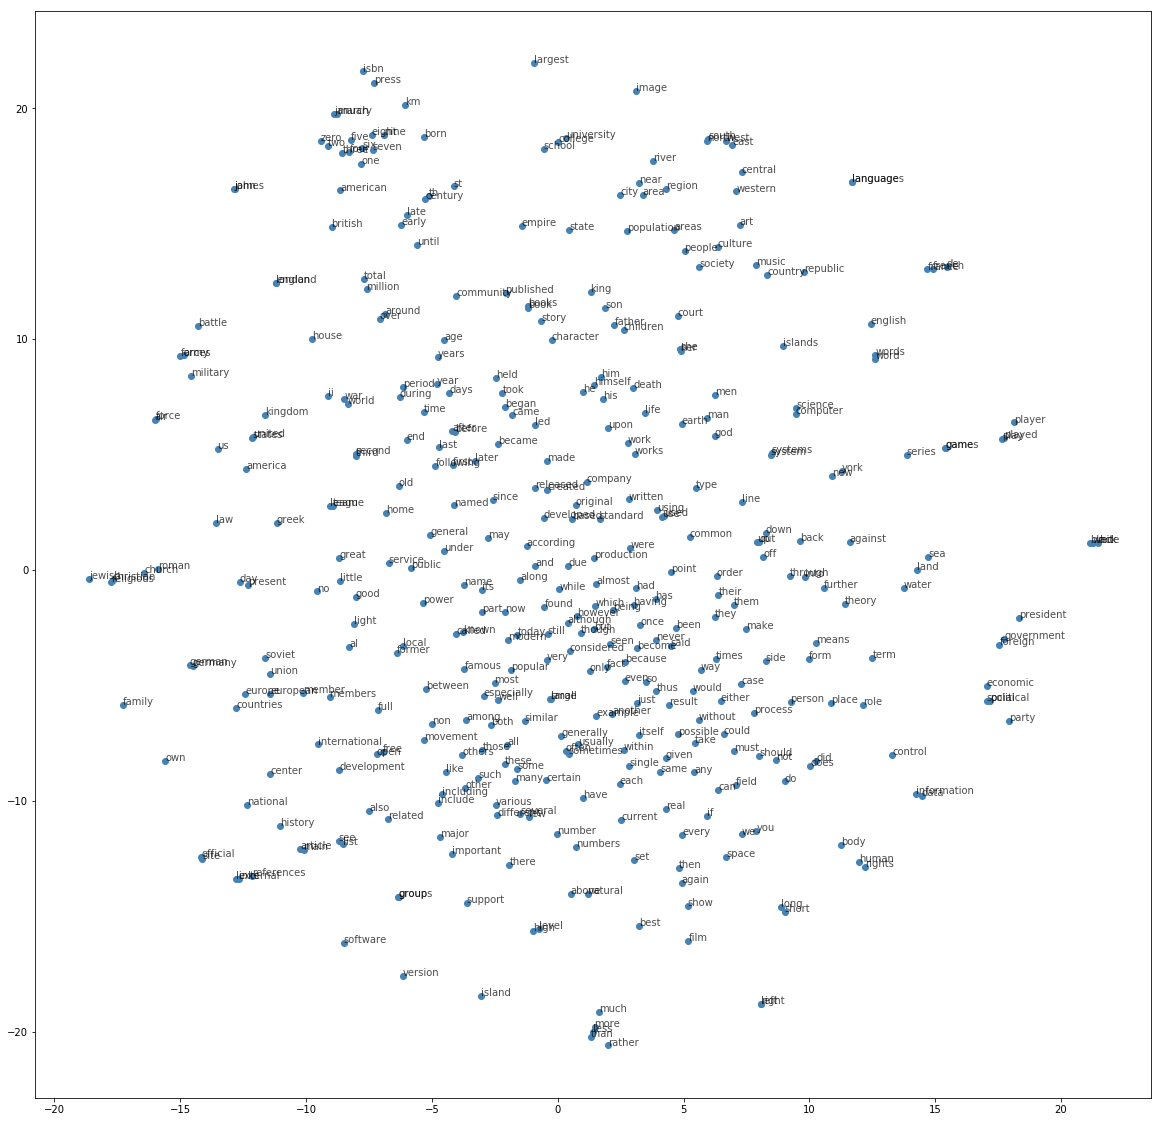

epoch: 43, avg. loss: 2.5908748877247967, gensim: 2401, accuracy: 19.57124225627649%


[730708]


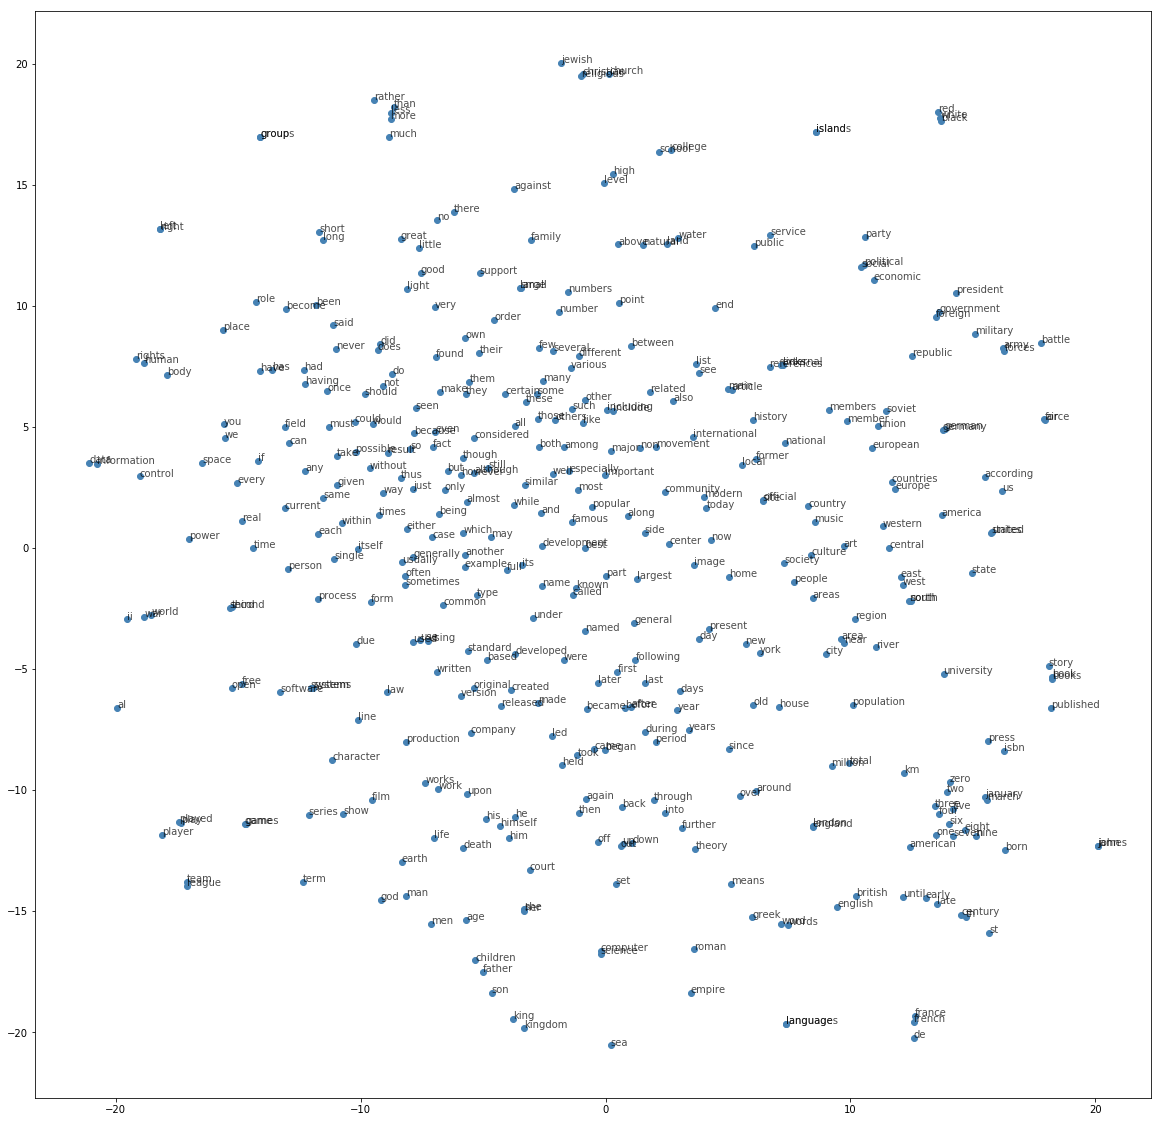

epoch: 44, avg. loss: 2.5956141241248827, gensim: 2397, accuracy: 19.538637104662538%


[747315]


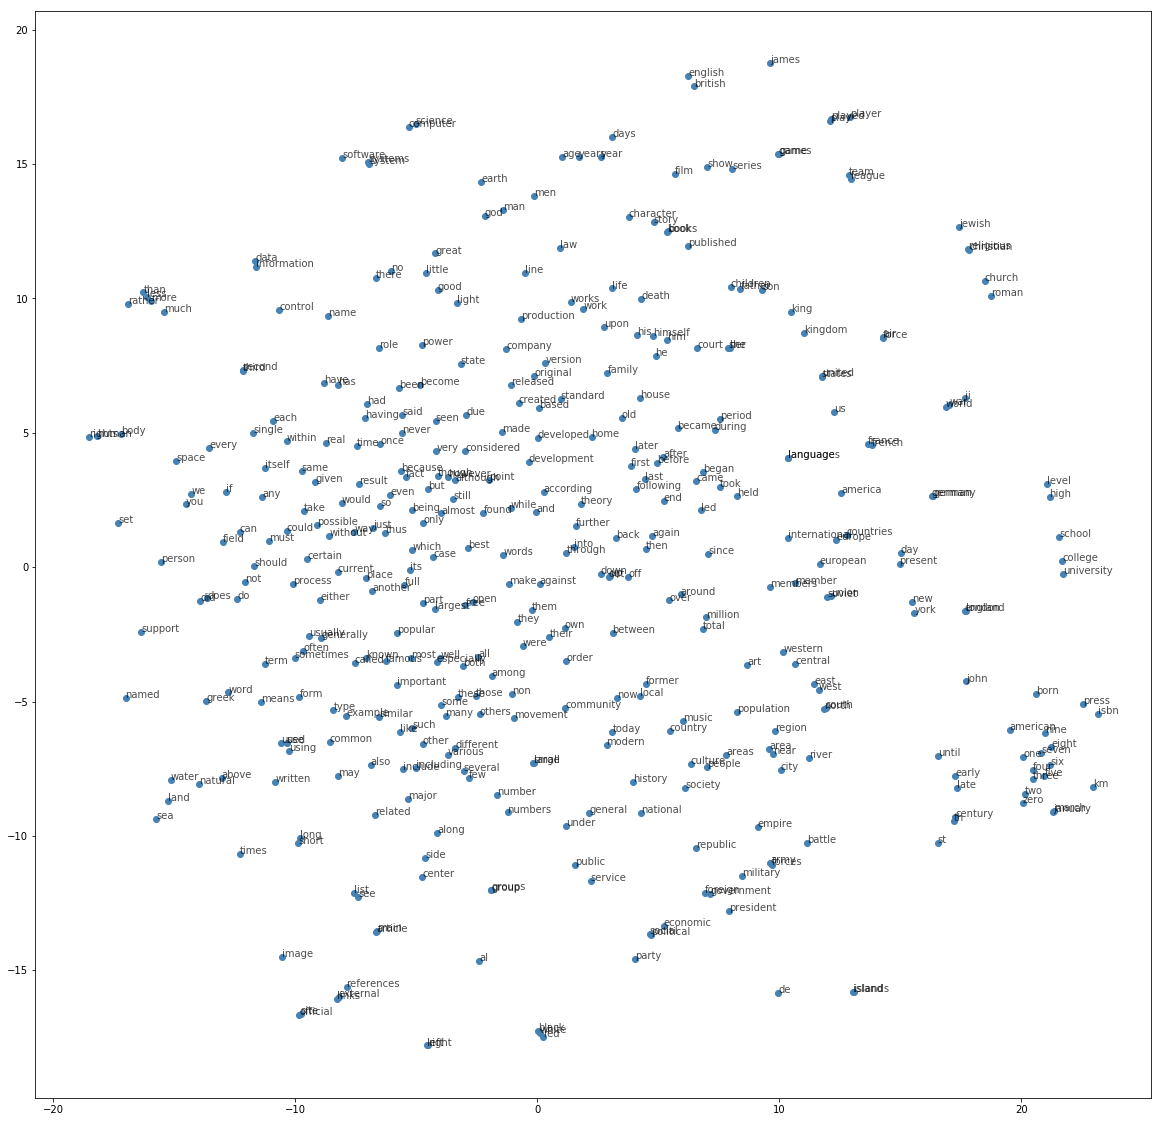

epoch: 45, avg. loss: 2.5949016672962157, gensim: 2400, accuracy: 19.563090968373004%


[763922]


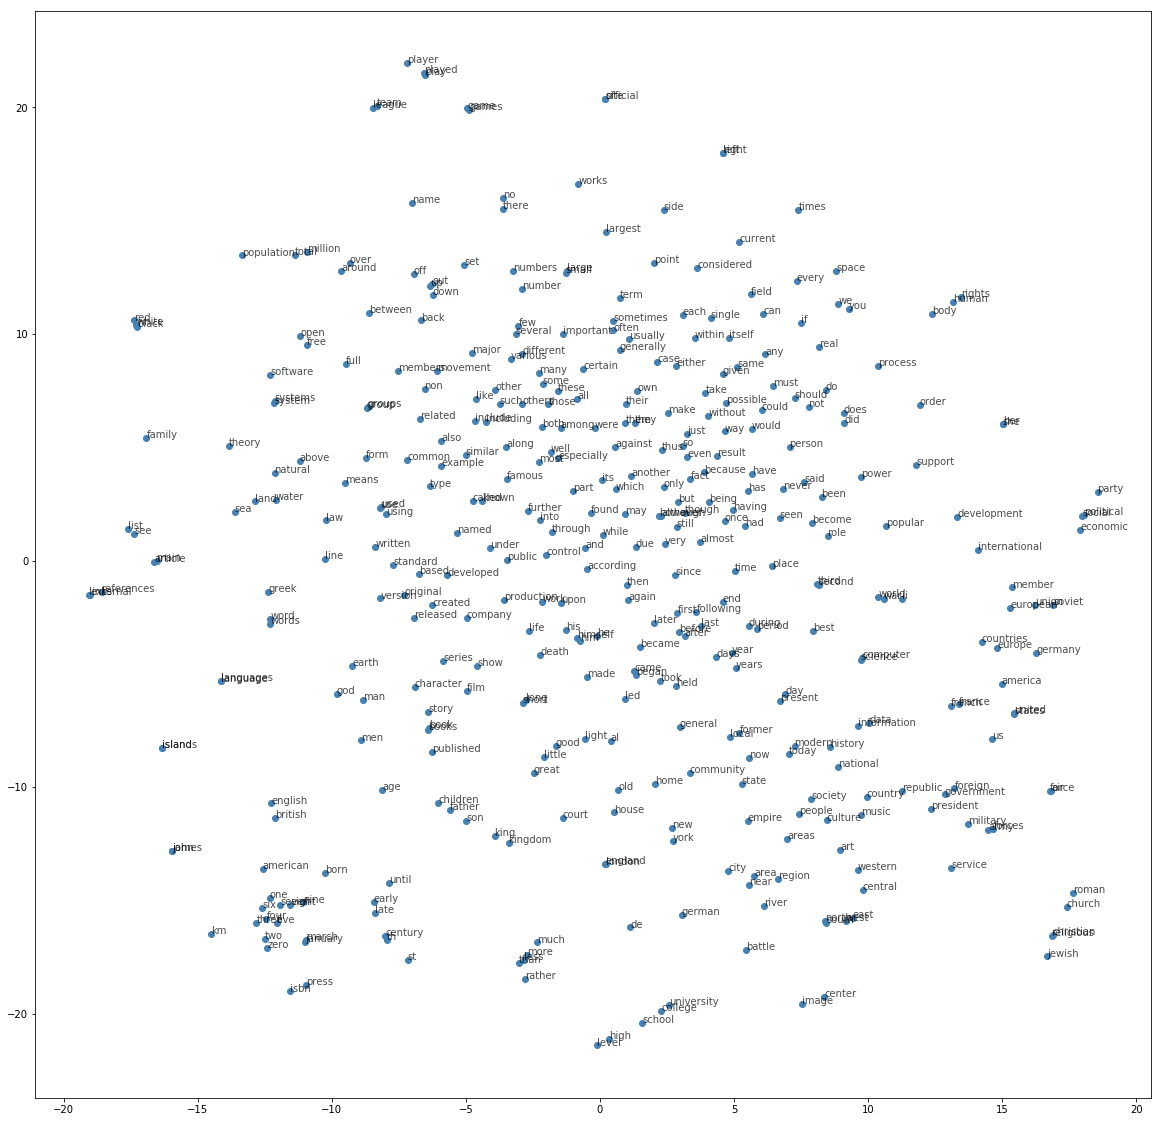

epoch: 46, avg. loss: 2.5972066964271088, gensim: 2397, accuracy: 19.538637104662538%


[780529]


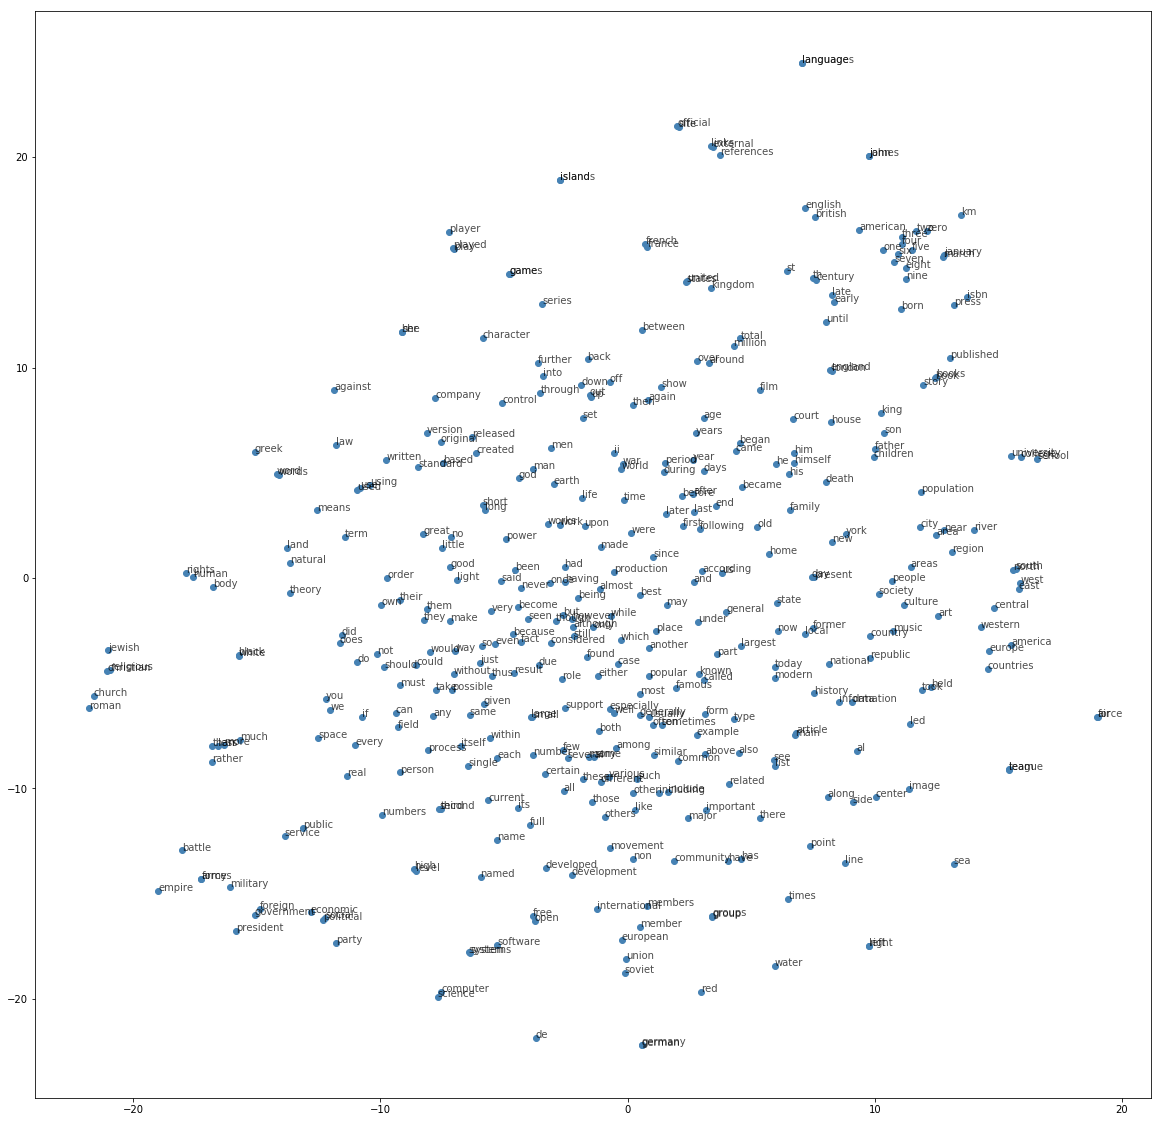

epoch: 47, avg. loss: 2.586456377876748, gensim: 2399, accuracy: 19.554939680469513%


[797136]


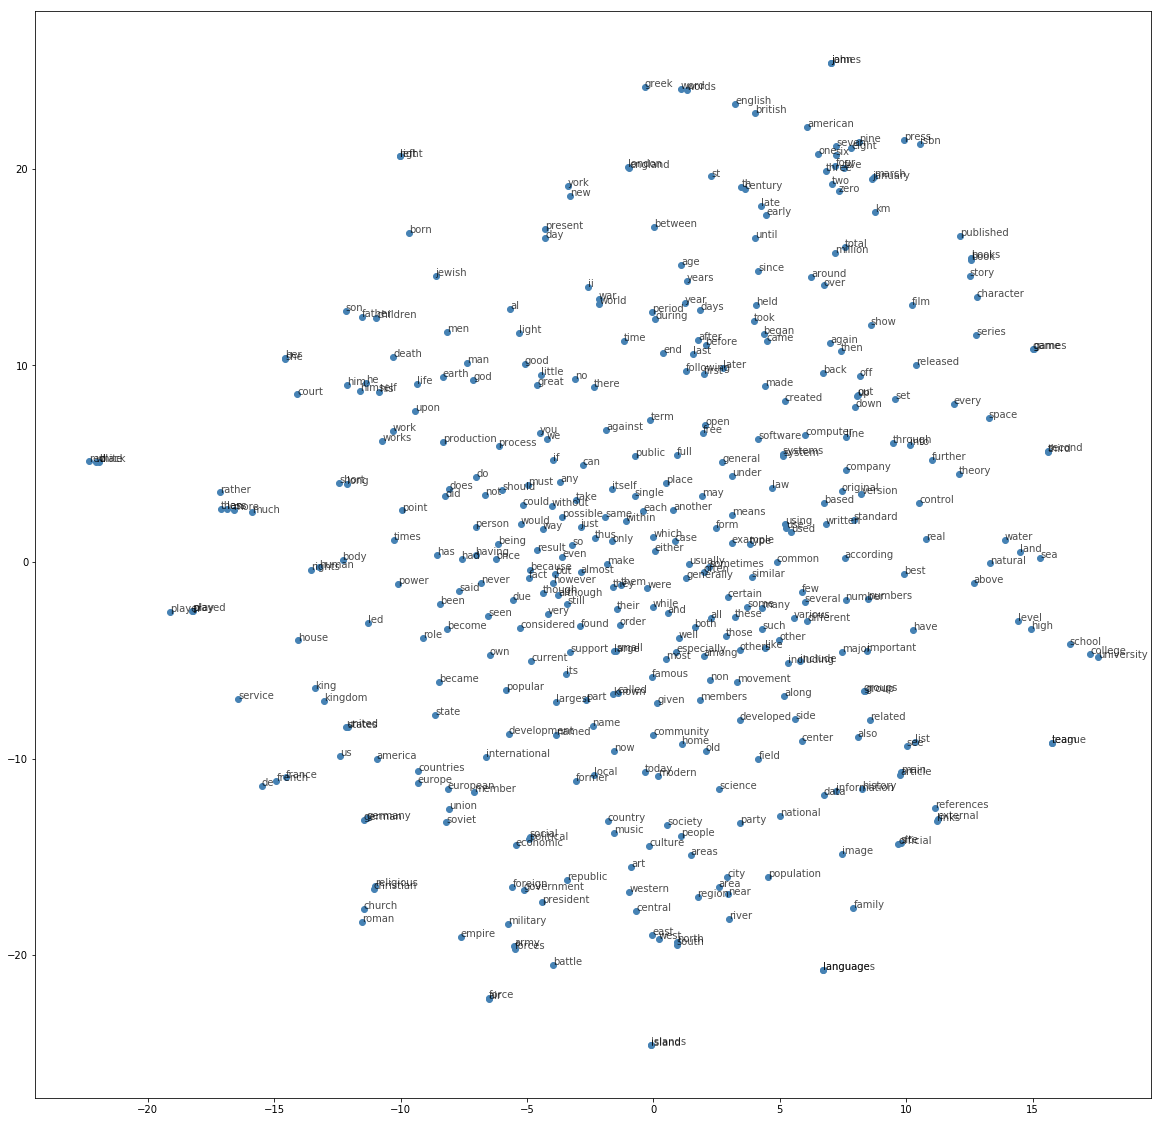

epoch: 48, avg. loss: 2.5928826967311807, gensim: 2395, accuracy: 19.52233452885556%


[813743]


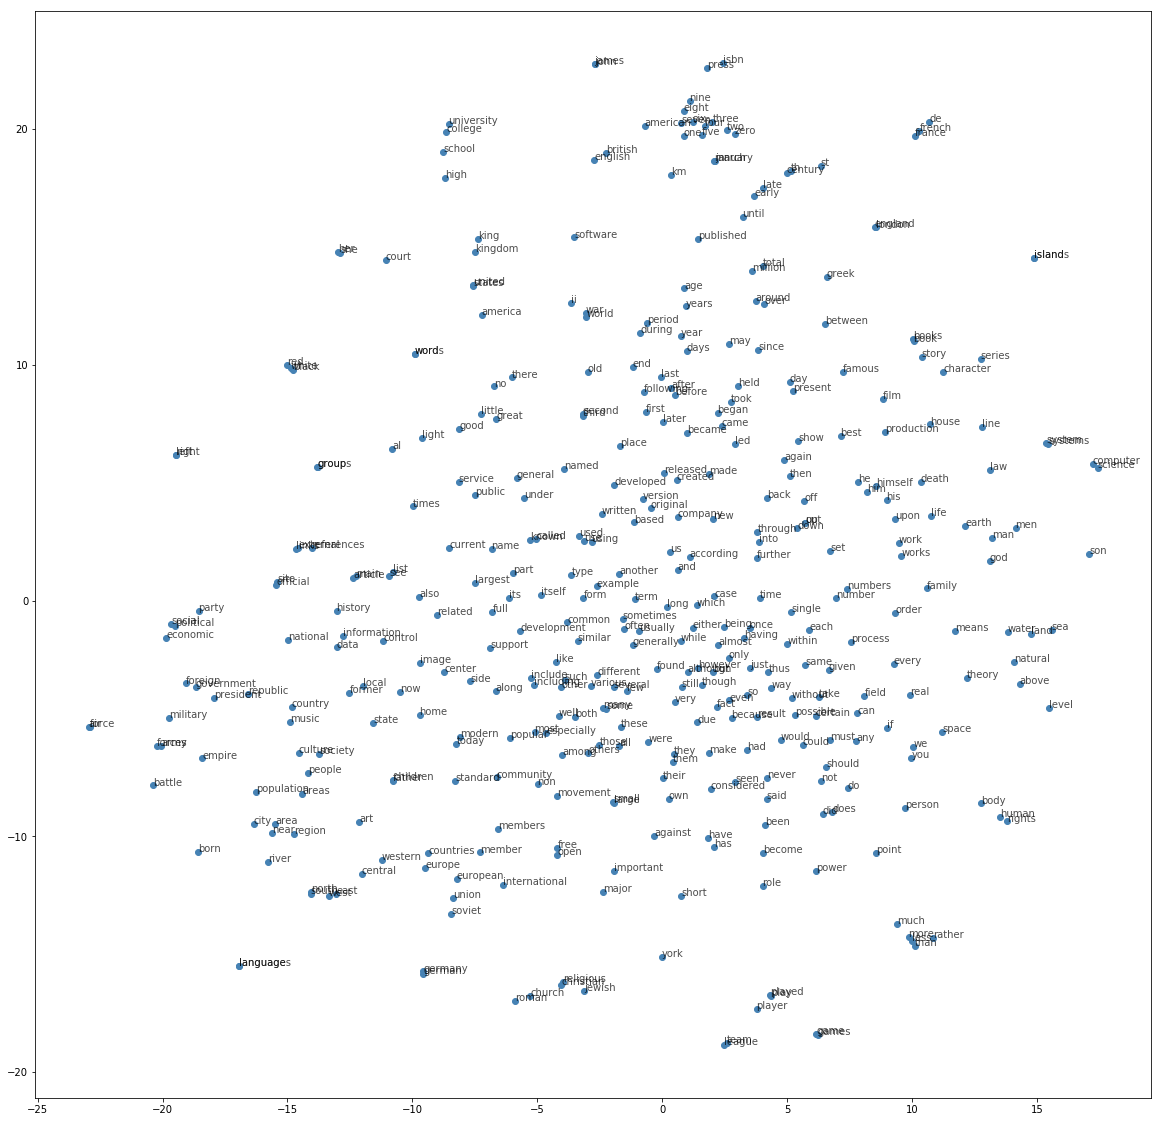

epoch: 49, avg. loss: 2.5977239215365486, gensim: 2396, accuracy: 19.530485816759047%


[830350]


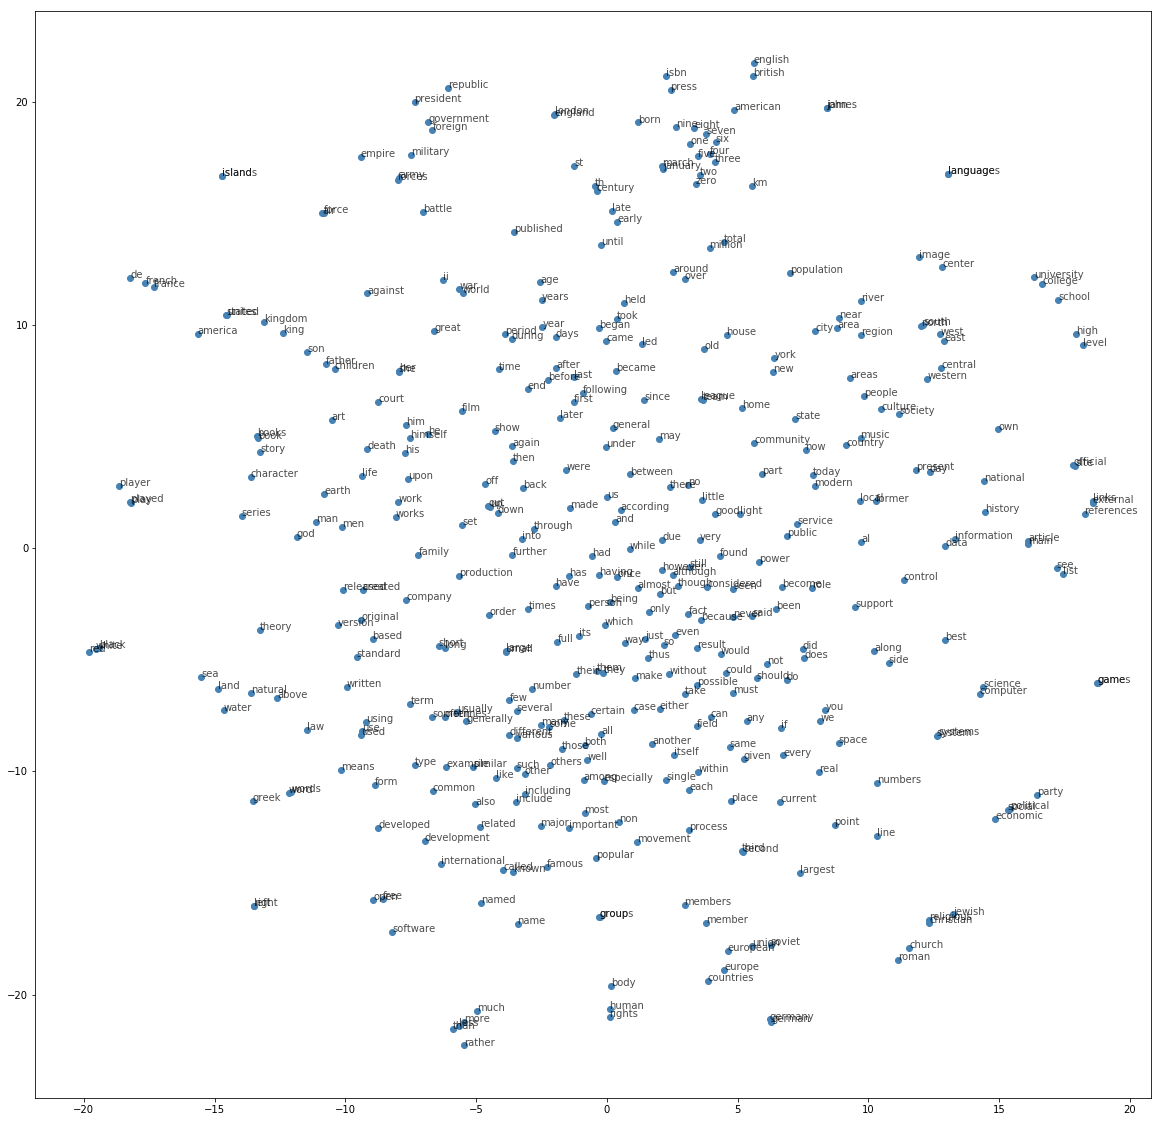

epoch: 50, avg. loss: 2.5923271298881216, gensim: 2394, accuracy: 19.51418324095207%


[846957]


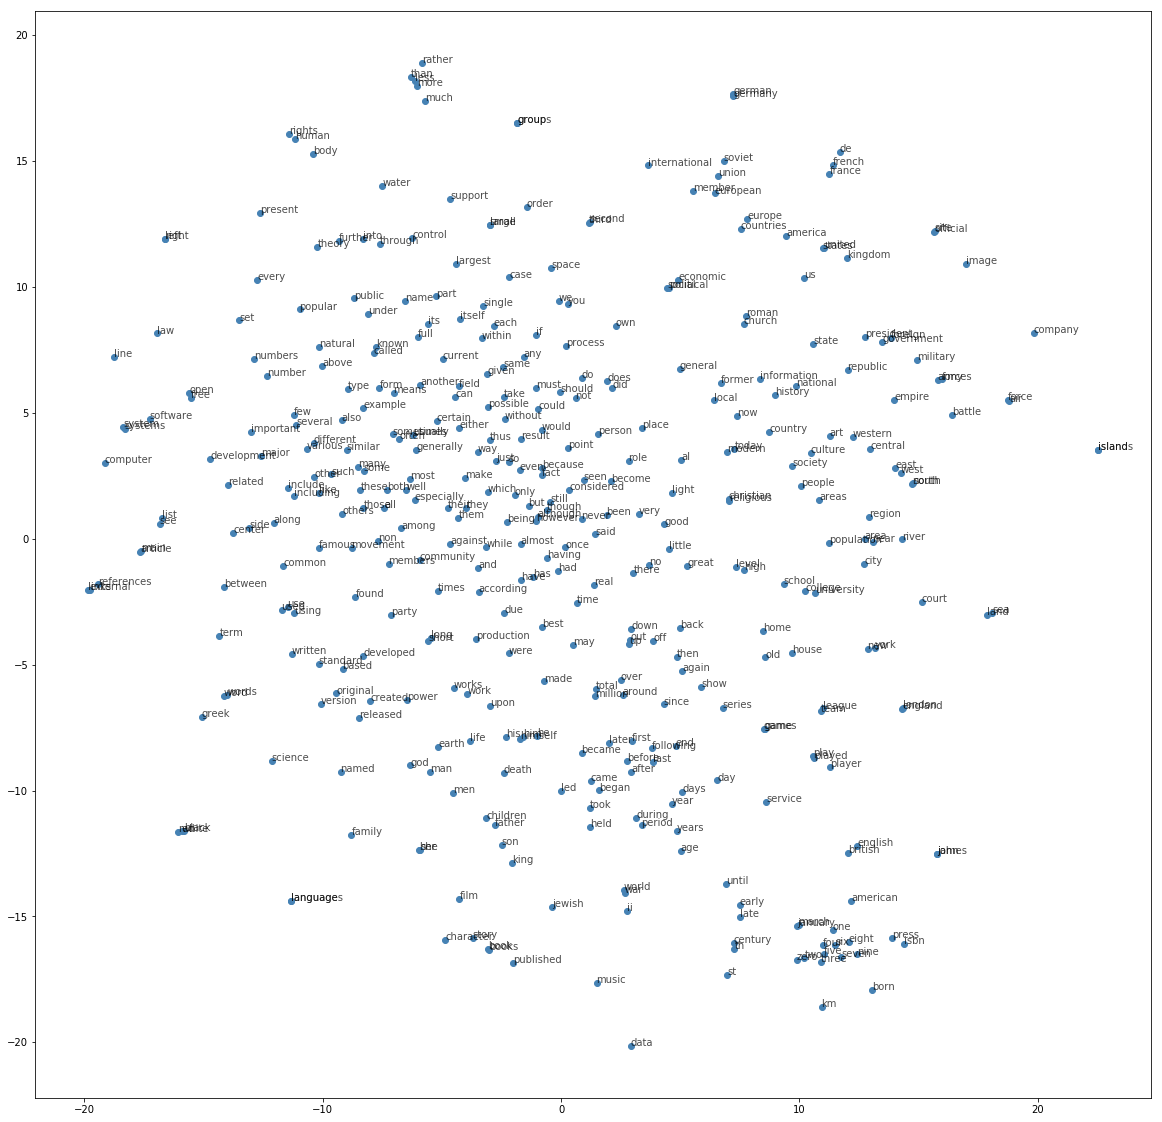

epoch: 51, avg. loss: 2.5927090643806774, gensim: 2396, accuracy: 19.530485816759047%


In [ ]:
step_size = 2 * window_size * len(corpus) / batch_size

epoch = 0
with tf.Session(graph=graph) as session:
    init.run()
    while True:
        epoch += 1
        suma = 0.0

        for step in tqdm(range(0, 2 * window_size * len(corpus), batch_size)):
            _, loss_val = session.run([optimizer, loss])
            suma += loss_val
        steps = session.run([global_step])
        print(steps)
        # Display map & test questions-words
        ev = embedding.eval()
        visualize(ev, 400)
        cr, tt = evaluate(ev, int2word, './questions-words.txt')

        print("epoch: {}, avg. loss: {}, gensim: {}, accuracy: {}%".format(epoch, suma/step_size, cr, 100.0*cr/tt))
